# Construisez un modèle de scoring
Vous êtes Data Scientist au sein d'une société financière, nommée "Prêt à dépenser",  qui propose des crédits à la consommation pour des personnes ayant peu ou pas d'historique de prêt.

Pour accorder un crédit à la consommation, l’entreprise calcule la probabilité qu’un client le rembourse, ou non. Elle souhaite donc développer un algorithme de scoring pour aider à décider si un prêt peut être accordé à un client.

Les chargés de relation client seront les utilisateurs du modèle de scoring. Puisqu’ils s’adressent aux clients, ils ont besoin que votre modèle soit facilement interprétable. Les chargés de relation souhaitent, en plus, disposer d’une mesure de l’importance des variables qui ont poussé le modèle à donner cette probabilité à un client.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
from typing import List
from scipy.stats import skew
import scipy.stats as stats

In [3]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:
#base_directory = "/kaggle/input/home-credit-default-risk/"
base_directory = "../data/home-credit-default-risk/"

In [5]:
def optimize_floats(df: pd.DataFrame) -> pd.DataFrame:
    floats = df.select_dtypes(include=['float64']).columns.tolist()
    df[floats] = df[floats].apply(pd.to_numeric, downcast='float')
    return df


def optimize_ints(df: pd.DataFrame) -> pd.DataFrame:
    ints = df.select_dtypes(include=['int64']).columns.tolist()
    df[ints] = df[ints].apply(pd.to_numeric, downcast='integer')
    return df


def optimize_objects(df: pd.DataFrame, datetime_features: List[str]) -> pd.DataFrame:
    for col in df.select_dtypes(include=['object']):
        if col not in datetime_features:
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if float(num_unique_values) / num_total_values < 0.5:
                df[col] = df[col].astype('category')
        else:
            df[col] = pd.to_datetime(df[col])
    return df



def optimize(df: pd.DataFrame, datetime_features: List[str] = []):
    return optimize_floats(optimize_ints(optimize_objects(df, datetime_features)))


def optimized_merge(df1, df2, merge_column):    
    df2 = df2[df2[merge_column].isin(df1[merge_column])]
    df2 = df2.sample(frac=.20)
    return df1.merge(df2, how= 'left', on=merge_column)


In [6]:
def categorical_info(df, feature,label_rotation=0, no_graph=0):
       
    if no_graph == 0:
        print(f"--------------------------")
        print(f"-- {feature:20s} --")
        print(f"--------------------------")
    
    print(f"{df[feature].isna().sum()} valeurs manquantes")    
        
    print('---------------------------')    
    df['CORR'] = df[feature].astype('category').cat.codes
    print(f"{df['CORR'].corr(df['TARGET']) * 100:.2f}% de corrélation entre {feature} et TARGET")
    print('---------------------------')
    df = df.drop('CORR', axis=1)
    
    if no_graph == 0:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6), constrained_layout=True)
    
        # Affichage de le répartition
        s = sns.barplot(ax=ax1, x = df[feature].value_counts().index, y=df[feature].value_counts())        
        ax1.set(xlabel=feature, ylabel='Total contrats', title='Répartition de ' + feature)    
        s.set_xticklabels(s.get_xticklabels(),rotation=label_rotation)
            
        s = sns.countplot(feature, hue="TARGET", data=df, ax=ax2)
        ax2.set(xlabel=feature, ylabel="Total", title="Comparaison incident ou non de paiement")    
        s.set_xticklabels(s.get_xticklabels(),rotation=label_rotation)

        plt.tick_params(axis='both', which='major', labelsize=10)    
        plt.show();

In [7]:
def show_distribution(df, feature):
    plt.figure(figsize=(10,6))
    plt.title(f"Répartition de {feature}")
    sns.distplot(df[feature].dropna(), kde=True)
    plt.show() 

In [8]:
def show_compare(df, feature):    
    sns.distplot(df[df['TARGET'] == 1][feature].dropna(), kde = True, bins=100, color="r")
    sns.distplot(df[df['TARGET'] == 0][feature].dropna(), kde = True, bins=100, color="g")
    plt.show()

In [9]:
def show_numerical(df, feature, no_graph=0):
    print(f"{df[feature].isna().sum()} valeurs manquantes")
    print('----------------------')
    print(f"Asymetrie : {skew(df[feature].dropna())}")
    print(f"LOG - Asymetrie : {skew(np.log(abs(df[feature]) + 1).dropna())}")
    print(f"SQR - Asymetrie : {skew(np.sqrt(abs(df[feature]).dropna()))}")

    if no_graph == 0:
        print('----------------------')
        print(f"Corrélation de {df[feature].corr(df['TARGET']) * 100:.2f}% entre {feature} et TARGET")
        print('----------------------')
        print(df[feature].describe())
        show_distribution(df, feature)
        show_compare(df, feature)


In [10]:
def high_correlation(df,threshold):  
    corr_list = []
    corr = df.corr()
    for i in range(len(corr)):
        for j in range(i):        
            if corr.iloc[i,j] >= threshold:                
                print(f"{corr.iloc[i,j] * 100:.2f} de corrélation entre {corr.columns[i]} et {corr.columns[j]}")            

In [11]:
def missing(df, threshold=0.5):
    
    fraction = application_train.isnull().sum() / application_train.shape[0]
    missing = pd.DataFrame(fraction)
    missing = missing.rename(columns={0: 'Fraction'})
    
    # Tri des données
    missing = missing.sort_values('Fraction', ascending = False)
    
    # Selection des données en fonction du déclencheur
    missing = fraction[fraction > threshold]
    
    return missing

# Exploration des données
Le jeu de données est contitué de 7 sources diférentes, dans un premier temps nous utiliserons le jeu de données principal (application_train.csv)

## Application
Il s'agit du tableau principal, divisé en deux fichiers un pour l'entrainement et l'autre pour le test. Nous allons explorer de jeu de données **application_train** car il contient les variables à prédire.

In [12]:
# Chargement des données
application_train = pd.read_csv(base_directory + 'application_train.csv')

# Optimisation des variables pour réduire l'empreinte mémoire
application_train = optimize(application_train)
application_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0        202500.000  406597.500    24700.500   
1               N             0        270000.000 1293502.500    35698.500   
2               Y             0         67500.000  135000.000     6750.000   
3               Y             0        135000.000  312682.500    29686.500   
4               Y             0        121500.000  513000.000    21865.500   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                      0.000                     0.000   
1                      0.000                     0.000   
2                      0.000                     0.000   
3                        nan                       nan   
4                      0.000                     0.000   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                       0.000                      0.000   
1                       0.000                      0.000   
2                       0.000                      0.000   
3                         nan                        nan   
4                       0.000                      0.000   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                      0.000                       1.000  
1                      0.000                       0.000  
2                      0.000                       0.000  
3                        nan                         nan  
4                      0.000                       0.000  

[5 rows x 122 columns]

In [13]:
application_train.shape

(307511, 122)

Le jeu de données contient 307511 clients et 121 variables explicatives (emploi, revenus, montant du crédit, durée du crédit, etc.)

La variable à prédire est une variable booléean où la valeur 0 représente le remboursement de crédit et 1 le non remboursement du crédit.

## Variable cible
La variable cible se nomme **TARGET** et à comme valeur 0 ou 1. 

1 pour les clients ayant des difficultés de paiement : il a eu des retards de paiement de plus de X jours sur au moins un des Y premiers versements du prêt dans notre échantillon et 0 dans tous les autres cas.


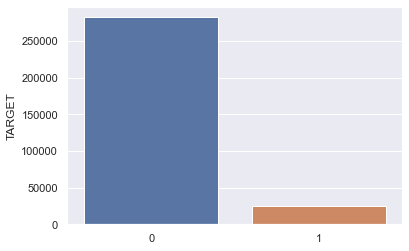

In [13]:
sns.barplot(x=application_train["TARGET"].value_counts().index, y=application_train["TARGET"].value_counts());

In [14]:
print(f"Il y a {application_train['TARGET'].isnull().sum()} valeur manquantes")
display(application_train["TARGET"].value_counts())

print(f"{(application_train['TARGET'].value_counts()[0] / application_train.shape[0]) * 100:.2f}%  de client n'ont pas eu d'incident")
print(f"{(application_train['TARGET'].value_counts()[1] / application_train.shape[0]) * 100:.2f}%  de client ont eu au moins un incident")

Il y a 0 valeur manquantes


0    282686
1     24825
Name: TARGET, dtype: int64

91.93%  de client n'ont pas eu d'incident
8.07%  de client ont eu au moins un incident


Les données de variable **TARGET** montre que les données sont déséqulibrées, en effet y a plus de clients sans retard de paiement que de clients avec un retard de paiement. Comme ceci risque de fausser les modèles, nous allons étudier deux méthodes pour rééquilibrer les données : 
 - **under-sampling**, reduction les données majoritaires à la taille des données minoritaires.
 - **SMOTE**(Synthetic Minority Oversampling Technique), création de nouvelles données 

## Variables explicatives

### Données dupliquées
La variable **SK_ID_CURR** est l'indentifiant du prêt et doit être unique

In [15]:
print(f"{application_train[application_train.duplicated(subset='SK_ID_CURR')].shape[0]} ligne(s) dupliquée(s)")

0 ligne(s) dupliquée(s)


### Variable manquantes

In [16]:
threshold = 0.5
miss = missing(application_train, threshold)
print(f"Il y a {miss.shape[0]} variables qui ont plus de {threshold * 100:.0f}% de données manquantes")

Il y a 41 variables qui ont plus de 50% de données manquantes


De nombreuses valeurs sont manquantes et seront traitées au fur et à mesure de l'exploration.

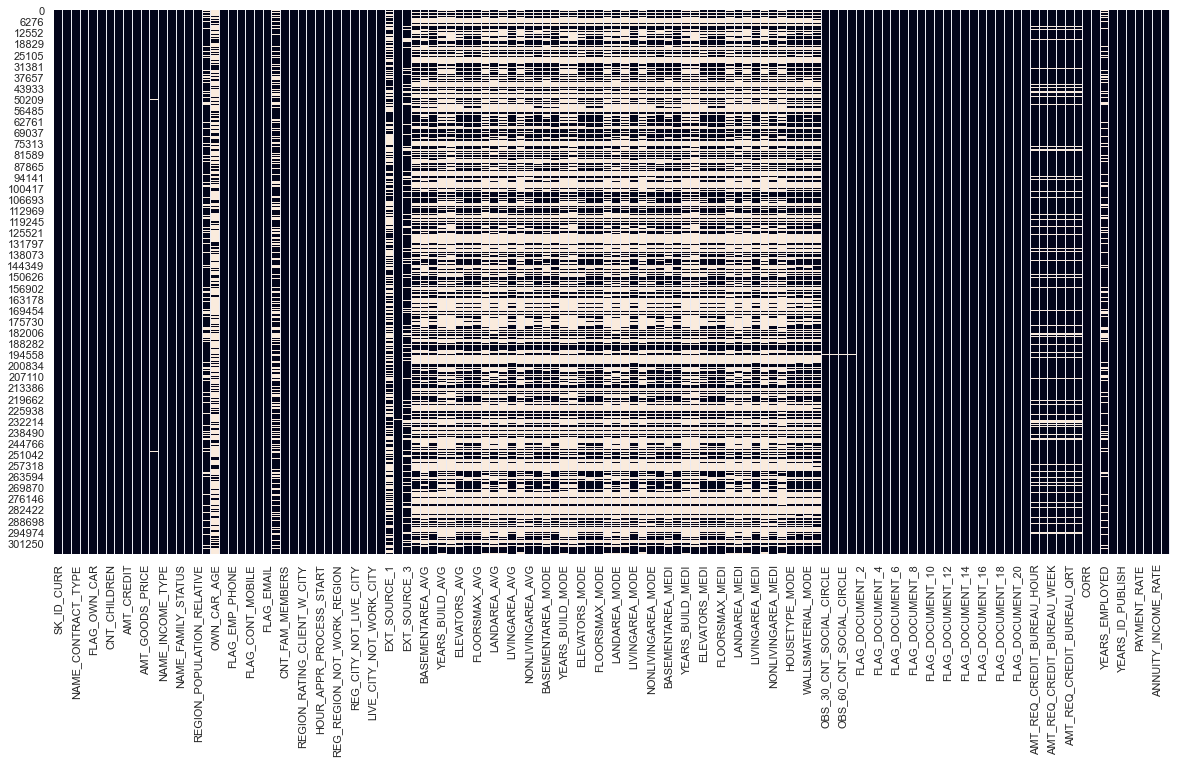

In [221]:
#plt.figure(figsize=(20,10))
#sns.heatmap(application_train.isnull(), cbar=False);
#plt.show()

### NAME_CONTRACT_TYPE
Identification si le prêt est en espèces ou renouvelable

--------------------------
-- NAME_CONTRACT_TYPE   --
--------------------------
0 valeurs manquantes
---------------------------
-3.09% de corrélation entre NAME_CONTRACT_TYPE et TARGET
---------------------------


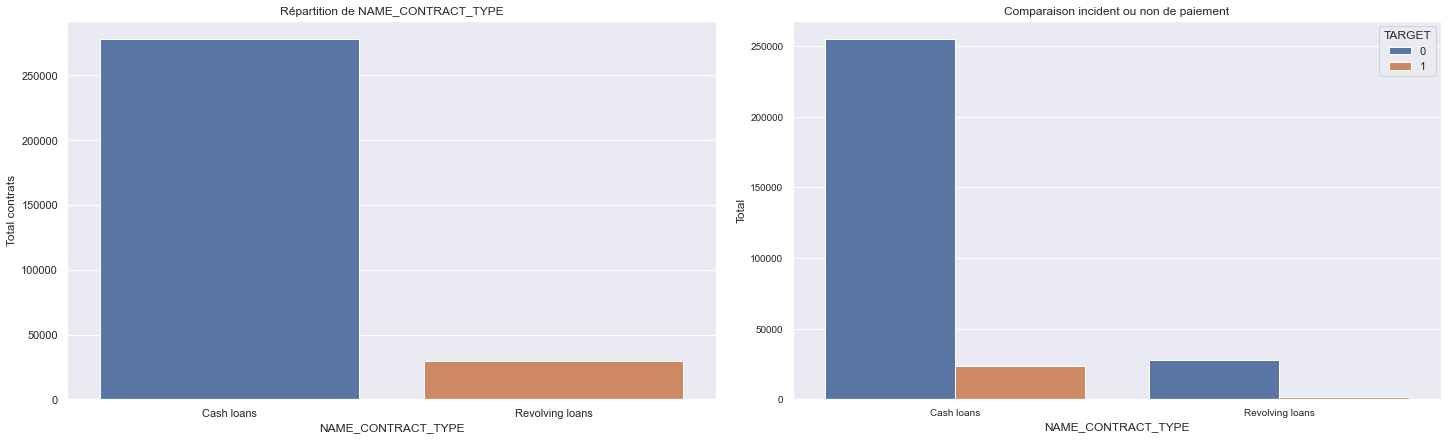

In [17]:
categorical_info(application_train,'NAME_CONTRACT_TYPE')

In [18]:
percent = (len(application_train[application_train['NAME_CONTRACT_TYPE'] == 'Revolving loans']) / application_train.shape[0]) * 100
print(f"{percent:.2f}% de crédits renouvelables")

revol_count = len(application_train[application_train['NAME_CONTRACT_TYPE'] == 'Revolving loans'])
revol_not = len(application_train[(application_train['NAME_CONTRACT_TYPE'] == 'Revolving loans') & (application_train['TARGET'] == 1)]) 

percent = (revol_not / revol_count) * 100
print(f"{percent:.2f}% des crédits renouvelables ne sont pas remboursés")


loan_count = len(application_train[application_train['NAME_CONTRACT_TYPE'] == 'Cash loans'])
loan_not = len(application_train[(application_train['NAME_CONTRACT_TYPE'] == 'Cash loans') & (application_train['TARGET'] == 1)]) 

percent = (loan_not / loan_count) * 100
print(f"{percent:.2f}% des crédits ne sont pas remboursés")

9.52% de crédits renouvelables
5.48% des crédits renouvelables ne sont pas remboursés
8.35% des crédits ne sont pas remboursés


Les prêts renouvelables ne représentent qu'une petite fraction (9.5%) du nombre total de prêts, cependant 5% de ceux-ci ne sont pas remboursés. 

### CODE_GENDER
Genre du client

--------------------------
-- CODE_GENDER          --
--------------------------
0 valeurs manquantes
---------------------------
5.47% de corrélation entre CODE_GENDER et TARGET
---------------------------


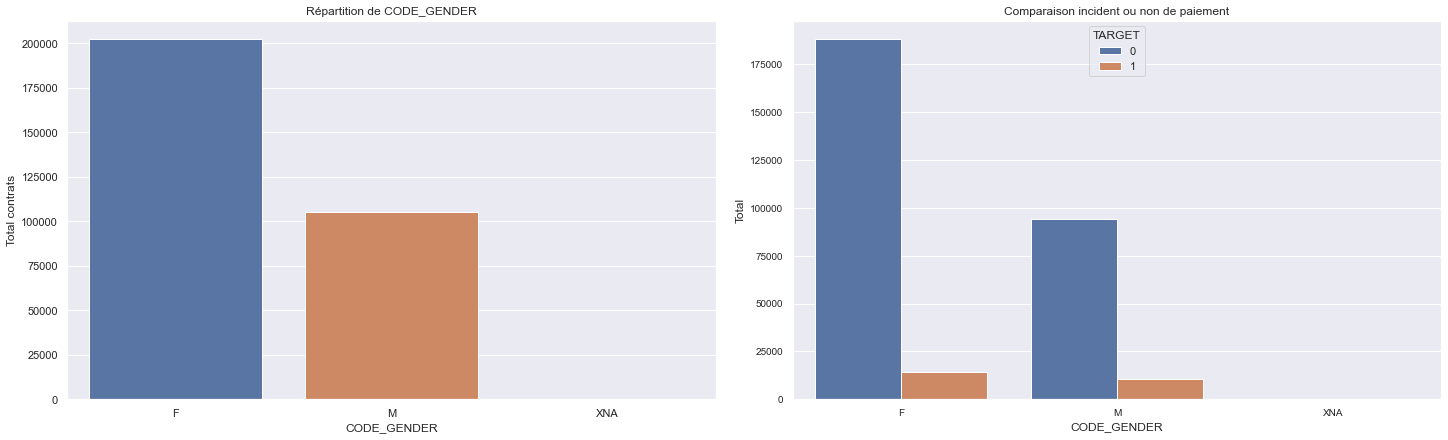

In [19]:
categorical_info(application_train,'CODE_GENDER')

In [20]:
percent = (len(application_train[application_train['CODE_GENDER'] == 'F']) / application_train.shape[0]) * 100
print(f"{percent:.2f}% de femmes contractent un crédit")

man_count = len(application_train[application_train['CODE_GENDER'] == 'M'])
man_not = len(application_train[(application_train['CODE_GENDER'] == 'M') & (application_train['TARGET'] == 1)]) 

woman_count = len(application_train[application_train['CODE_GENDER'] == 'F'])
woman_not = len(application_train[(application_train['CODE_GENDER'] == 'F') & (application_train['TARGET'] == 1)]) 

percent = (man_not / man_count) * 100
print(f"{percent:.2f}% des hommes ne remboursent pas leur crédit")

percent = (woman_not / woman_count) * 100
print(f"{percent:.2f}% des femmes ne remboursent pas leur crédit")

print(f"{len(application_train[application_train['CODE_GENDER'] == 'XNA'])} personnes identifiées avec un genre XNA")
print(f"{len(application_train[(application_train['CODE_GENDER'] == 'XNA') & (application_train['TARGET'] == 0)])} genre XNA qui rembourse")


65.83% de femmes contractent un crédit
10.14% des hommes ne remboursent pas leur crédit
7.00% des femmes ne remboursent pas leur crédit
4 personnes identifiées avec un genre XNA
4 genre XNA qui rembourse


Il a plus de femmes (66%) qui contracte un crédit, mais les hommes (10%) on plus tendance à ne pas rembourser leur crédit. Il existe dans le jeu de données un genre **XNA** (4) qui n'a pas été identifié, mais qui rembourse ses crédits. 

### FLAG_OWN_CAR
Signale si le client possède une voiture

--------------------------
-- FLAG_OWN_CAR         --
--------------------------
0 valeurs manquantes
---------------------------
-2.19% de corrélation entre FLAG_OWN_CAR et TARGET
---------------------------


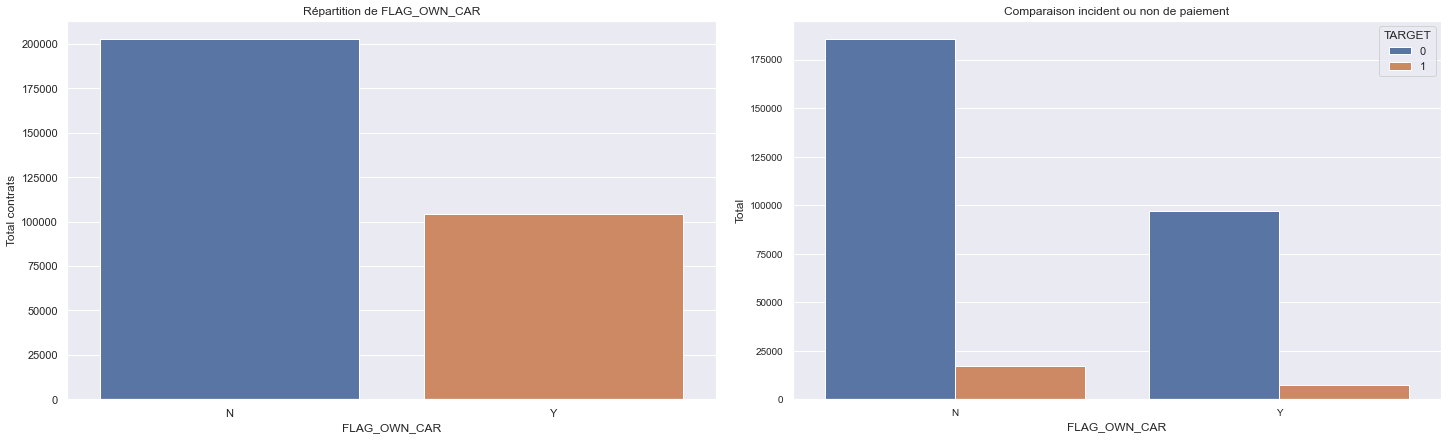

In [21]:
categorical_info(application_train,'FLAG_OWN_CAR')

In [22]:
print(f"{application_train['FLAG_OWN_CAR'].isna().sum()} valeurs manquantes")

percent = (len(application_train[application_train['FLAG_OWN_CAR'] == 'N']) / application_train.shape[0]) * 100
print(f"{percent:.2f}% ne possèdent pas de voiture")

p_count = len(application_train[application_train['FLAG_OWN_CAR'] == 'N'])
p_not = len(application_train[(application_train['FLAG_OWN_CAR'] == 'N') & (application_train['TARGET'] == 1)]) 

percent = (p_not / p_count) * 100
print(f"{percent:.2f}% des clients ne possédant pas leur voiture ne remboursent pas leur crédit")

0 valeurs manquantes
65.99% ne possèdent pas de voiture
8.50% des clients ne possédant pas leur voiture ne remboursent pas leur crédit


Une majorité de client ne possède pas de voiture (66%) et sont 8% à ne pas rembourser. Ceux qui possèdent une voiture ont tendance à rembourder leur prêt.

## FLAG_OWN_REALTY
Signale si le client est propriétaire d'une maison ou d'un appartement

--------------------------
-- FLAG_OWN_REALTY      --
--------------------------
0 valeurs manquantes
---------------------------
-0.61% de corrélation entre FLAG_OWN_REALTY et TARGET
---------------------------


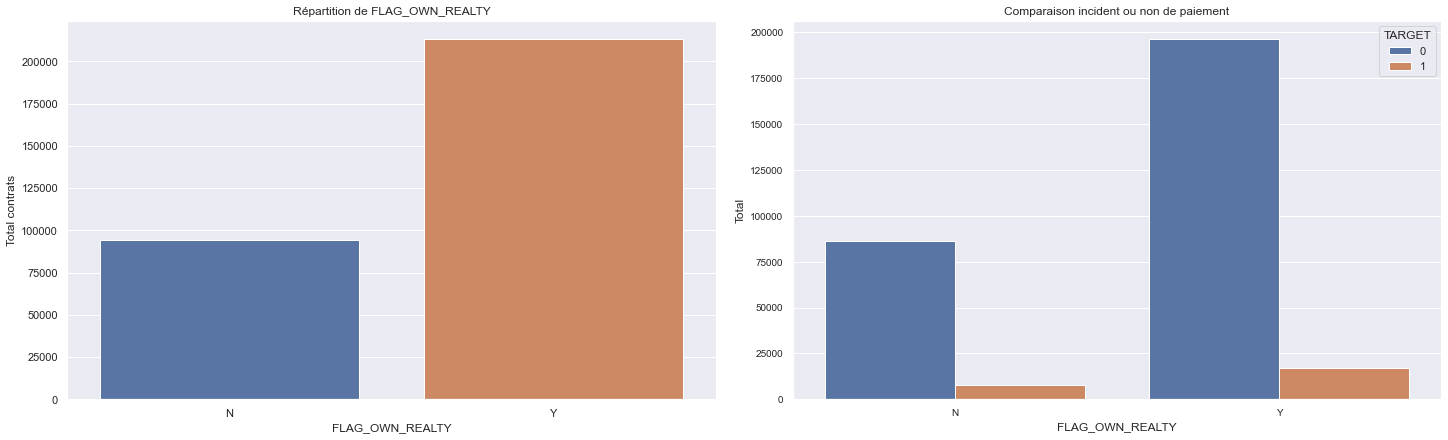

In [23]:
categorical_info(application_train,'FLAG_OWN_REALTY')

In [24]:
print(f"{application_train['FLAG_OWN_REALTY'].isna().sum()} valeurs manquantes")

percent = (len(application_train[application_train['FLAG_OWN_REALTY'] == 'Y']) / application_train.shape[0]) * 100
print(f"{percent:.2f}% possèdent une maison ou un appartement")

p_count = len(application_train[application_train['FLAG_OWN_REALTY'] == 'N'])
p_not = len(application_train[(application_train['FLAG_OWN_REALTY'] == 'N') & (application_train['TARGET'] == 1)]) 

percent = (p_not / p_count) * 100
print(f"{percent:.2f}% des clients ne possédant pas de maison ou d'appartement ne remboursent pas leur crédit")

0 valeurs manquantes
69.37% possèdent une maison ou un appartement
8.32% des clients ne possédant pas de maison ou d'appartement ne remboursent pas leur crédit


La plus part des clients (63%) ont une maison ou un appartement, cependant ceux qui ne possèdent pas de maison ou d'appartement ont tendance à ne pas rembourser leur prêt (8%).

### NAME_TYPE_SUITE
Qui accompagnait le client lorsqu'il a demandé le prêt

--------------------------
-- NAME_TYPE_SUITE      --
--------------------------
1292 valeurs manquantes
---------------------------
0.97% de corrélation entre NAME_TYPE_SUITE et TARGET
---------------------------


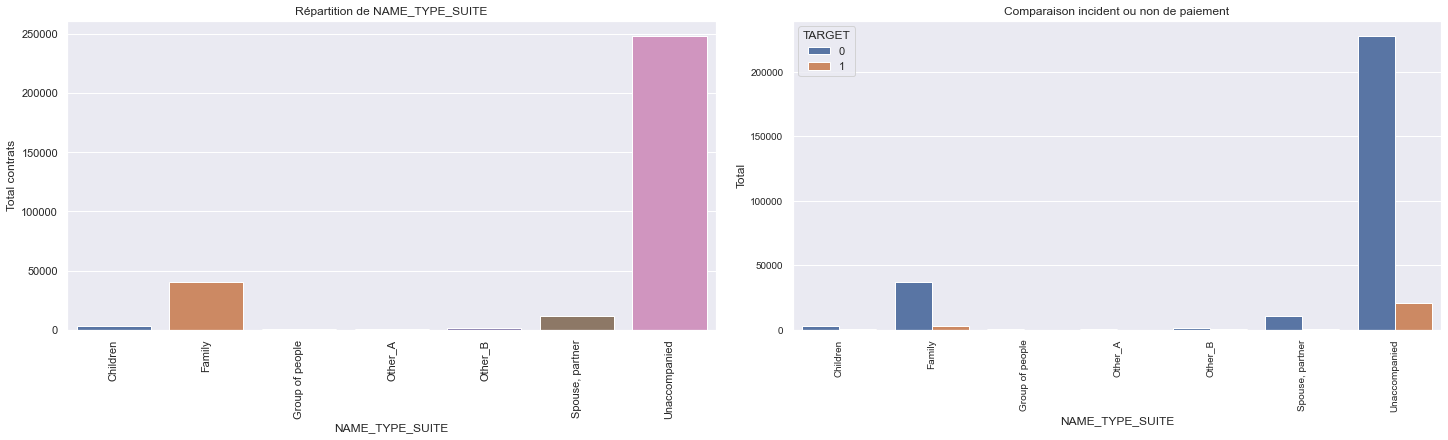

In [25]:
categorical_info(application_train,'NAME_TYPE_SUITE',label_rotation=90)

In [26]:
print(f"{application_train['NAME_TYPE_SUITE'].isna().sum()} valeurs manquantes")

percent = (len(application_train[application_train['NAME_TYPE_SUITE'] == 'Unaccompanied']) / application_train.shape[0]) * 100
print(f"{percent:.2f}% viennent seul")

print("Pourcentage de non paiement en fonction de l'accompagnant")
percent = application_train[['NAME_TYPE_SUITE', 'TARGET']].groupby(['NAME_TYPE_SUITE'],as_index=False).mean()
percent['TARGET'] = percent['TARGET']  * 100 
display(percent)


1292 valeurs manquantes
80.82% viennent seul
Pourcentage de non paiement en fonction de l'accompagnant


NAME_TYPE_SUITE  TARGET
0         Children   7.377
1           Family   7.495
2  Group of people   8.487
3          Other_A   8.776
4          Other_B   9.831
5  Spouse, partner   7.872
6    Unaccompanied   8.183

Un grand nombre de clients (80%) viennent seul pour contracter un crédit.
Les clients qui viennent avec des enfants ont un fort risque de non remboursement (7%) par rapport à leur nombre.

### NAME_INCOME_TYPE
Type de revenu du client (homme d'affaires, travail, congé de maternité)

--------------------------
-- NAME_INCOME_TYPE     --
--------------------------
0 valeurs manquantes
---------------------------
4.68% de corrélation entre NAME_INCOME_TYPE et TARGET
---------------------------


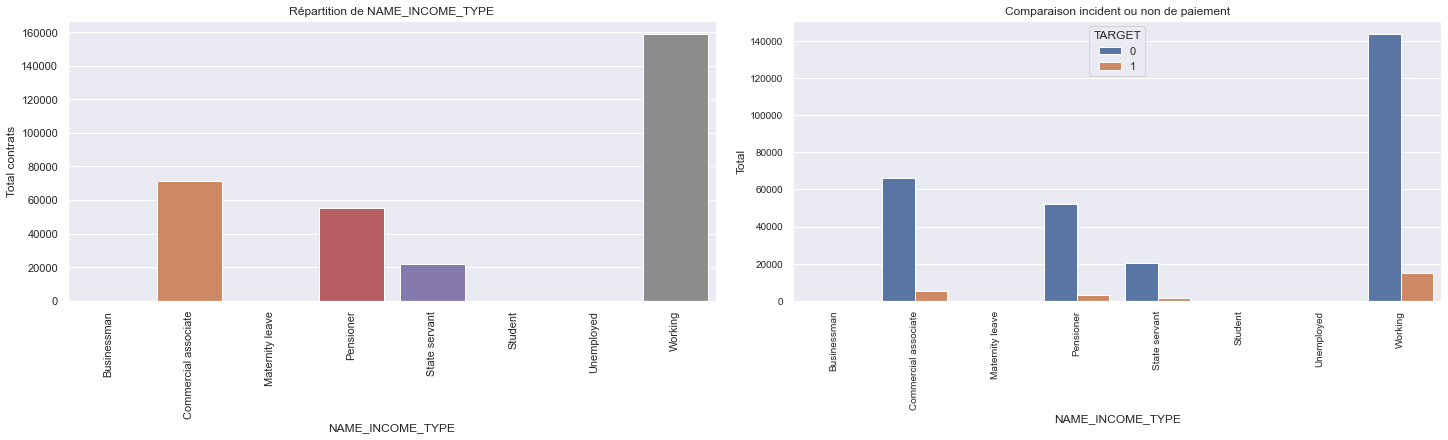

In [27]:
categorical_info(application_train,'NAME_INCOME_TYPE',label_rotation=90)

In [28]:
percent = (len(application_train[application_train['NAME_INCOME_TYPE'] == 'Working']) / application_train.shape[0]) * 100
print(f"{percent:.2f}% de travailleur")

print("Pourcentage de non paiement en fonction des revenus")
percent = application_train[['NAME_INCOME_TYPE', 'TARGET']].groupby(['NAME_INCOME_TYPE'],as_index=False).mean()
percent['TARGET'] = percent['TARGET']  * 100 
display(percent)

51.63% de travailleur
Pourcentage de non paiement en fonction des revenus


NAME_INCOME_TYPE  TARGET
0           Businessman   0.000
1  Commercial associate   7.484
2       Maternity leave  40.000
3             Pensioner   5.386
4         State servant   5.755
5               Student   0.000
6            Unemployed  36.364
7               Working   9.588

Une grande majorité de personne qui contracte un crédit sont des travailleurs, on remarquera que les femmes sortant de la maternité (40%) et les personnes au chomage (36%) on tendance à ne pas rembourder leur crédit. 

### NAME_EDUCATION_TYPE
Niveau d'éducation le plus élevé atteint par le client

--------------------------
-- NAME_EDUCATION_TYPE  --
--------------------------
0 valeurs manquantes
---------------------------
5.47% de corrélation entre NAME_EDUCATION_TYPE et TARGET
---------------------------


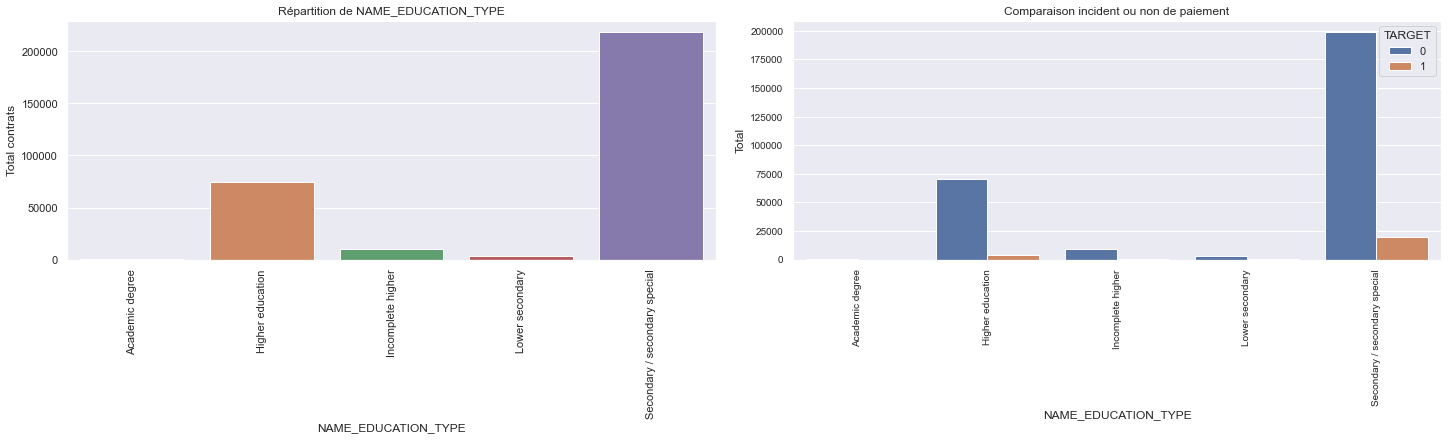

In [29]:
categorical_info(application_train,'NAME_EDUCATION_TYPE',label_rotation=90)

In [30]:
print(f"{application_train['NAME_EDUCATION_TYPE'].isna().sum()} valeurs manquantes")

percent = (len(application_train[application_train['NAME_EDUCATION_TYPE'] == 'Lower secondary']) / application_train.shape[0]) * 100
print(f"{percent:.2f}% de niveau d'étude en dessous du secondaire")

print("Pourcentage de non paiement du niveau d'éducation")
percent = application_train[['NAME_EDUCATION_TYPE', 'TARGET']].groupby(['NAME_EDUCATION_TYPE'],as_index=False).mean()
percent['TARGET'] = percent['TARGET']  * 100 
display(percent)

0 valeurs manquantes
1.24% de niveau d'étude en dessous du secondaire
Pourcentage de non paiement du niveau d'éducation


NAME_EDUCATION_TYPE  TARGET
0                Academic degree   1.829
1               Higher education   5.355
2              Incomplete higher   8.485
3                Lower secondary  10.928
4  Secondary / secondary special   8.940

Les clients ayant un niveau d'éducation égal aux études secondaire sont plus suceptibles de contracter un crédit, ils sont les plus suceptible de rembourser leur crédit.


### NAME_FAMILY_STATUS
Situation familiale du client

--------------------------
-- NAME_FAMILY_STATUS   --
--------------------------
0 valeurs manquantes
---------------------------
-0.41% de corrélation entre NAME_FAMILY_STATUS et TARGET
---------------------------


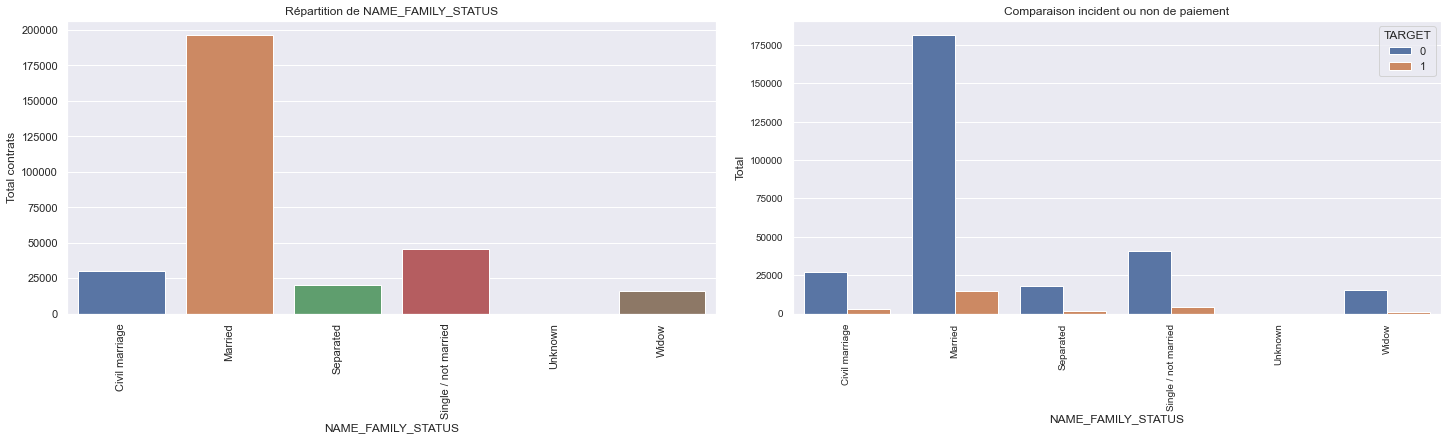

In [31]:
categorical_info(application_train,'NAME_FAMILY_STATUS',label_rotation=90)

In [32]:
print(f"{application_train['NAME_FAMILY_STATUS'].isna().sum()} valeurs manquantes")

percent = (len(application_train[application_train['NAME_FAMILY_STATUS'] == 'Civil marriage']) / application_train.shape[0]) * 100
print(f"{percent:.2f}% de personnes ayant fait mariage civil prennent un crédit")

print("Pourcentage de non paiement en fonction  du status familial")
percent = application_train[['NAME_FAMILY_STATUS', 'TARGET']].groupby(['NAME_FAMILY_STATUS'],as_index=False).mean()
percent['TARGET'] = percent['TARGET']  * 100 
display(percent)

0 valeurs manquantes
9.68% de personnes ayant fait mariage civil prennent un crédit
Pourcentage de non paiement en fonction  du status familial


NAME_FAMILY_STATUS  TARGET
0        Civil marriage   9.945
1               Married   7.560
2             Separated   8.194
3  Single / not married   9.808
4               Unknown   0.000
5                 Widow   5.824

Les clients mariés sont plus suceptibles de contracter un crédit et sont suceptiblent de ne pas rembourser leur crédit dans 7% des cas. Les clients célibataires (10%) ou marié civilement (10%) ont de fortes probabibiltés de faire défaut au paiement du crédit.

### NAME_HOUSING_TYPE
Quelle est la situation du client en matière de logement (location. vie avec les parents. ...)

--------------------------
-- NAME_HOUSING_TYPE    --
--------------------------
0 valeurs manquantes
---------------------------
3.45% de corrélation entre NAME_HOUSING_TYPE et TARGET
---------------------------


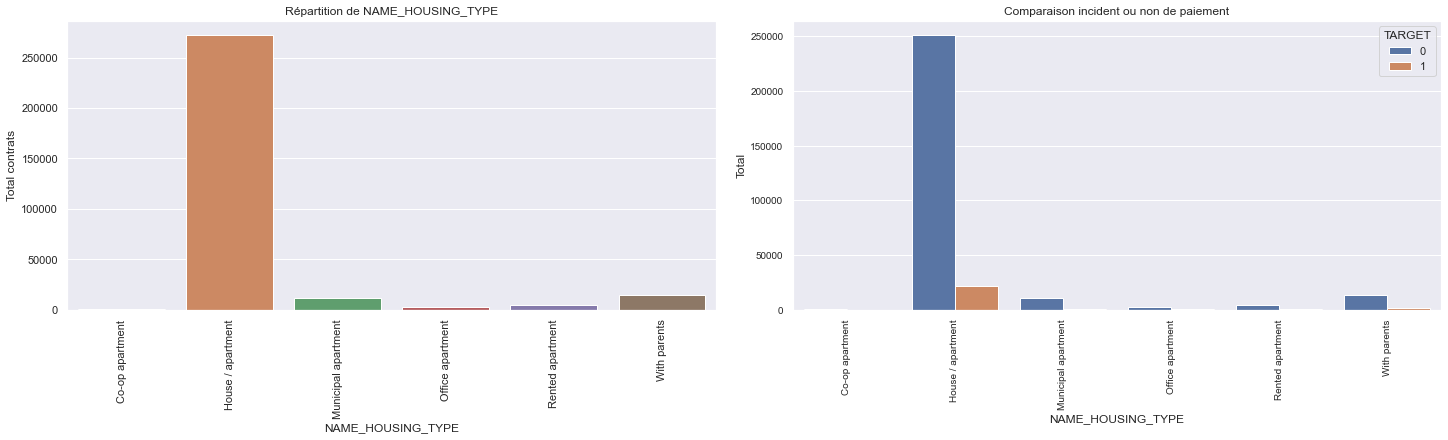

In [33]:
categorical_info(application_train,'NAME_HOUSING_TYPE',label_rotation=90)

In [34]:
print(f"{application_train['NAME_HOUSING_TYPE'].isna().sum()} valeurs manquantes")

percent = (len(application_train[application_train['NAME_HOUSING_TYPE'] == 'House / apartment']) / application_train.shape[0]) * 100
print(f"{percent:.2f}% vivent dans une maison ou un appartement")

print("Pourcentage de non paiement")
percent = application_train[['NAME_HOUSING_TYPE', 'TARGET']].groupby(['NAME_HOUSING_TYPE'],as_index=False).mean()
percent['TARGET'] = percent['TARGET']  * 100 
display(percent)

0 valeurs manquantes
88.73% vivent dans une maison ou un appartement
Pourcentage de non paiement


NAME_HOUSING_TYPE  TARGET
0      Co-op apartment   7.932
1    House / apartment   7.796
2  Municipal apartment   8.540
3     Office apartment   6.572
4     Rented apartment  12.313
5         With parents  11.698

Les clients qui vivent dans une maison ou un appartement (88%) sont plus suceptibles de contracter un crédit.
Les locataires (12%) et ceux vivant chez leur parents (12%) seront plus enclain à ne pas rembourser leur crédit.

### OCCUPATION_TYPE
Quelle est la profession du client ?

--------------------------
-- OCCUPATION_TYPE      --
--------------------------
96391 valeurs manquantes
---------------------------
4.09% de corrélation entre OCCUPATION_TYPE et TARGET
---------------------------


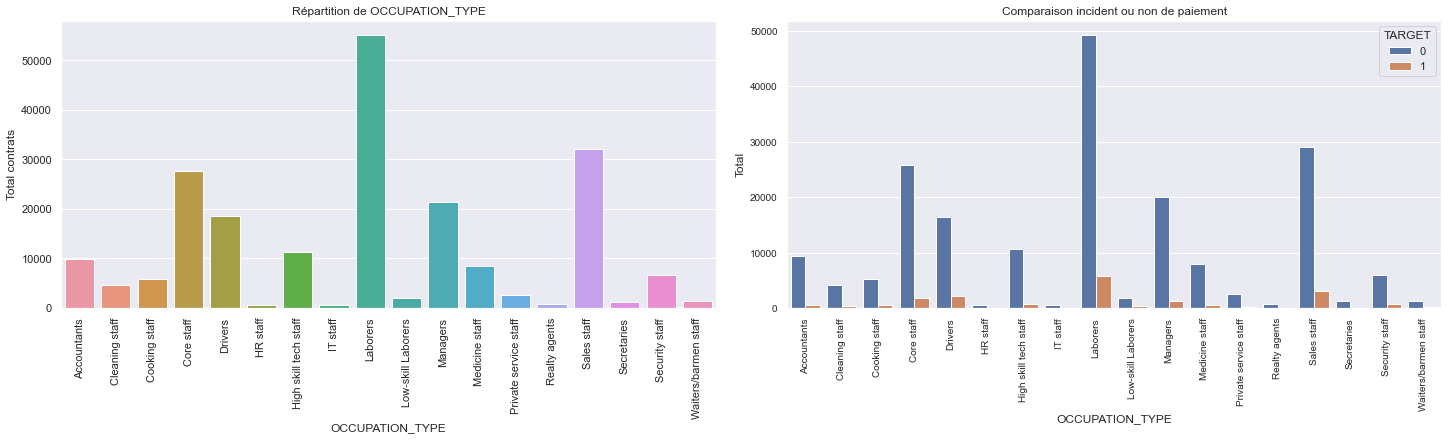

In [35]:
categorical_info(application_train,'OCCUPATION_TYPE',label_rotation=90)

In [36]:
print(f"{application_train['OCCUPATION_TYPE'].isna().sum()} valeurs manquantes")

percent = (len(application_train[application_train['OCCUPATION_TYPE'] == 'Laborers']) / application_train.shape[0]) * 100
print(f"{percent:.2f}% d'ouvriers")

print("Pourcentage de non paiement")
percent = application_train[['OCCUPATION_TYPE', 'TARGET']].groupby(['OCCUPATION_TYPE'],as_index=False).mean()
percent['TARGET'] = percent['TARGET']  * 100 
display(percent)

96391 valeurs manquantes
17.95% d'ouvriers
Pourcentage de non paiement


OCCUPATION_TYPE  TARGET
0             Accountants   4.830
1          Cleaning staff   9.607
2           Cooking staff  10.444
3              Core staff   6.304
4                 Drivers  11.326
5                HR staff   6.394
6   High skill tech staff   6.160
7                IT staff   6.464
8                Laborers  10.579
9      Low-skill Laborers  17.152
10               Managers   6.214
11         Medicine staff   6.700
12  Private service staff   6.599
13          Realty agents   7.856
14            Sales staff   9.632
15            Secretaries   7.050
16         Security staff  10.742
17   Waiters/barmen staff  11.276


La plupart des prêts sont contractés par les ouvriers (17%). Les client travaillant dans IT prennent peu de crédit. Les ouvriers non qualifiés (17%) sont les plus suceptible de ne pas rembourser leur prêt

### WEEKDAY_APPR_PROCESS_START
Quel jour de la semaine le client a-t-il demandé le prêt ?!

--------------------------
-- WEEKDAY_APPR_PROCESS_START --
--------------------------
0 valeurs manquantes
---------------------------
0.40% de corrélation entre WEEKDAY_APPR_PROCESS_START et TARGET
---------------------------


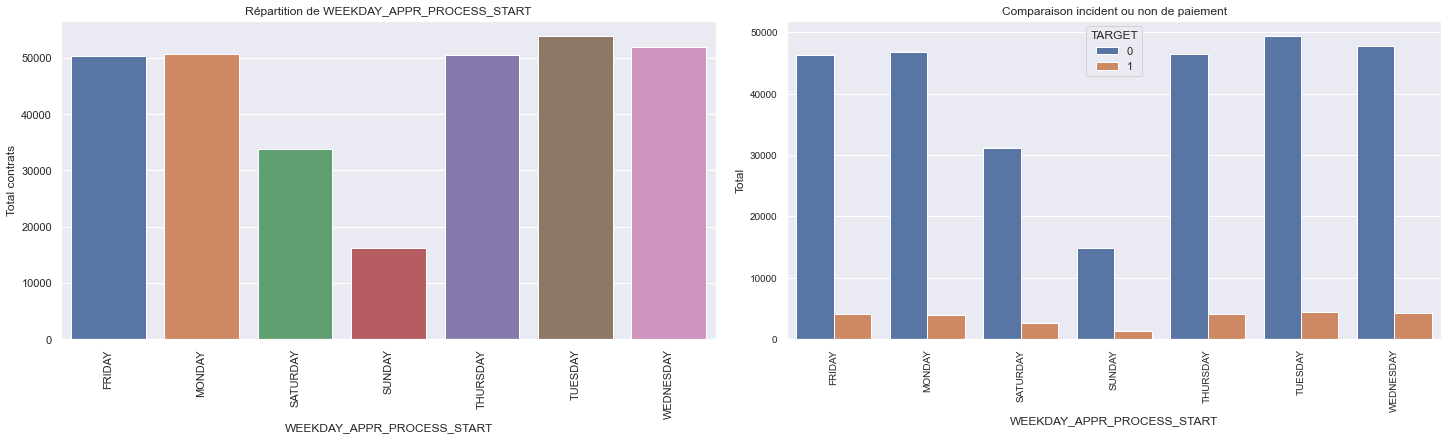

In [37]:
categorical_info(application_train,'WEEKDAY_APPR_PROCESS_START',label_rotation=90)


In [38]:
print(f"{application_train['WEEKDAY_APPR_PROCESS_START'].isna().sum()} valeurs manquantes")

percent = (len(application_train[application_train['WEEKDAY_APPR_PROCESS_START'] == 'TUESDAY']) / application_train.shape[0]) * 100
print(f"{percent:.2f}% de personnes font une demande de prêt le mardi")

print("Pourcentage de non paiement")
percent = application_train[['WEEKDAY_APPR_PROCESS_START', 'TARGET']].groupby(['WEEKDAY_APPR_PROCESS_START'],as_index=False).mean()
percent['TARGET'] = percent['TARGET']  * 100 
display(percent)

0 valeurs manquantes
17.53% de personnes font une demande de prêt le mardi
Pourcentage de non paiement


WEEKDAY_APPR_PROCESS_START  TARGET
0                     FRIDAY   8.147
1                     MONDAY   7.757
2                   SATURDAY   7.887
3                     SUNDAY   7.929
4                   THURSDAY   8.100
5                    TUESDAY   8.350
6                  WEDNESDAY   8.160

Le samedi et le dimanche sont les jours où il y a le moins de demande de crédit, cependant les crédits contractés à cette periodes sont majoritairement non remboursés.

### ORGANIZATION_TYPE
Type d'organisation où le client travaille!

--------------------------
-- ORGANIZATION_TYPE    --
--------------------------
0 valeurs manquantes
---------------------------
-3.08% de corrélation entre ORGANIZATION_TYPE et TARGET
---------------------------


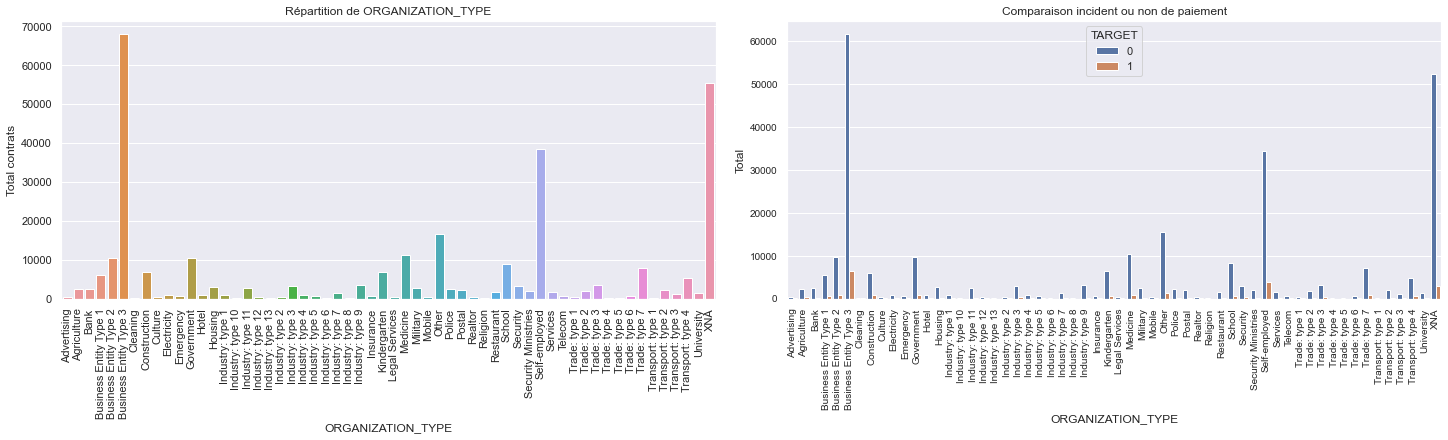

In [39]:
categorical_info(application_train,'ORGANIZATION_TYPE',label_rotation=90)

In [40]:
print(f"{application_train['ORGANIZATION_TYPE'].isna().sum()} valeurs manquantes")

percent = (len(application_train[application_train['ORGANIZATION_TYPE'] == 'Business Entity Type 3']) / application_train.shape[0]) * 100
print(f"{percent:.2f}% de personnes travaillent dans une entreprise de type 3")

print("Pourcentage de non paiement")
percent = application_train[['ORGANIZATION_TYPE', 'TARGET']].groupby(['ORGANIZATION_TYPE'],as_index=False).mean()
percent['TARGET'] = percent['TARGET']  * 100 
display(percent)

0 valeurs manquantes
22.11% de personnes travaillent dans une entreprise de type 3
Pourcentage de non paiement


ORGANIZATION_TYPE  TARGET
0              Advertising   8.159
1              Agriculture  10.473
2                     Bank   5.185
3   Business Entity Type 1   8.138
4   Business Entity Type 2   8.528
5   Business Entity Type 3   9.300
6                 Cleaning  11.154
7             Construction  11.680
8                  Culture   5.541
9              Electricity   6.632
10               Emergency   7.143
11              Government   6.978
12                   Hotel   6.418
13                 Housing   7.945
14        Industry: type 1  11.068
15       Industry: type 10   6.422
16       Industry: type 11   8.654
17       Industry: type 12   3.794
18       Industry: type 13  13.433
19        Industry: type 2   7.205
20        Industry: type 3  10.616
21        Industry: type 4  10.148
22        Industry: type 5   6.845
23        Industry: type 6   7.143
24        Industry: type 7   8.034
25        Industry: type 8  12.500
26        Industry: type 9   6.681
27               Insurance   5.695
28            Kindergarten   7.035
29          Legal Services   7.869
30                Medicine   6.584
31                Military   5.125
32                  Mobile   9.148
33                   Other   7.643
34                  Police   4.998
35                  Postal   8.438
36                 Realtor  10.606
37                Religion   5.882
38              Restaurant  11.706
39                  School   5.915
40                Security   9.978
41     Security Ministries   4.863
42           Self-employed  10.174
43                Services   6.603
44                 Telecom   7.626
45           Trade: type 1   8.908
46           Trade: type 2   7.000
47           Trade: type 3  10.338
48           Trade: type 4   3.125
49           Trade: type 5   6.122
50           Trade: type 6   4.596
51           Trade: type 7   9.450
52       Transport: type 1   4.478
53       Transport: type 2   7.804
54       Transport: type 3  15.754
55       Transport: type 4   9.281
56              University   4.898
57                     XNA   5.400

Les client travaillant dans le Transport Type 3 (16%) ou dans l'industrie (13%) sont les plus suceptible de ne pas rembourser leur crédit alors qu'ils représentent une faible propostion de demandeur.

### FONDKAPREMONT_MODE
Informations normalisées sur l'immeuble où vit le client. 

--------------------------
-- FONDKAPREMONT_MODE   --
--------------------------
210295 valeurs manquantes
---------------------------
-2.90% de corrélation entre FONDKAPREMONT_MODE et TARGET
---------------------------


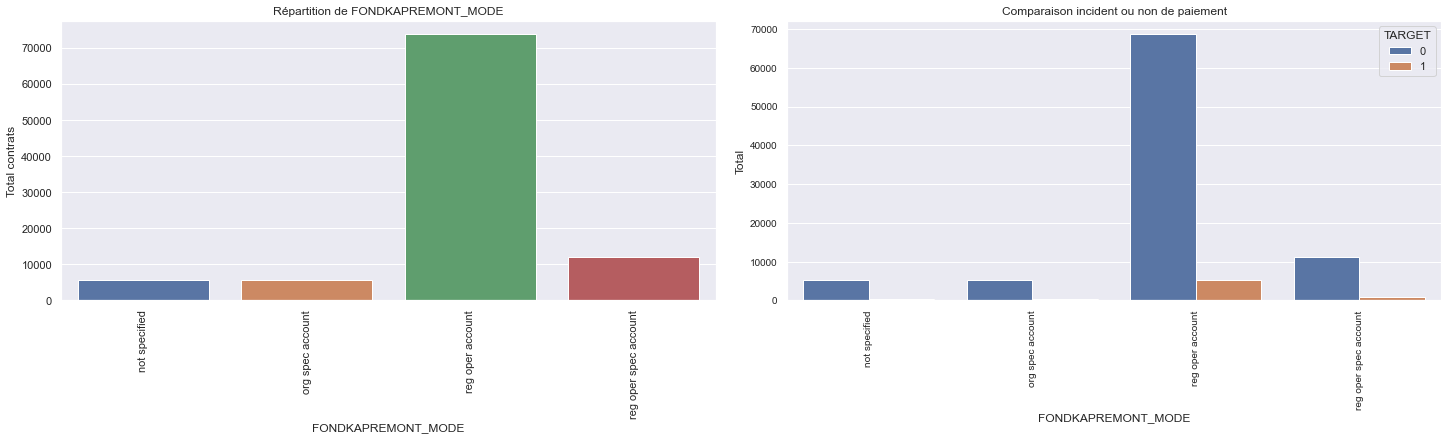

In [41]:
categorical_info(application_train,'FONDKAPREMONT_MODE',label_rotation=90)

In [42]:
print(f"{application_train['FONDKAPREMONT_MODE'].isna().sum()} valeurs manquantes")

percent = (len(application_train[application_train['FONDKAPREMONT_MODE'] == 'reg oper account']) / application_train.shape[0]) * 100
print(f"{percent:.2f}% de reg oper account")

print("Pourcentage de non paiement")
percent = application_train[['FONDKAPREMONT_MODE', 'TARGET']].groupby(['FONDKAPREMONT_MODE'],as_index=False).mean()
percent['TARGET'] = percent['TARGET']  * 100 
display(percent)

210295 valeurs manquantes
24.01% de reg oper account
Pourcentage de non paiement


FONDKAPREMONT_MODE  TARGET
0          not specified   7.544
1       org spec account   5.820
2       reg oper account   6.978
3  reg oper spec account   6.556

La réelle signification de cette variable est assez obscure, cependant on remarquera que les immeubles de type "not specified" ou "org spec account" ou vivent les clients sont plus enclain à ne pas rembourser leur prêt

### HOUSETYPE_MODE
Informations normalisées sur l'immeuble où vit le client. 


--------------------------
-- HOUSETYPE_MODE       --
--------------------------
154297 valeurs manquantes
---------------------------
-3.64% de corrélation entre HOUSETYPE_MODE et TARGET
---------------------------


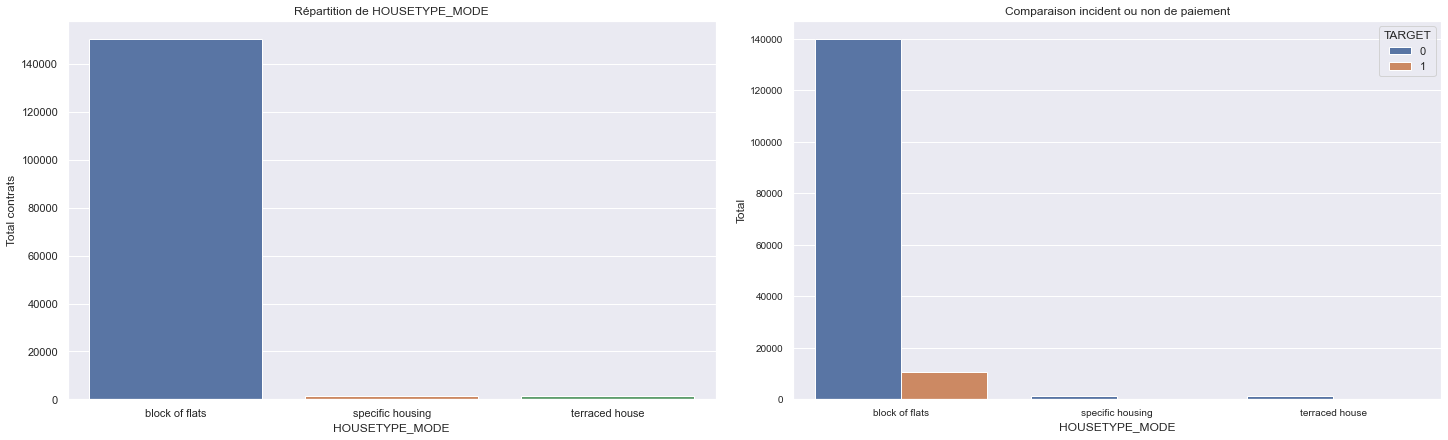

In [43]:
categorical_info(application_train,'HOUSETYPE_MODE',label_rotation=0)

In [44]:
print(f"{application_train['HOUSETYPE_MODE'].isna().sum()} valeurs manquantes")

percent = (len(application_train[application_train['HOUSETYPE_MODE'] == 'block of flats']) / application_train.shape[0]) * 100
print(f"{percent:.2f}% de type d'habitation")

print("Pourcentage de non paiement")
percent = application_train[['HOUSETYPE_MODE', 'TARGET']].groupby(['HOUSETYPE_MODE'],as_index=False).mean()
percent['TARGET'] = percent['TARGET']  * 100 
display(percent)


154297 valeurs manquantes
48.94% de type d'habitation
Pourcentage de non paiement


HOUSETYPE_MODE  TARGET
0    block of flats   6.943
1  specific housing  10.140
2    terraced house   8.498

Le type d'habitation "specific housing" et "terraced house" ont tendance à ne pas rembourser leur crédit alors que c'est le plus petit nombre de client qui contracte un crédit

### WALLSMATERIAL_MODE
Informations normalisées sur l'immeuble où vit le client. 

--------------------------
-- WALLSMATERIAL_MODE   --
--------------------------
156341 valeurs manquantes
---------------------------
-3.46% de corrélation entre WALLSMATERIAL_MODE et TARGET
---------------------------


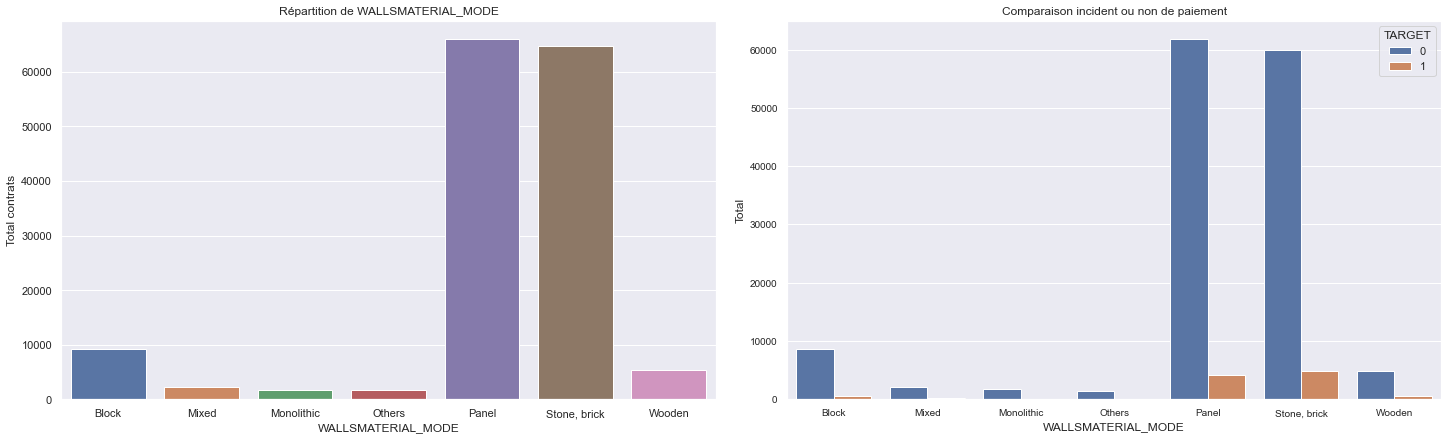

In [45]:
categorical_info(application_train,'WALLSMATERIAL_MODE',label_rotation=0)

In [46]:
print(f"{application_train['WALLSMATERIAL_MODE'].isna().sum()} valeurs manquantes")

percent = (len(application_train[application_train['WALLSMATERIAL_MODE'] == 'Panel']) / application_train.shape[0]) * 100
print(f"{percent:.2f}% de murs en panneau")

percent = (len(application_train[application_train['WALLSMATERIAL_MODE'] == 'Stone, brick']) / application_train.shape[0]) * 100
print(f"{percent:.2f}% de mus en pierre ou en brique")


print("Pourcentage de non paiement")
percent = application_train[['WALLSMATERIAL_MODE', 'TARGET']].groupby(['WALLSMATERIAL_MODE'],as_index=False).mean()
percent['TARGET'] = percent['TARGET']  * 100 
display(percent)

156341 valeurs manquantes
21.48% de murs en panneau
21.08% de mus en pierre ou en brique
Pourcentage de non paiement


WALLSMATERIAL_MODE  TARGET
0              Block   7.025
1              Mixed   7.535
2         Monolithic   4.722
3             Others   8.308
4              Panel   6.348
5       Stone, brick   7.406
6             Wooden   9.698

Les clients qui habitent principalement dans un logement en pierre (21%) ou en panneau (21%) contractent des crédits et ne font défaut que dans respectivement 7% et 6% des cas.
Ceux qui habitent dans des maison en bois ont 10% de chance de faire défaut.

### EMERGENCYSTATE_MODE

Informations normalisées sur l'immeuble où vit le client. 


--------------------------
-- EMERGENCYSTATE_MODE  --
--------------------------
145755 valeurs manquantes
---------------------------
-3.94% de corrélation entre EMERGENCYSTATE_MODE et TARGET
---------------------------


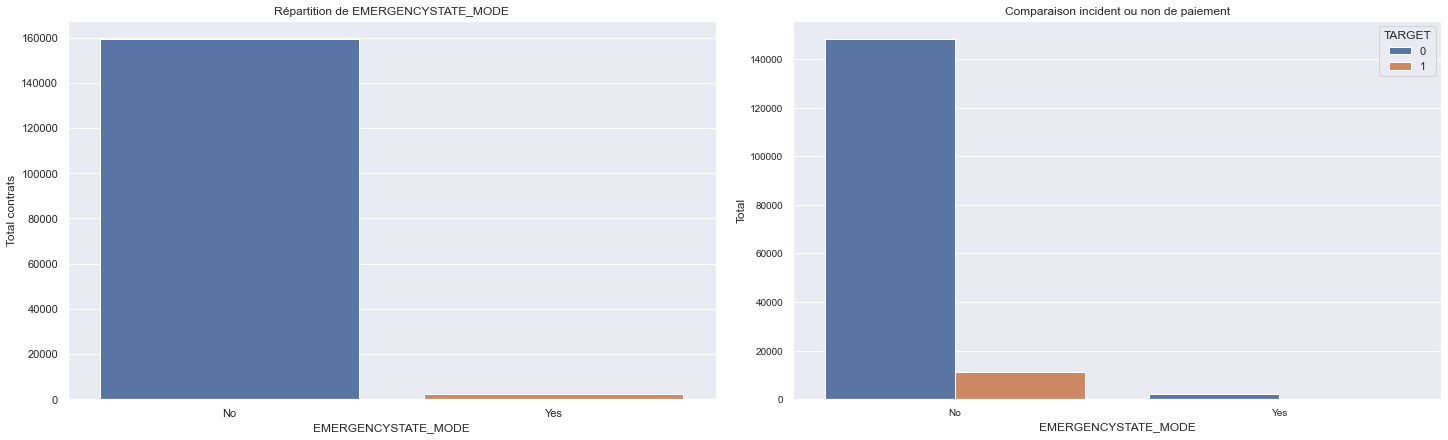

In [47]:
categorical_info(application_train,'EMERGENCYSTATE_MODE',label_rotation=0)

In [48]:
print(f"{application_train['EMERGENCYSTATE_MODE'].isna().sum()} valeurs manquantes")

percent = (len(application_train[application_train['EMERGENCYSTATE_MODE'] == 'No']) / application_train.shape[0]) * 100
print(f"{percent:.2f}% ne possèdent pas de système d'urgence")

p_count = len(application_train[application_train['EMERGENCYSTATE_MODE'] == 'Yes'])
p_not = len(application_train[(application_train['EMERGENCYSTATE_MODE'] == 'Yes') & (application_train['TARGET'] == 1)]) 

percent = (p_not / p_count) * 100
print(f"{percent:.2f}% des clients possédant un système d'urgence ne remboursent pas leur crédit")

145755 valeurs manquantes
51.84% ne possèdent pas de système d'urgence
9.58% des clients possédant un système d'urgence ne remboursent pas leur crédit


Une majorité de client n'ont pas de système d'urgence (52%) et ceux n'en ayant pas ne remboursent pas dans 10% des cas.

### FLAG_MOBIL
Le client a-t-il fourni un téléphone portable (1=Oui. 0=Non)


--------------------------
-- FLAG_MOBIL           --
--------------------------
0 valeurs manquantes
---------------------------
0.05% de corrélation entre FLAG_MOBIL et TARGET
---------------------------


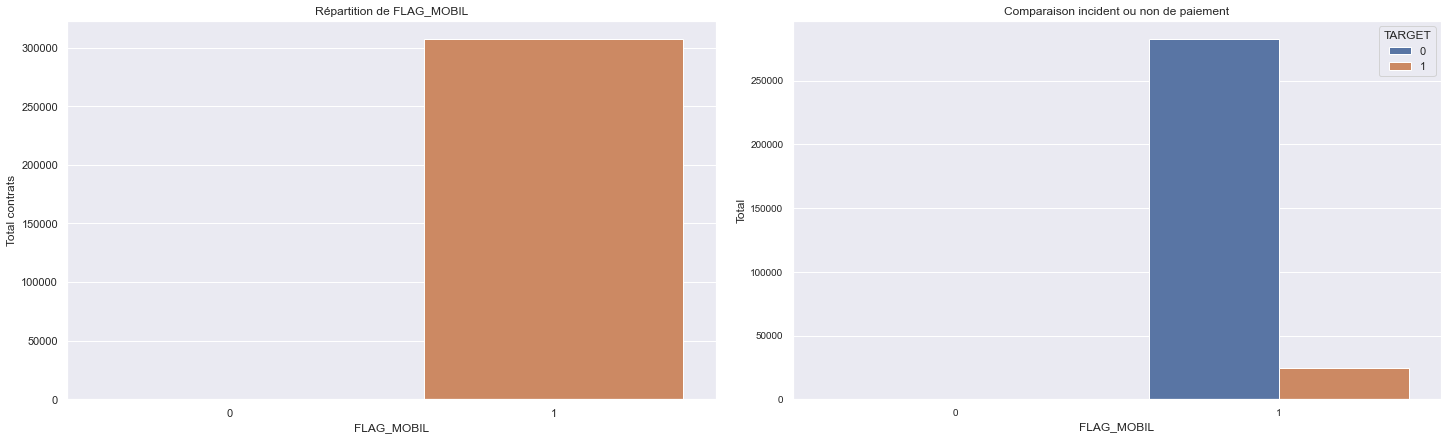

In [49]:
categorical_info(application_train,'FLAG_MOBIL')

In [50]:
print(f"{application_train['FLAG_MOBIL'].isna().sum()} valeurs manquantes")

percent = (len(application_train[application_train['FLAG_MOBIL'] == 1]) / application_train.shape[0]) * 100
print(f"{percent:.2f}% des clients ont fourni un téléphone mobile")

0 valeurs manquantes
100.00% des clients ont fourni un téléphone mobile


Cette données étant la même dans tout le jeu de données elle pourra être supprimée.

### FLAG_EMP_PHONE
Le client a-t-il fourni le numéro de téléphone de l'entreprise (1=OUI 0=NON)

--------------------------
-- FLAG_EMP_PHONE       --
--------------------------
0 valeurs manquantes
---------------------------
4.60% de corrélation entre FLAG_EMP_PHONE et TARGET
---------------------------


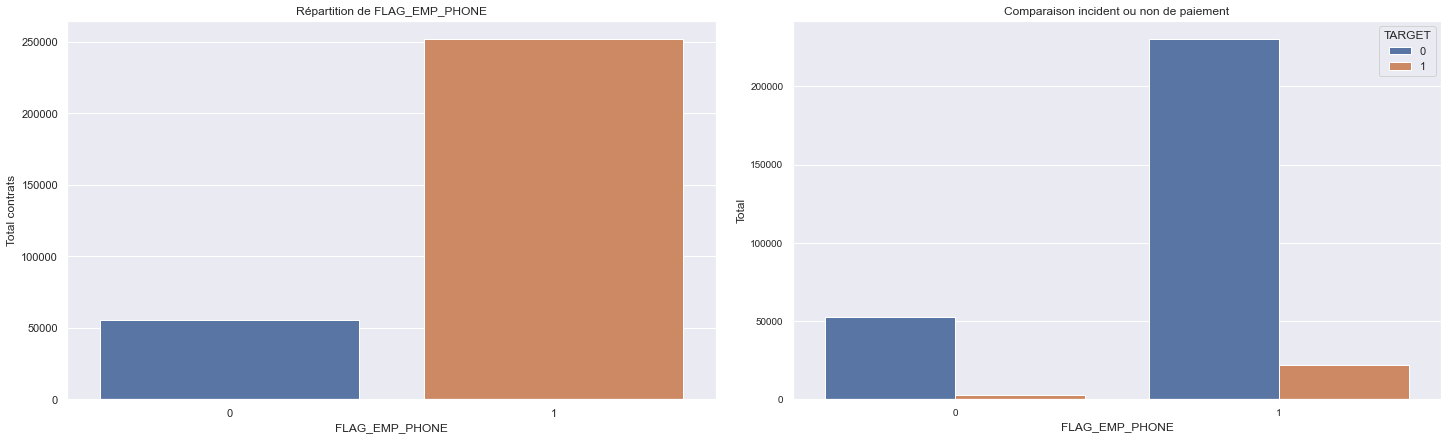

In [51]:
categorical_info(application_train,'FLAG_EMP_PHONE')


In [52]:
print(f"{application_train['FLAG_EMP_PHONE'].isna().sum()} valeurs manquantes")

percent = (len(application_train[application_train['FLAG_EMP_PHONE'] == 0]) / application_train.shape[0]) * 100
print(f"{percent:.2f}% n'ont pas fourni le numéro de téléphone de l'entreprise")

p_count = len(application_train[application_train['FLAG_EMP_PHONE'] == 0])
p_not = len(application_train[(application_train['FLAG_EMP_PHONE'] == 0) & (application_train['TARGET'] == 1)]) 

percent = (p_not / p_count) * 100
print(f"{percent:.2f}% des clients n'ayant pas fourni le numéro de téléphone de l'entreprise ne remboursent pas leur crédit")




0 valeurs manquantes
18.01% n'ont pas fourni le numéro de téléphone de l'entreprise
5.40% des clients n'ayant pas fourni le numéro de téléphone de l'entreprise ne remboursent pas leur crédit


### FLAG_WORK_PHONE
Le client a-t-il fourni un téléphone professionnel (1=Oui 0=Non)


--------------------------
-- FLAG_WORK_PHONE      --
--------------------------
0 valeurs manquantes
---------------------------
2.85% de corrélation entre FLAG_WORK_PHONE et TARGET
---------------------------


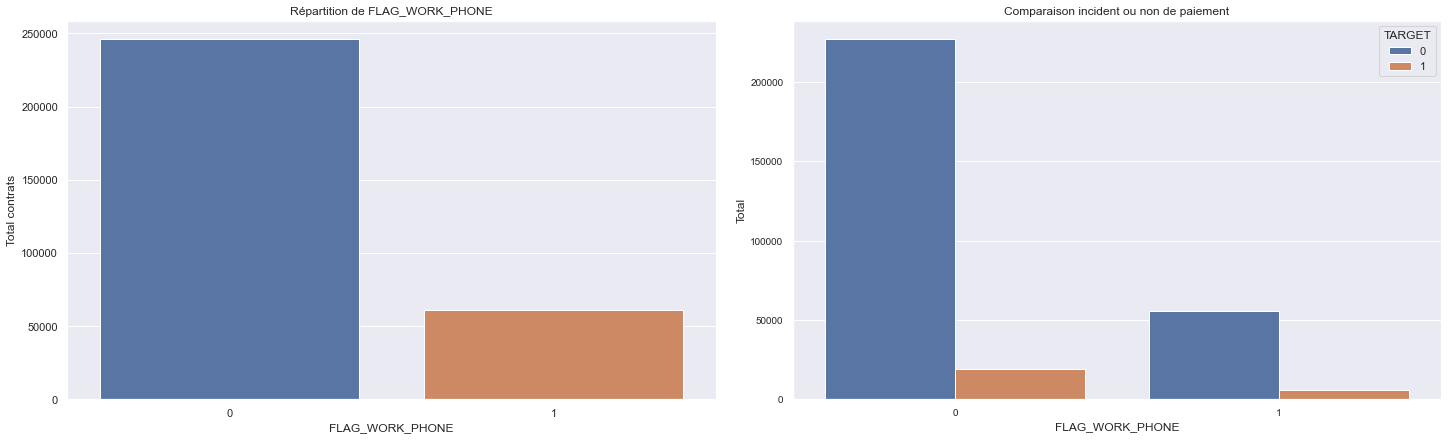

In [53]:
categorical_info(application_train,'FLAG_WORK_PHONE')

In [54]:
print(f"{application_train['FLAG_WORK_PHONE'].isna().sum()} valeurs manquantes")

percent = (len(application_train[application_train['FLAG_WORK_PHONE'] == 1]) / application_train.shape[0]) * 100
print(f"{percent:.2f}% ont un n° de téléphone professionnel")

p_count = len(application_train[application_train['FLAG_WORK_PHONE'] == 1])
p_not = len(application_train[(application_train['FLAG_WORK_PHONE'] == 1) & (application_train['TARGET'] == 1)]) 

percent = (p_not / p_count) * 100
print(f"{percent:.2f}% des clients possédant un n° de téléphone professionnel ne remboursent pas leur crédit")

0 valeurs manquantes
19.94% ont un n° de téléphone professionnel
9.63% des clients possédant un n° de téléphone professionnel ne remboursent pas leur crédit


### FLAG_CONT_MOBILE
Le téléphone portable était-il joignable (1=Oui 0=Non)


--------------------------
-- FLAG_CONT_MOBILE     --
--------------------------
0 valeurs manquantes
---------------------------
0.04% de corrélation entre FLAG_CONT_MOBILE et TARGET
---------------------------


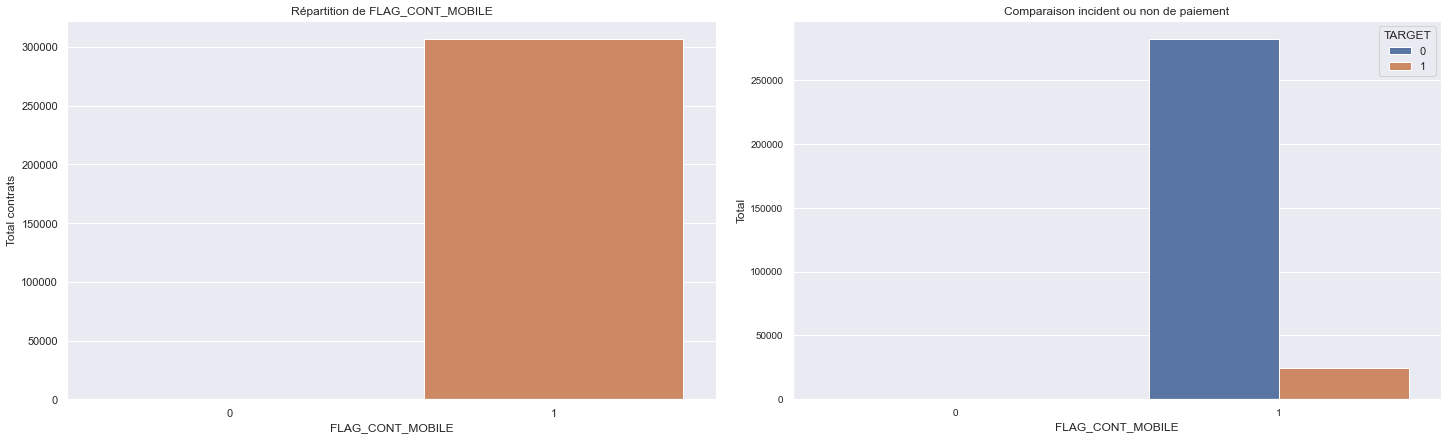

In [55]:
categorical_info(application_train,'FLAG_CONT_MOBILE',label_rotation=0)


In [56]:
print(f"{application_train['FLAG_CONT_MOBILE'].isna().sum()} valeurs manquantes")

percent = (len(application_train[application_train['FLAG_CONT_MOBILE'] == 0]) / application_train.shape[0]) * 100
print(f"{percent:.2f}% des clients n'avait pas de téléphone portable joignable")

p_count = len(application_train[application_train['FLAG_CONT_MOBILE'] == 0])
p_not = len(application_train[(application_train['FLAG_CONT_MOBILE'] == 0) & (application_train['TARGET'] == 1)]) 

percent = (p_not / p_count) * 100
print(f"{percent:.2f}% des clients qui n'avait pas de téléphone portable joignable ne remboursent pas leur crédit")


0 valeurs manquantes
0.19% des clients n'avait pas de téléphone portable joignable
7.84% des clients qui n'avait pas de téléphone portable joignable ne remboursent pas leur crédit


Très peu de client n'avait pas un téléphone mobile joignable (0.19%), mais 8% de ceux-ci ne remboursent pas leur crédit. 

### FLAG_PHONE
Le client a-t-il fourni un téléphone personnel (1=Oui 0=Non)


--------------------------
-- FLAG_PHONE           --
--------------------------
0 valeurs manquantes
---------------------------
-2.38% de corrélation entre FLAG_PHONE et TARGET
---------------------------


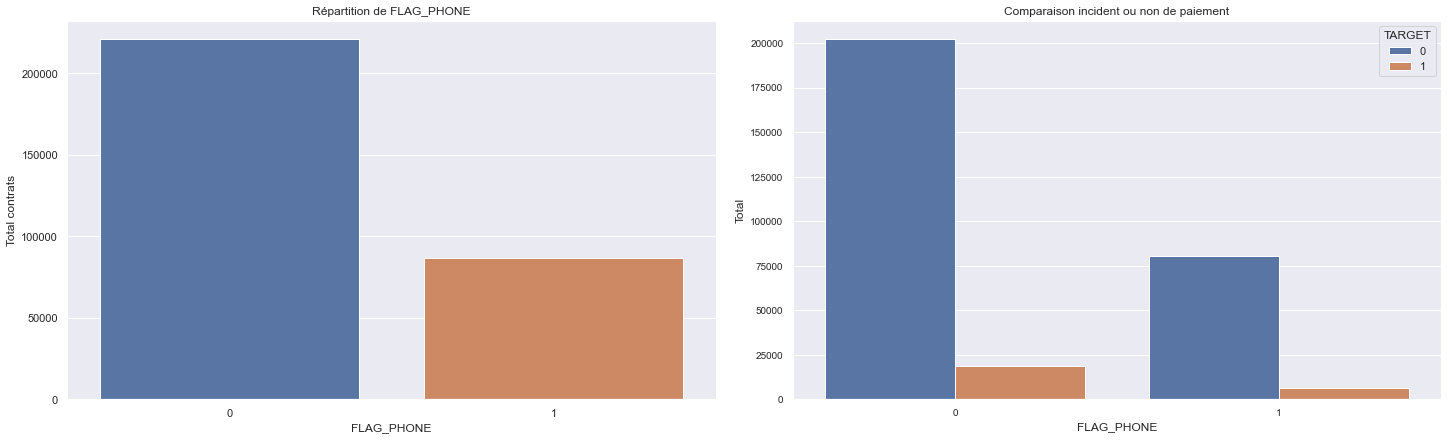

In [57]:
categorical_info(application_train,'FLAG_PHONE',label_rotation=0)

In [58]:
print(f"{application_train['FLAG_PHONE'].isna().sum()} valeurs manquantes")

percent = (len(application_train[application_train['FLAG_PHONE'] == 1]) / application_train.shape[0]) * 100
print(f"{percent:.2f}% des clients ont fourni un numéro de téléphone personnel")

p_count = len(application_train[application_train['FLAG_PHONE'] == 1])
p_not = len(application_train[(application_train['FLAG_PHONE'] == 1) & (application_train['TARGET'] == 1)]) 

percent = (p_not / p_count) * 100
print(f"{percent:.2f}% des clients ont fourni un numéro de téléphone personnel ne remboursent pas leur crédit")



0 valeurs manquantes
28.11% des clients ont fourni un numéro de téléphone personnel
7.04% des clients ont fourni un numéro de téléphone personnel ne remboursent pas leur crédit


Un peu plus 1/3 des client ne fournissent pas de numéro de téléphone personnel. Ces clients ne reboursent pas dans 7% des cas

### FLAG_EMAIL
Le client a-t-il fourni une adresse email (1=OUI 0=NON)


--------------------------
-- FLAG_EMAIL           --
--------------------------
0 valeurs manquantes
---------------------------
-0.18% de corrélation entre FLAG_EMAIL et TARGET
---------------------------


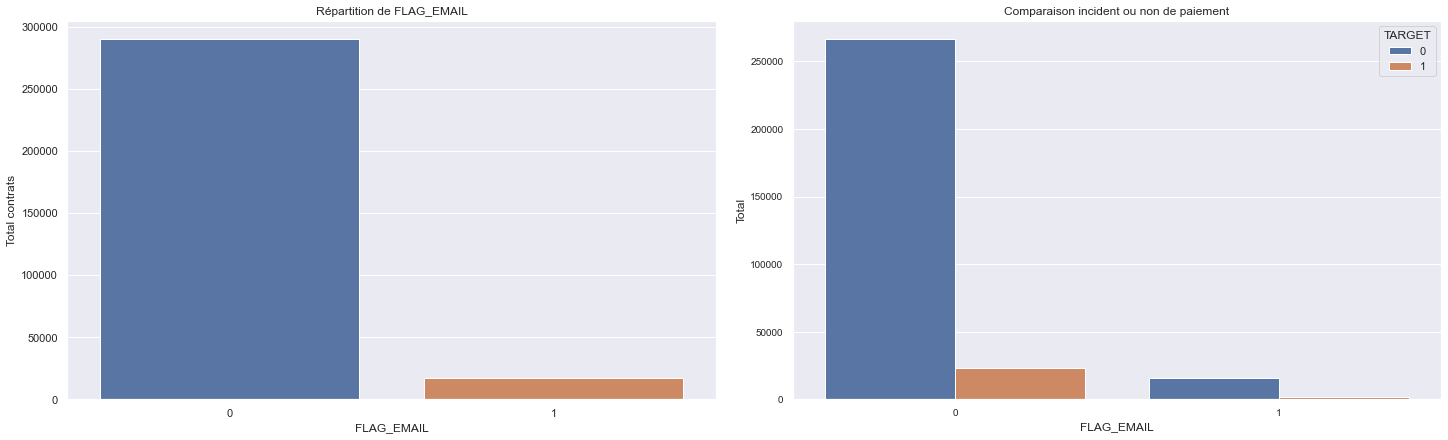

In [59]:
categorical_info(application_train,'FLAG_EMAIL',label_rotation=0)

In [60]:
print(f"{application_train['FLAG_EMAIL'].isna().sum()} valeurs manquantes")

percent = (len(application_train[application_train['FLAG_EMAIL'] == 1]) / application_train.shape[0]) * 100
print(f"{percent:.2f}% des clients fournissent d'adresse email")

p_count = len(application_train[application_train['FLAG_EMAIL'] == 1])
p_not = len(application_train[(application_train['FLAG_EMAIL'] == 1) & (application_train['TARGET'] == 1)]) 

percent = (p_not / p_count) * 100
print(f"{percent:.2f}% des clients qui fournissent une adresse email ne remboursent pas leur crédit")


0 valeurs manquantes
5.67% des clients fournissent d'adresse email
7.88% des clients qui fournissent une adresse email ne remboursent pas leur crédit


Quelques clients fournissent leur adresse Email (6%) et ils sont 8% à ne pas rembourser leur crédit 

In [61]:
def show_flag_document(doc_no):
    """
    Affichage des pourcentages de remboursement pour les variables explicative dont le nom 
    commence par FLAG_DOCUMENT_
    """
    document = 'FLAG_DOCUMENT_' + str(doc_no)
    
    categorical_info(application_train,document,label_rotation=0)

    print(f"{application_train[document].isna().sum()} valeurs manquantes")

    percent = (len(application_train[application_train[document] == 1]) / application_train.shape[0]) * 100
    print(f"{percent:.2f}% des clients fournissent le document {doc_no}")

    p_count = len(application_train[application_train[document] == 1])
    p_not = len(application_train[(application_train[document] == 1) & (application_train['TARGET'] == 1)]) 

    percent = (p_not / p_count) * 100
    print(f"{percent:.2f}% des clients qui fournissent le document {doc_no} ne remboursent pas leur crédit")

### FLAG_DOCUMENT_2
Le client a-t-il fourni le document 2


--------------------------
-- FLAG_DOCUMENT_2      --
--------------------------
0 valeurs manquantes
---------------------------
0.54% de corrélation entre FLAG_DOCUMENT_2 et TARGET
---------------------------


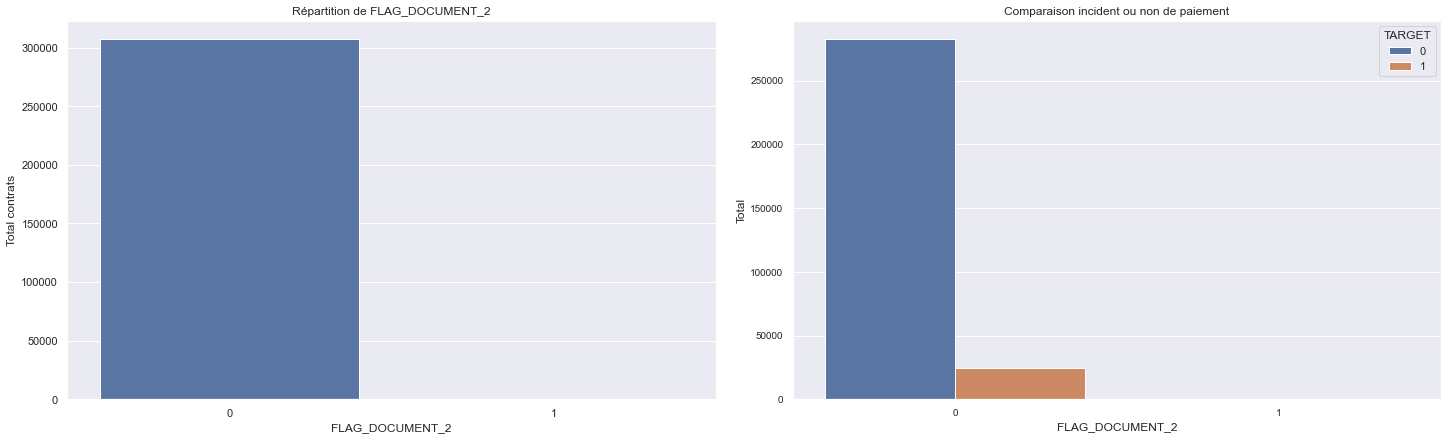

0 valeurs manquantes
0.00% des clients fournissent le document 2
30.77% des clients qui fournissent le document 2 ne remboursent pas leur crédit


In [62]:
show_flag_document(2)

### FLAG_DOCUMENT_3

Le client a-t-il fourni le document 3


--------------------------
-- FLAG_DOCUMENT_3      --
--------------------------
0 valeurs manquantes
---------------------------
4.43% de corrélation entre FLAG_DOCUMENT_3 et TARGET
---------------------------


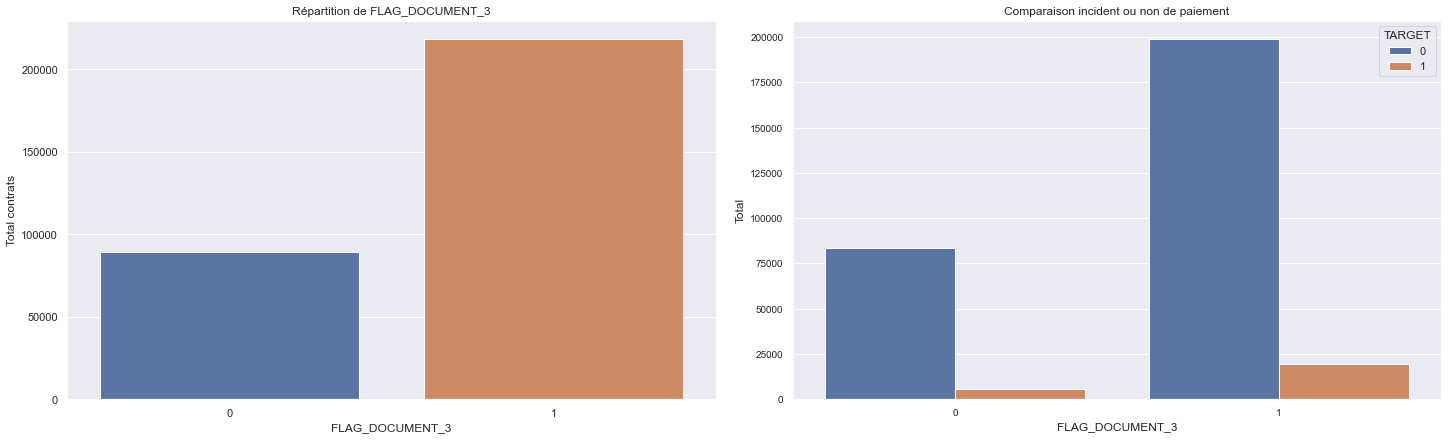

0 valeurs manquantes
71.00% des clients fournissent le document 3
8.84% des clients qui fournissent le document 3 ne remboursent pas leur crédit


In [63]:
show_flag_document(3)

### FLAG_DOCUMENT_4
Le client a-t-il fourni le document 4


--------------------------
-- FLAG_DOCUMENT_4      --
--------------------------
0 valeurs manquantes
---------------------------
-0.27% de corrélation entre FLAG_DOCUMENT_4 et TARGET
---------------------------


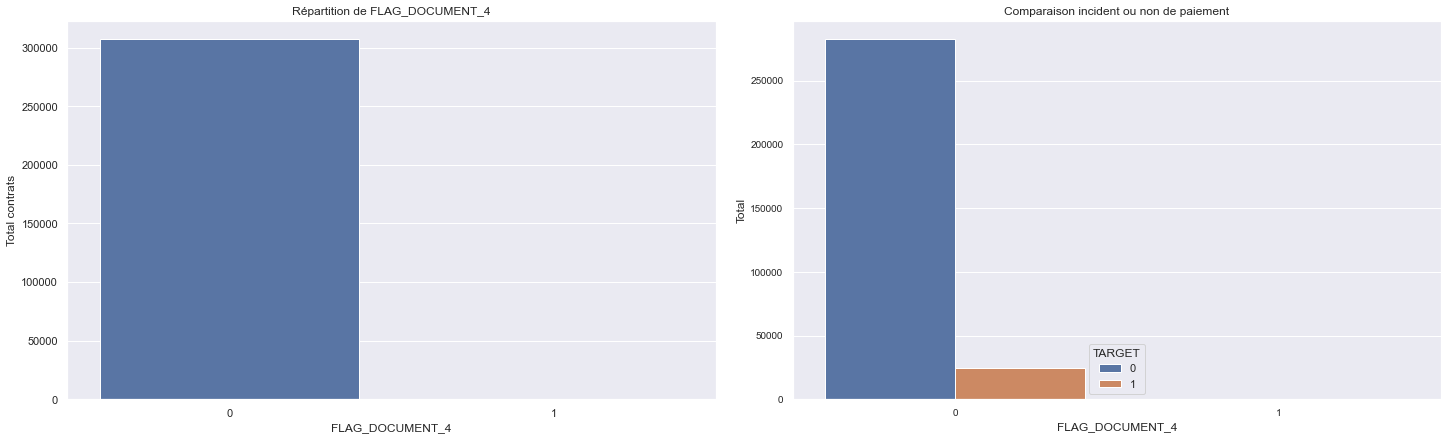

0 valeurs manquantes
0.01% des clients fournissent le document 4
0.00% des clients qui fournissent le document 4 ne remboursent pas leur crédit


In [64]:
show_flag_document(4)

### FLAG_DOCUMENT_5
Le client a-t-il fourni le document 5


--------------------------
-- FLAG_DOCUMENT_5      --
--------------------------
0 valeurs manquantes
---------------------------
-0.03% de corrélation entre FLAG_DOCUMENT_5 et TARGET
---------------------------


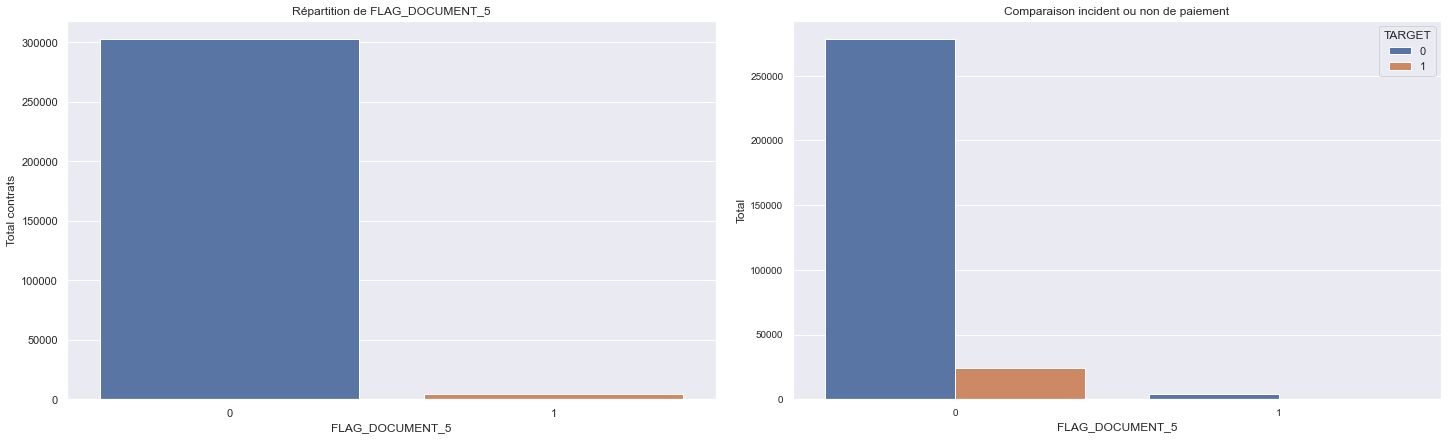

0 valeurs manquantes
1.51% des clients fournissent le document 5
8.00% des clients qui fournissent le document 5 ne remboursent pas leur crédit


In [65]:
show_flag_document(5)

### FLAG_DOCUMENT_6
Le client a-t-il fourni le document 6


--------------------------
-- FLAG_DOCUMENT_6      --
--------------------------
0 valeurs manquantes
---------------------------
-2.86% de corrélation entre FLAG_DOCUMENT_6 et TARGET
---------------------------


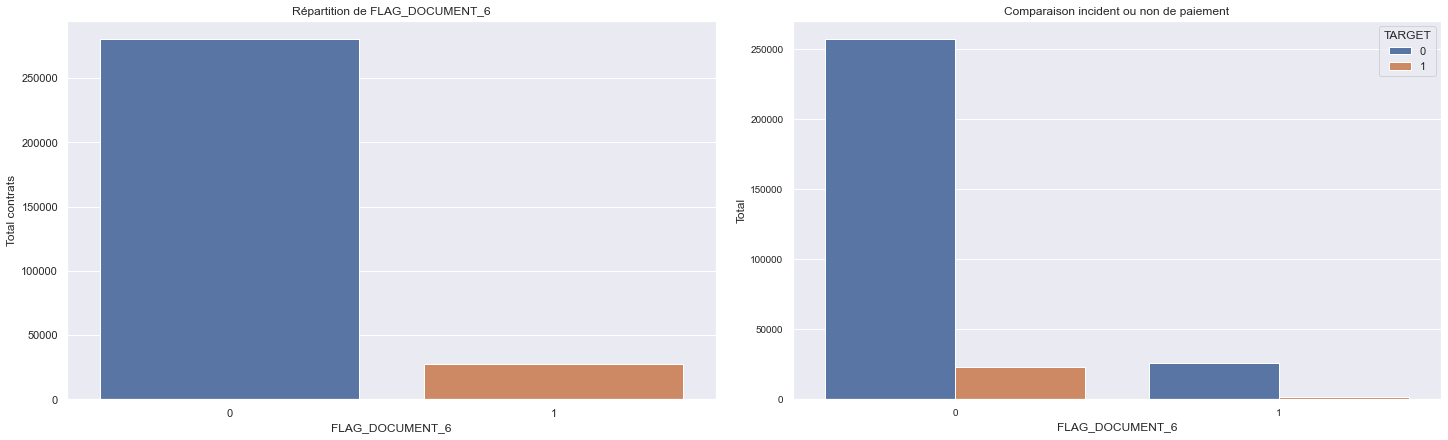

0 valeurs manquantes
8.81% des clients fournissent le document 6
5.57% des clients qui fournissent le document 6 ne remboursent pas leur crédit


In [66]:
show_flag_document(6)

### FLAG_DOCUMENT_7
Le client a-t-il fourni le document 7


--------------------------
-- FLAG_DOCUMENT_7      --
--------------------------
0 valeurs manquantes
---------------------------
-0.15% de corrélation entre FLAG_DOCUMENT_7 et TARGET
---------------------------


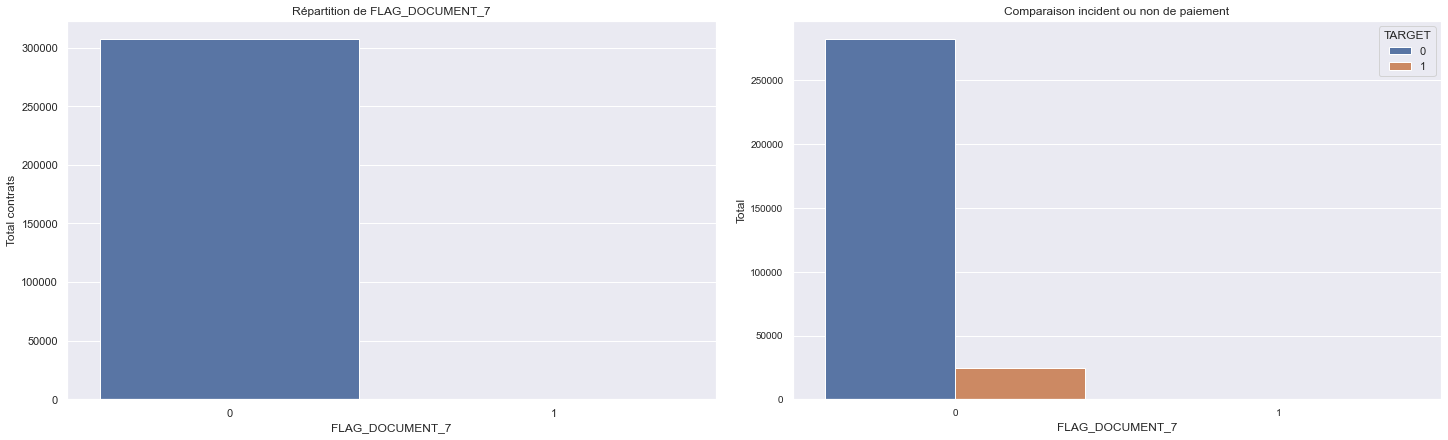

0 valeurs manquantes
0.02% des clients fournissent le document 7
5.08% des clients qui fournissent le document 7 ne remboursent pas leur crédit


In [67]:
show_flag_document(7)

### FLAG_DOCUMENT_8
Le client a-t-il fourni le document 8


--------------------------
-- FLAG_DOCUMENT_8      --
--------------------------
0 valeurs manquantes
---------------------------
-0.80% de corrélation entre FLAG_DOCUMENT_8 et TARGET
---------------------------


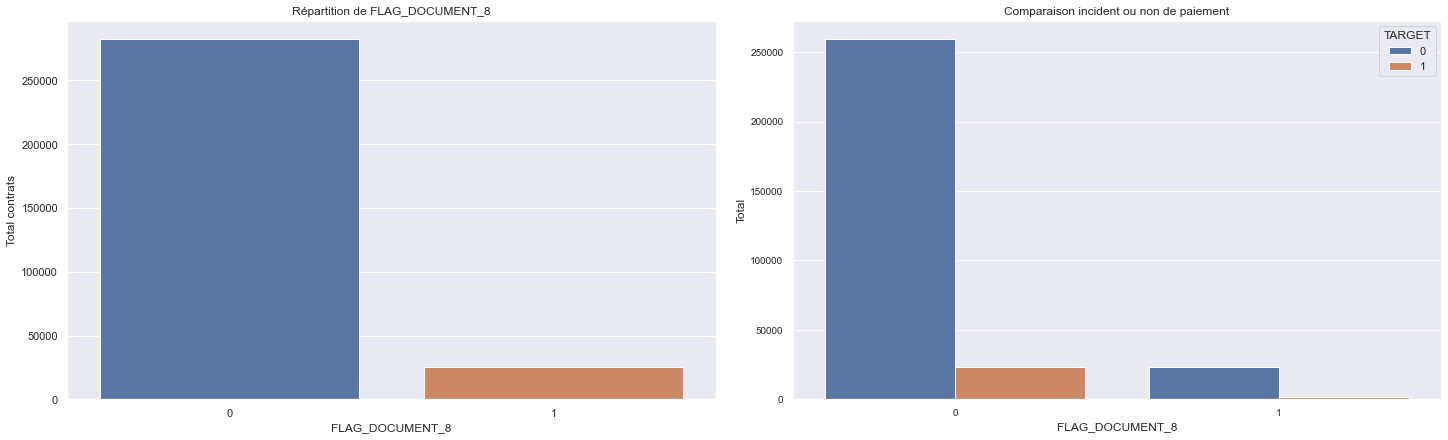

0 valeurs manquantes
8.14% des clients fournissent le document 8
7.34% des clients qui fournissent le document 8 ne remboursent pas leur crédit


In [68]:
show_flag_document(8)

### FLAG_DOCUMENT_9
Le client a-t-il fourni le document 9


--------------------------
-- FLAG_DOCUMENT_9      --
--------------------------
0 valeurs manquantes
---------------------------
-0.44% de corrélation entre FLAG_DOCUMENT_9 et TARGET
---------------------------


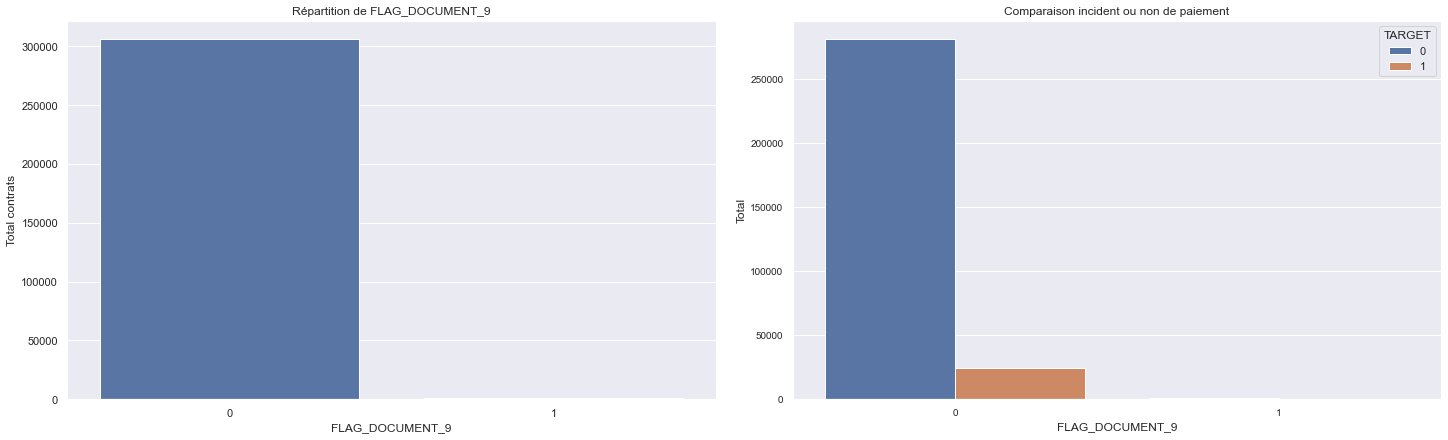

0 valeurs manquantes
0.39% des clients fournissent le document 9
6.18% des clients qui fournissent le document 9 ne remboursent pas leur crédit


In [69]:
show_flag_document(9)

### FLAG_DOCUMENT_10
Le client a-t-il fourni le document 10


--------------------------
-- FLAG_DOCUMENT_10     --
--------------------------
0 valeurs manquantes
---------------------------
-0.14% de corrélation entre FLAG_DOCUMENT_10 et TARGET
---------------------------


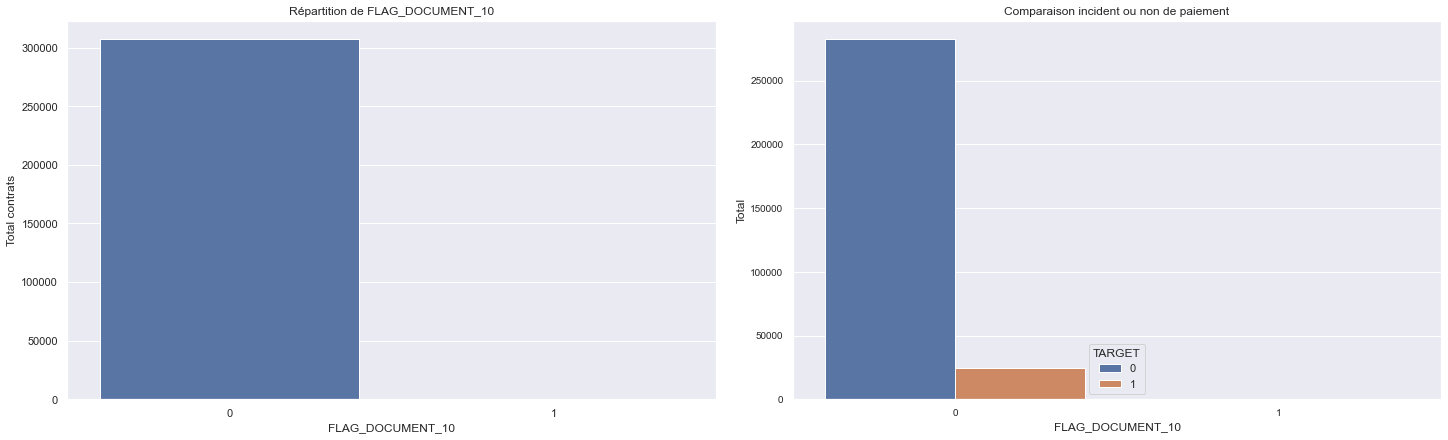

0 valeurs manquantes
0.00% des clients fournissent le document 10
0.00% des clients qui fournissent le document 10 ne remboursent pas leur crédit


In [70]:
show_flag_document(10)

In [71]:
print(f"{len(application_train[application_train['FLAG_DOCUMENT_10'] == 1])} clients ont fourni le document 10  et {len(application_train[(application_train['FLAG_DOCUMENT_10'] == 1) & (application_train['TARGET'] == 0)])} clients ont remboursé leur crédit")

7 clients ont fourni le document 10  et 7 clients ont remboursé leur crédit


### FLAG_DOCUMENT_11
Le client a-t-il fourni le document 11


--------------------------
-- FLAG_DOCUMENT_11     --
--------------------------
0 valeurs manquantes
---------------------------
-0.42% de corrélation entre FLAG_DOCUMENT_11 et TARGET
---------------------------


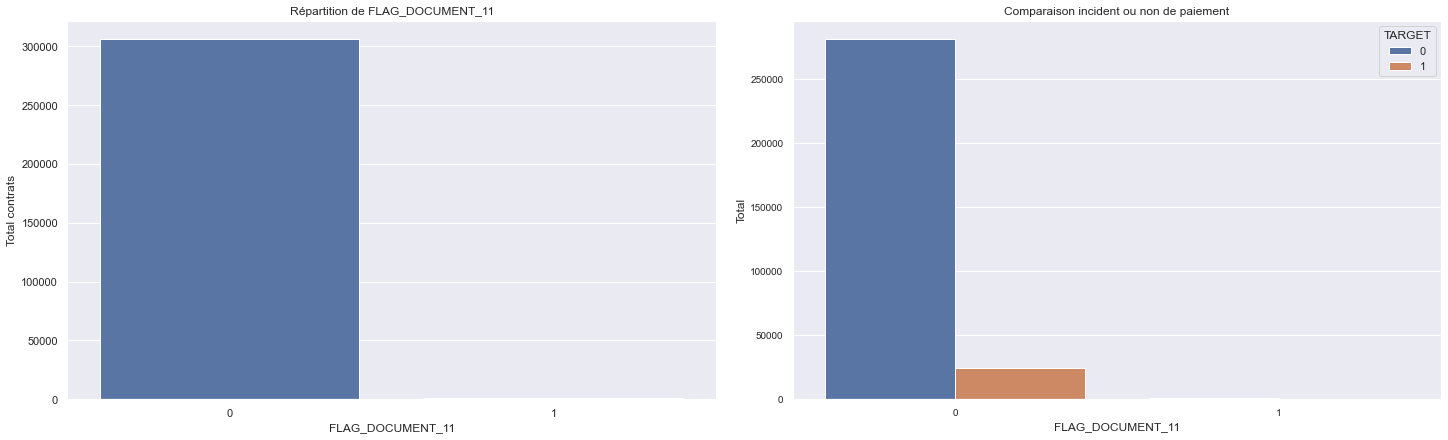

0 valeurs manquantes
0.39% des clients fournissent le document 11
6.23% des clients qui fournissent le document 11 ne remboursent pas leur crédit


In [72]:
show_flag_document(11)

### FLAG_DOCUMENT_12
Le client a-t-il fourni le document 12


--------------------------
-- FLAG_DOCUMENT_12     --
--------------------------
0 valeurs manquantes
---------------------------
-0.08% de corrélation entre FLAG_DOCUMENT_12 et TARGET
---------------------------


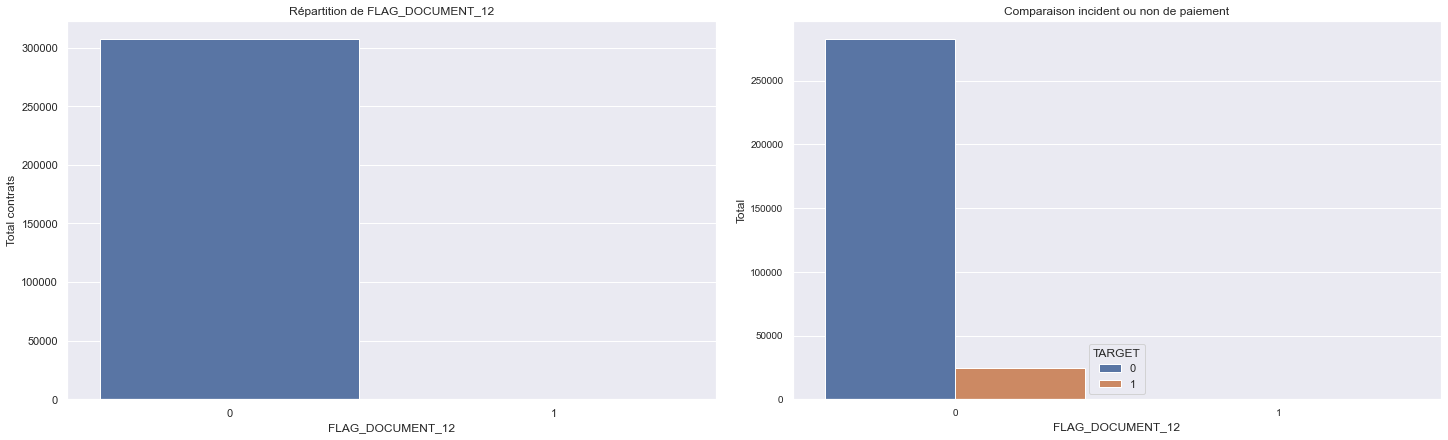

0 valeurs manquantes
0.00% des clients fournissent le document 12
0.00% des clients qui fournissent le document 12 ne remboursent pas leur crédit


In [73]:
show_flag_document(12)

In [74]:
print(f"{len(application_train[application_train['FLAG_DOCUMENT_12'] == 1])} clients ont fourni le document 12 et {len(application_train[(application_train['FLAG_DOCUMENT_12'] == 1) & (application_train['TARGET'] == 0)])} clients ont remboursé leur crédit")

2 clients ont fourni le document 12 et 2 clients ont remboursé leur crédit


### FLAG_DOCUMENT_13
Le client a-t-il fourni le document 13


--------------------------
-- FLAG_DOCUMENT_13     --
--------------------------
0 valeurs manquantes
---------------------------
-1.16% de corrélation entre FLAG_DOCUMENT_13 et TARGET
---------------------------


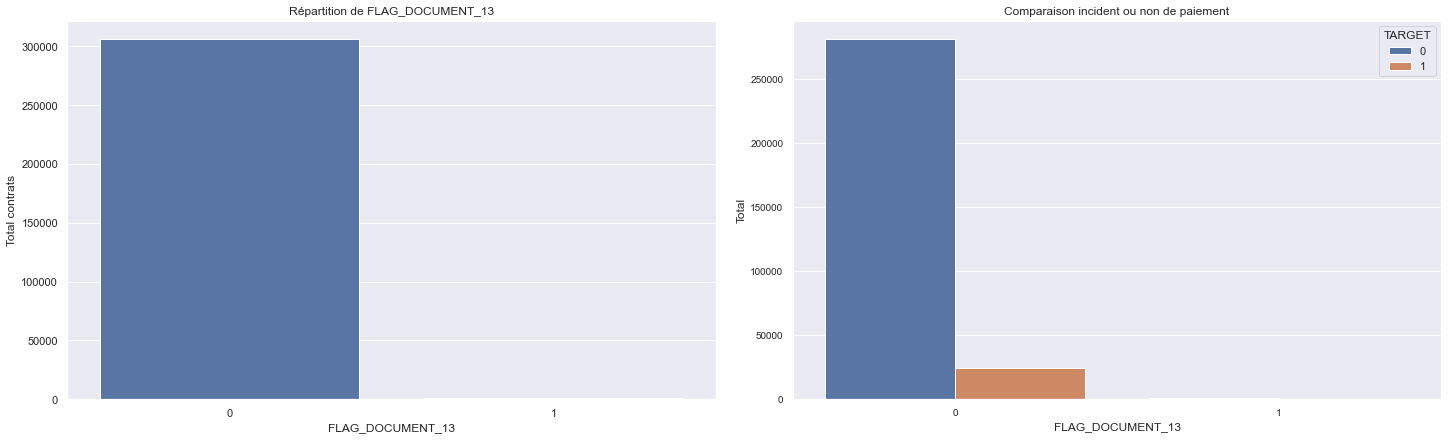

0 valeurs manquantes
0.35% des clients fournissent le document 13
2.77% des clients qui fournissent le document 13 ne remboursent pas leur crédit


In [75]:
show_flag_document(13)

### FLAG_DOCUMENT_14
Le client a-t-il fourni le document 14


--------------------------
-- FLAG_DOCUMENT_14     --
--------------------------
0 valeurs manquantes
---------------------------
-0.95% de corrélation entre FLAG_DOCUMENT_14 et TARGET
---------------------------


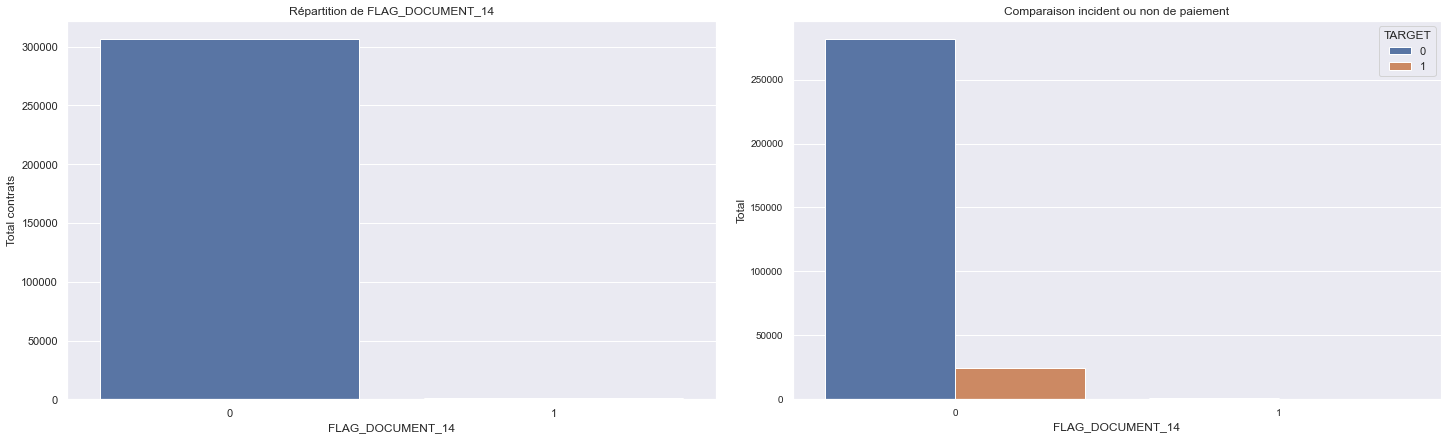

0 valeurs manquantes
0.29% des clients fournissent le document 14
3.32% des clients qui fournissent le document 14 ne remboursent pas leur crédit


In [76]:
show_flag_document(14)

### FLAG_DOCUMENT_15
Le client a-t-il fourni le document 15


--------------------------
-- FLAG_DOCUMENT_15     --
--------------------------
0 valeurs manquantes
---------------------------
-0.65% de corrélation entre FLAG_DOCUMENT_15 et TARGET
---------------------------


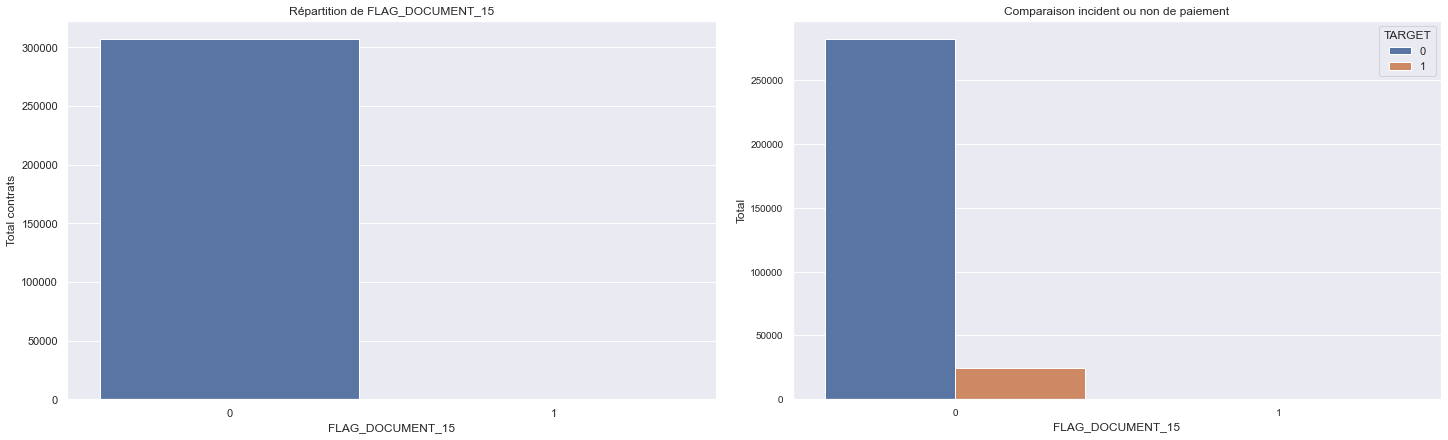

0 valeurs manquantes
0.12% des clients fournissent le document 15
2.96% des clients qui fournissent le document 15 ne remboursent pas leur crédit


In [77]:
show_flag_document(15)

### FLAG_DOCUMENT_16
Le client a-t-il fourni le document 16


--------------------------
-- FLAG_DOCUMENT_16     --
--------------------------
0 valeurs manquantes
---------------------------
-1.16% de corrélation entre FLAG_DOCUMENT_16 et TARGET
---------------------------


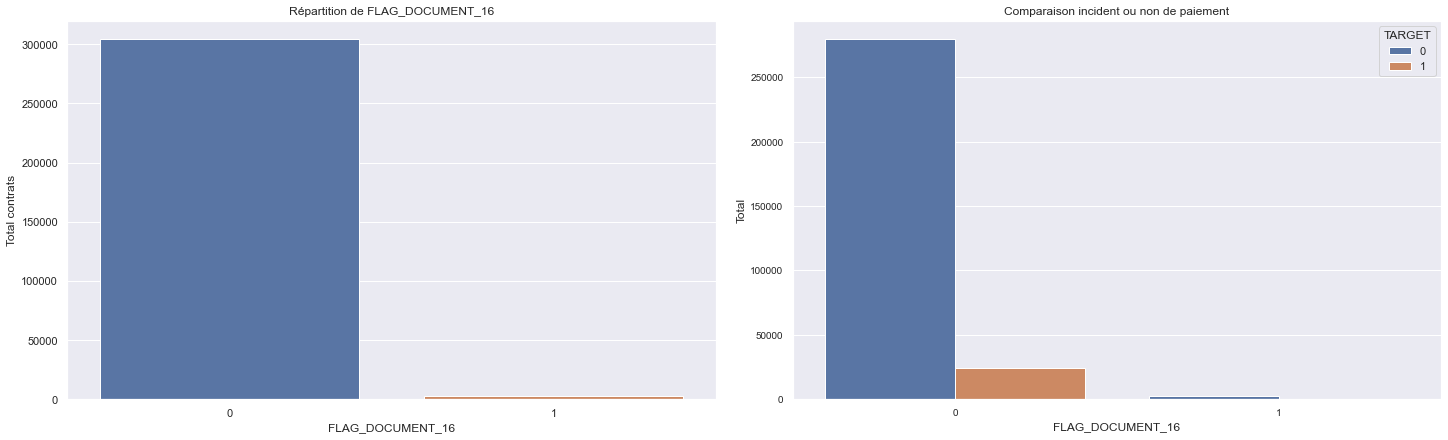

0 valeurs manquantes
0.99% des clients fournissent le document 16
4.91% des clients qui fournissent le document 16 ne remboursent pas leur crédit


In [78]:
show_flag_document(16)

### FLAG_DOCUMENT_17
Le client a-t-il fourni le document 17


--------------------------
-- FLAG_DOCUMENT_17     --
--------------------------
0 valeurs manquantes
---------------------------
-0.34% de corrélation entre FLAG_DOCUMENT_17 et TARGET
---------------------------


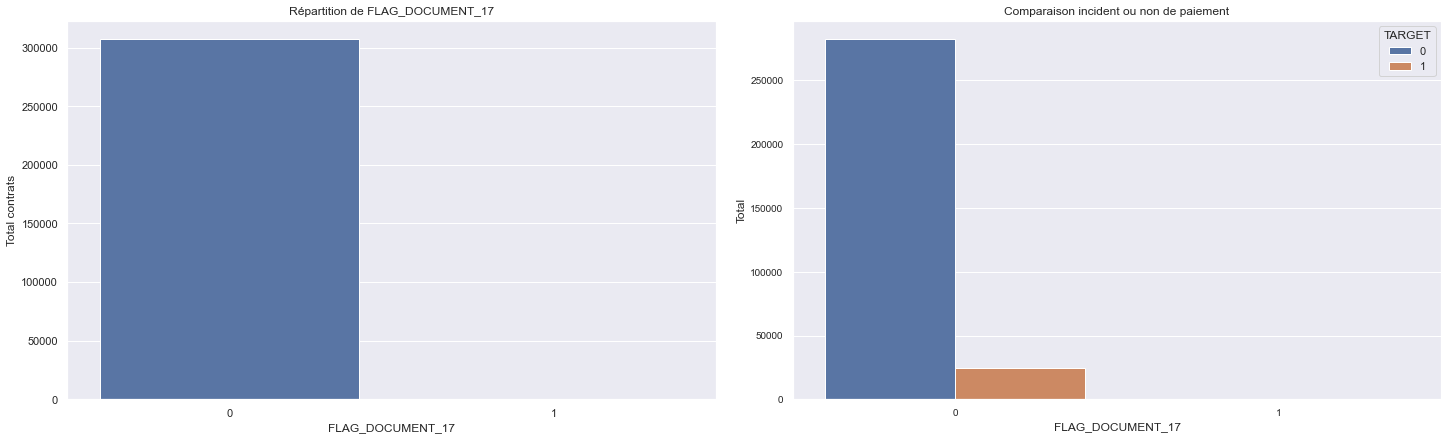

0 valeurs manquantes
0.03% des clients fournissent le document 17
2.44% des clients qui fournissent le document 17 ne remboursent pas leur crédit


In [79]:
show_flag_document(17)

### FLAG_DOCUMENT_18
Le client a-t-il fourni le document 18


--------------------------
-- FLAG_DOCUMENT_18     --
--------------------------
0 valeurs manquantes
---------------------------
-0.80% de corrélation entre FLAG_DOCUMENT_18 et TARGET
---------------------------


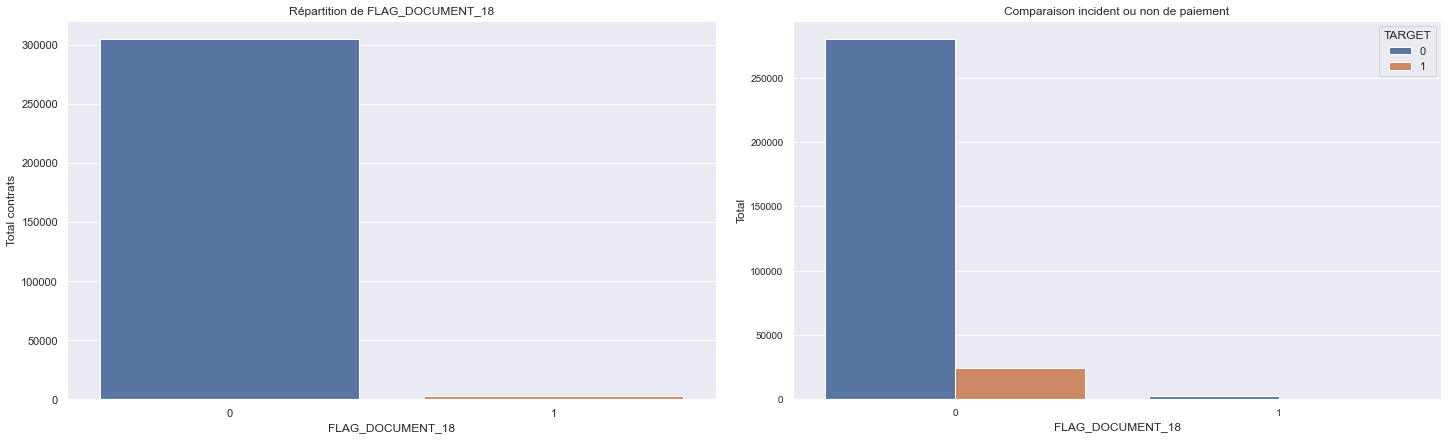

0 valeurs manquantes
0.81% des clients fournissent le document 18
5.68% des clients qui fournissent le document 18 ne remboursent pas leur crédit


In [80]:
show_flag_document(18)

### FLAG_DOCUMENT_19
Le client a-t-il fourni le document 19


--------------------------
-- FLAG_DOCUMENT_19     --
--------------------------
0 valeurs manquantes
---------------------------
-0.14% de corrélation entre FLAG_DOCUMENT_19 et TARGET
---------------------------


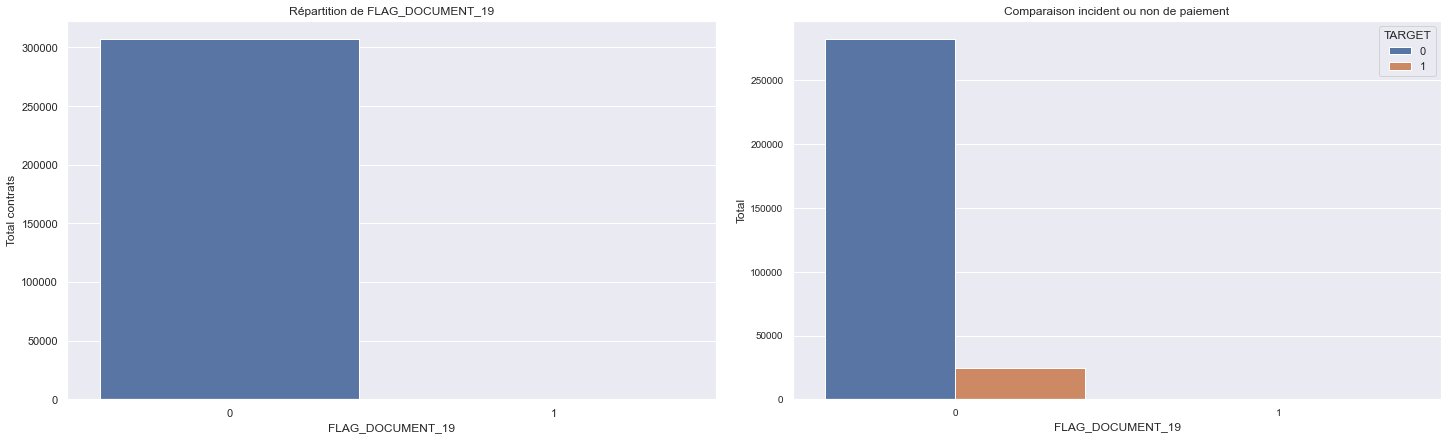

0 valeurs manquantes
0.06% des clients fournissent le document 19
6.56% des clients qui fournissent le document 19 ne remboursent pas leur crédit


In [81]:
show_flag_document(19)

### FLAG_DOCUMENT_20
Le client a-t-il fourni le document 20


--------------------------
-- FLAG_DOCUMENT_20     --
--------------------------
0 valeurs manquantes
---------------------------
0.02% de corrélation entre FLAG_DOCUMENT_20 et TARGET
---------------------------


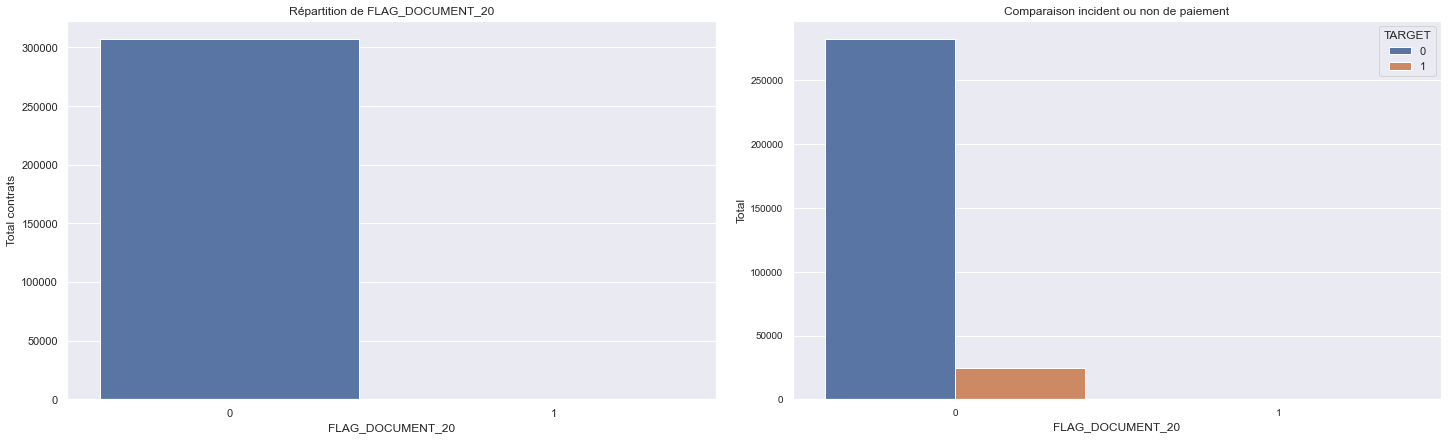

0 valeurs manquantes
0.05% des clients fournissent le document 20
8.33% des clients qui fournissent le document 20 ne remboursent pas leur crédit


In [82]:
show_flag_document(20)

### FLAG_DOCUMENT_21
Le client a-t-il fourni le document 21


--------------------------
-- FLAG_DOCUMENT_21     --
--------------------------
0 valeurs manquantes
---------------------------
0.37% de corrélation entre FLAG_DOCUMENT_21 et TARGET
---------------------------


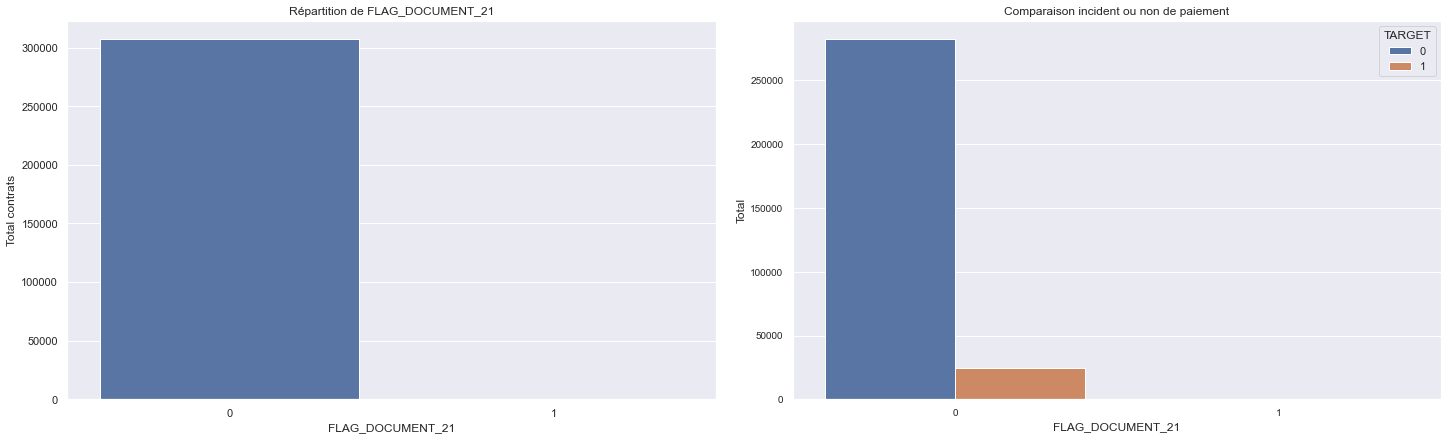

0 valeurs manquantes
0.03% des clients fournissent le document 21
13.59% des clients qui fournissent le document 21 ne remboursent pas leur crédit


In [83]:
show_flag_document(21)

### AMT_INCOME_TOTAL
Revenu du client


0 valeurs manquantes
----------------------
Asymetrie : 391.5577697753906
LOG - Asymetrie : 0.169985830783844
SQR - Asymetrie : 4.907087326049805
----------------------
Corrélation de -0.40% entre AMT_INCOME_TOTAL et TARGET
----------------------
count      307511.000
mean       168797.922
std        237123.141
min         25650.000
25%        112500.000
50%        147150.000
75%        202500.000
max     117000000.000
Name: AMT_INCOME_TOTAL, dtype: float64


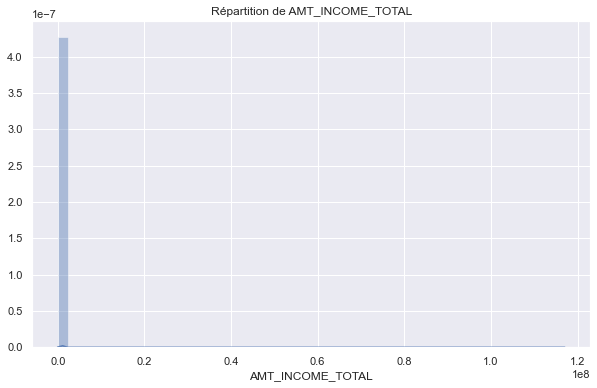

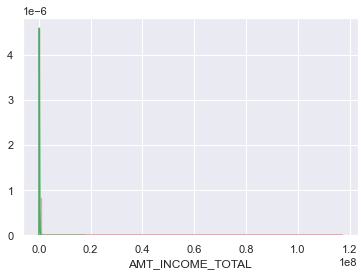

In [84]:
show_numerical(application_train, 'AMT_INCOME_TOTAL')

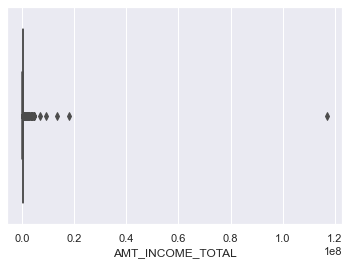

In [85]:
sns.boxplot(x=application_train["AMT_INCOME_TOTAL"]);

Cette variable comporte une valeur aberrante qui fausse l'analyse. il sera donc nécessaire de la supprimer.

In [86]:
application_train = application_train.drop(index=application_train.loc[application_train['AMT_INCOME_TOTAL'] == 117000000].index)

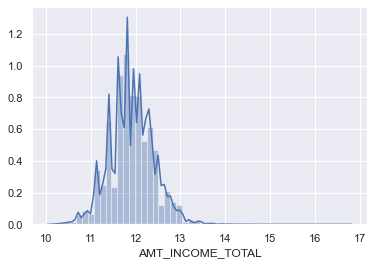

In [87]:
sns.distplot(np.log(application_train['AMT_INCOME_TOTAL']))

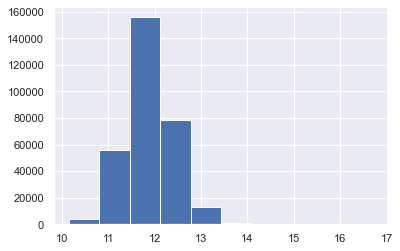

In [88]:
np.log(application_train['AMT_INCOME_TOTAL']).hist()

En application une transformation log, cette variable explicative devient une distribution normale.

### AMT_CREDIT
Montant du crédit du prêt


0 valeurs manquantes
----------------------
Asymetrie : 1.234768033027649
LOG - Asymetrie : -0.3388274013996124
SQR - Asymetrie : 0.4471217095851898
----------------------
Corrélation de -3.04% entre AMT_CREDIT et TARGET
----------------------
count    307509.000
mean     599027.438
std      402491.375
min       45000.000
25%      270000.000
50%      513531.000
75%      808650.000
max     4050000.000
Name: AMT_CREDIT, dtype: float64


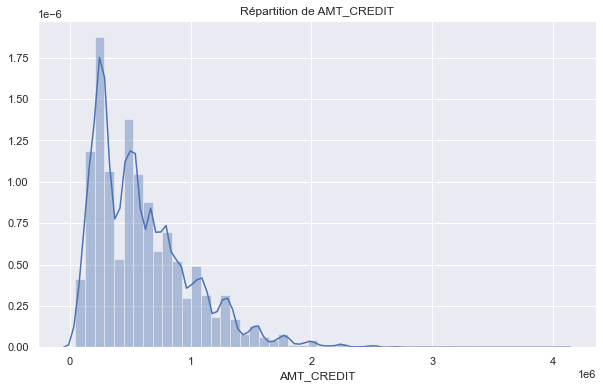

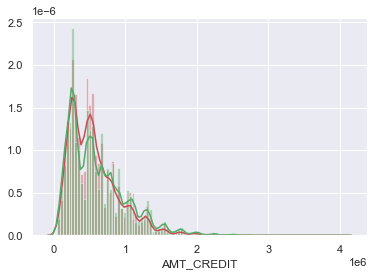

In [226]:
show_numerical(application_train, 'AMT_CREDIT')

Le montant du crédit ne semble pas influer le remboursement ou non du prêt.

### AMT_ANNUITY
Rente de prêt.

Cela correspond au paiement annuel d'une partie du capital emprunté et des intérêts.



12 valeurs manquantes
----------------------
Asymetrie : 1.5797662734985352
LOG - Asymetrie : -0.3456639051437378
SQR - Asymetrie : 0.45211073756217957
----------------------
Corrélation de -1.28% entre AMT_ANNUITY et TARGET
----------------------
count   307498.000
mean     27108.576
std      14493.761
min       1615.500
25%      16524.000
50%      24903.000
75%      34596.000
max     258025.500
Name: AMT_ANNUITY, dtype: float64


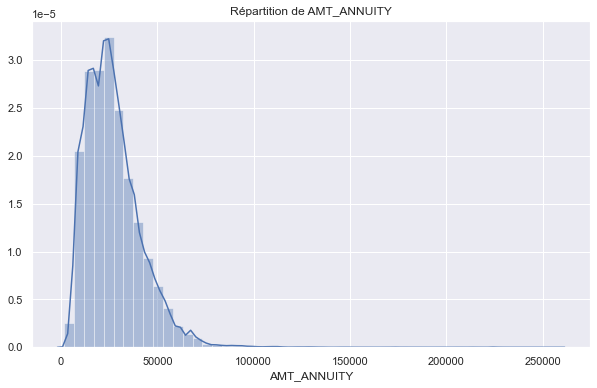

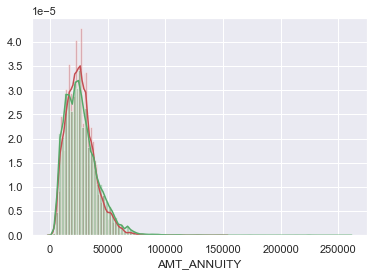

In [90]:
show_numerical(application_train, 'AMT_ANNUITY')

Le montant du crédit ne semble pas influer le remboursement ou non du prêt.

### AMT_GOODS_PRICE
Pour les prêts à la consommation. il s'agit du prix des biens pour lesquels le prêt est accordé


278 valeurs manquantes
----------------------
Asymetrie : 1.3489903211593628
LOG - Asymetrie : -0.29294055700302124
SQR - Asymetrie : 0.5205060839653015
----------------------
Corrélation de -3.96% entre AMT_GOODS_PRICE et TARGET
----------------------
count    307232.000
mean     538396.438
std      369447.031
min       40500.000
25%      238500.000
50%      450000.000
75%      679500.000
max     4050000.000
Name: AMT_GOODS_PRICE, dtype: float64


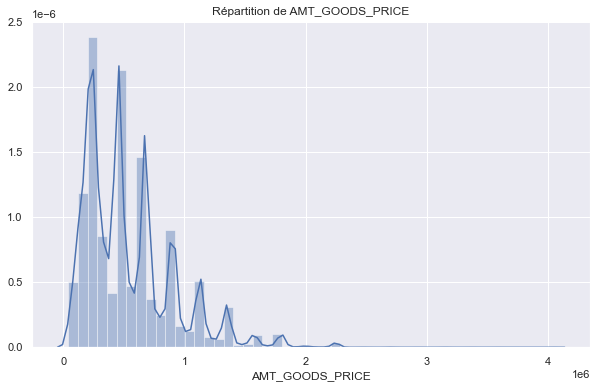

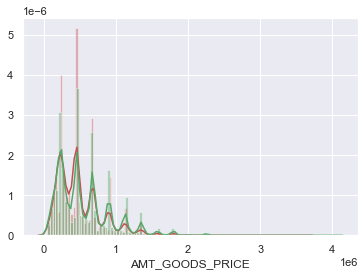

In [91]:
show_numerical(application_train, 'AMT_GOODS_PRICE')

Le prix des biens emprutés ne semble pas influer le remboursement ou non du prêt.

### AMT_REQ_CREDIT_BUREAU_HOUR
Nombre de demandes de renseignements au bureau de crédit concernant le client une heure avant la demande


In [92]:
print(f"{application_train['AMT_REQ_CREDIT_BUREAU_HOUR'].isna().sum()} valeurs manquantes")

41519 valeurs manquantes


In [93]:
application_train['AMT_REQ_CREDIT_BUREAU_HOUR'].value_counts()

0.000    264365
1.000      1560
2.000        56
3.000         9
4.000         1
Name: AMT_REQ_CREDIT_BUREAU_HOUR, dtype: int64

--------------------------
-- AMT_REQ_CREDIT_BUREAU_HOUR --
--------------------------
41519 valeurs manquantes
---------------------------
-3.18% de corrélation entre AMT_REQ_CREDIT_BUREAU_HOUR et TARGET
---------------------------


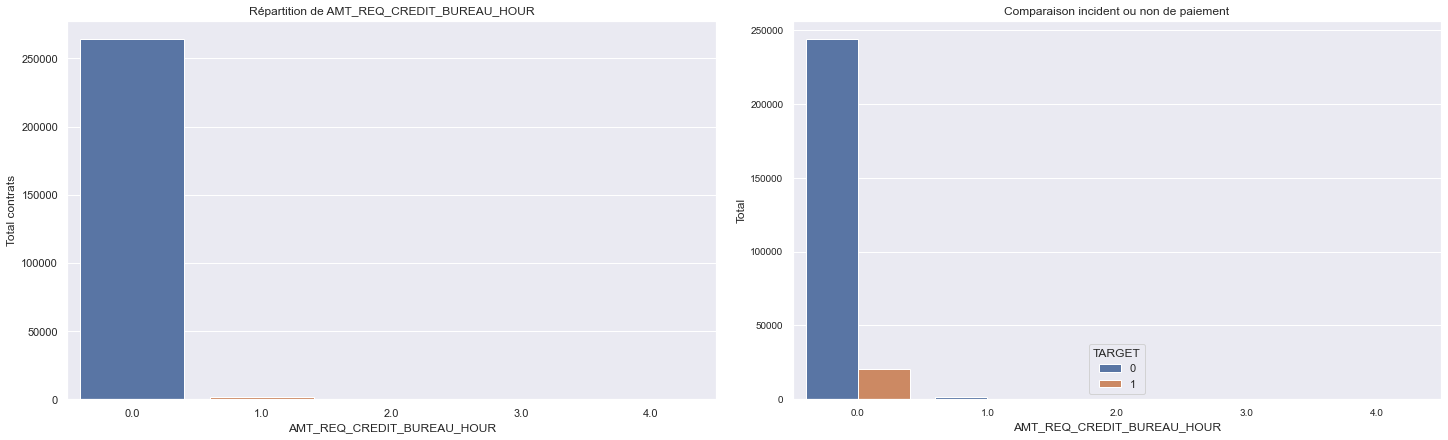

In [94]:
categorical_info(application_train,'AMT_REQ_CREDIT_BUREAU_HOUR',label_rotation=0)

In [95]:
percent = (len(application_train[application_train['AMT_REQ_CREDIT_BUREAU_HOUR'] == 0]) / application_train.shape[0]) * 100
print(f"{percent:.2f}% ne demandent pas de renseigments avant")

p_count = len(application_train[application_train['AMT_REQ_CREDIT_BUREAU_HOUR'] == 1])
p_not = len(application_train[(application_train['AMT_REQ_CREDIT_BUREAU_HOUR'] == 1) & (application_train['TARGET'] == 1)]) 

percent = (p_not / p_count) * 100
print(f"{percent:.2f}% des clients demandant 1 renseignement avant ne remboursent pas leur crédit")

p_count = len(application_train[application_train['AMT_REQ_CREDIT_BUREAU_HOUR'] == 2])
p_not = len(application_train[(application_train['AMT_REQ_CREDIT_BUREAU_HOUR'] == 2) & (application_train['TARGET'] == 1)]) 

percent = (p_not / p_count) * 100
print(f"{percent:.2f}% des clients demandant 2 renseignements avant ne remboursent pas leur crédit")


85.97% ne demandent pas de renseigments avant
8.01% des clients demandant 1 renseignement avant ne remboursent pas leur crédit
10.71% des clients demandant 2 renseignements avant ne remboursent pas leur crédit


De nombreux client ne cherchent pas de renseignements avant de prendre un crédit et si le client fait 1 ou 2 demandes de renseigments il est fort probalble qu'il ne rembourse pas sont crédit. 
En revanche très peu de clients demandes plus de 3 renseignements, cependant ceux-ci auront plus tendance à rembourser leur prêt.

### AMT_REQ_CREDIT_BUREAU_DAY
Nombre de demandes de renseignements sur le client adressées au bureau de crédit un jour avant la demande (à l'exclusion d'une heure avant la demande)


In [96]:
print(f"{application_train['AMT_REQ_CREDIT_BUREAU_DAY'].isna().sum()} valeurs manquantes")

41519 valeurs manquantes


In [97]:
application_train['AMT_REQ_CREDIT_BUREAU_DAY'].value_counts()

0.000    264502
1.000      1292
2.000       106
3.000        45
4.000        26
5.000         9
6.000         8
9.000         2
8.000         1
Name: AMT_REQ_CREDIT_BUREAU_DAY, dtype: int64

--------------------------
-- AMT_REQ_CREDIT_BUREAU_DAY --
--------------------------
41519 valeurs manquantes
---------------------------
-3.08% de corrélation entre AMT_REQ_CREDIT_BUREAU_DAY et TARGET
---------------------------


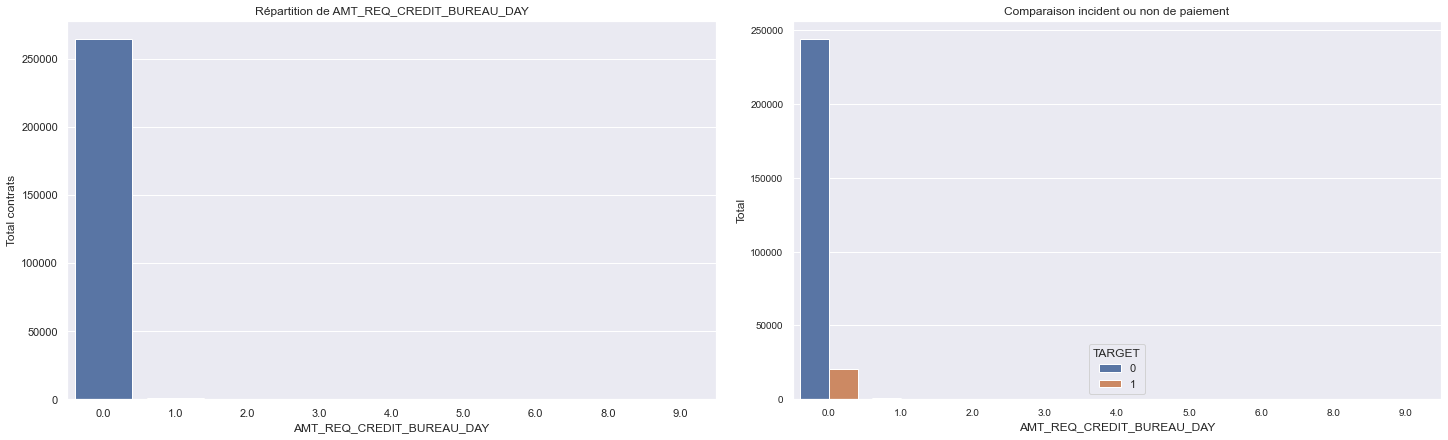

In [98]:
categorical_info(application_train,'AMT_REQ_CREDIT_BUREAU_DAY',label_rotation=0)

In [99]:
percent = (len(application_train[application_train['AMT_REQ_CREDIT_BUREAU_DAY'] == 0]) / application_train.shape[0]) * 100
print(f"{percent:.2f}% demandent des renseignements le jour de leur demande de crédit")


p_count = len(application_train[application_train['AMT_REQ_CREDIT_BUREAU_DAY'] == 4])
p_not = len(application_train[(application_train['AMT_REQ_CREDIT_BUREAU_DAY'] == 4) & (application_train['TARGET'] == 1)]) 
percent = (p_not / p_count) * 100
print(f"{percent:.2f}% des clients demandant des renseignements 4 jours avant ne remboursent pas leur crédit")

p_count = len(application_train[application_train['AMT_REQ_CREDIT_BUREAU_DAY'] == 3])
p_not = len(application_train[(application_train['AMT_REQ_CREDIT_BUREAU_DAY'] == 3) & (application_train['TARGET'] == 1)]) 

percent = (p_not / p_count) * 100
print(f"{percent:.2f}% des clients demandant des renseignements 3 jours avant ne remboursent pas leur crédit")



86.01% demandent des renseignements le jour de leur demande de crédit
11.54% des clients demandant des renseignements 4 jours avant ne remboursent pas leur crédit
4.44% des clients demandant des renseignements 3 jours avant ne remboursent pas leur crédit


Bien que le pluspart des clients le demandent pas de renseigments dans les jours précédent, ceux qui le font ont tendance à ne pas rembourser leur crédit. Il est à noter que si le delai est de trois jours le clients remboursera plus, cela étant dû certainement au week-end 

### AMT_REQ_CREDIT_BUREAU_WEEK
Nombre de demandes de renseignements au bureau de crédit concernant le client une semaine avant la demande (à l'exclusion d'un jour avant la demande)



In [100]:
print(f"{application_train['AMT_REQ_CREDIT_BUREAU_WEEK'].isna().sum()} valeurs manquantes")

41519 valeurs manquantes


In [101]:
application_train['AMT_REQ_CREDIT_BUREAU_WEEK'].value_counts()

0.000    257455
1.000      8208
2.000       199
3.000        58
4.000        34
6.000        20
5.000        10
8.000         5
7.000         2
Name: AMT_REQ_CREDIT_BUREAU_WEEK, dtype: int64

--------------------------
-- AMT_REQ_CREDIT_BUREAU_WEEK --
--------------------------
41519 valeurs manquantes
---------------------------
-2.86% de corrélation entre AMT_REQ_CREDIT_BUREAU_WEEK et TARGET
---------------------------


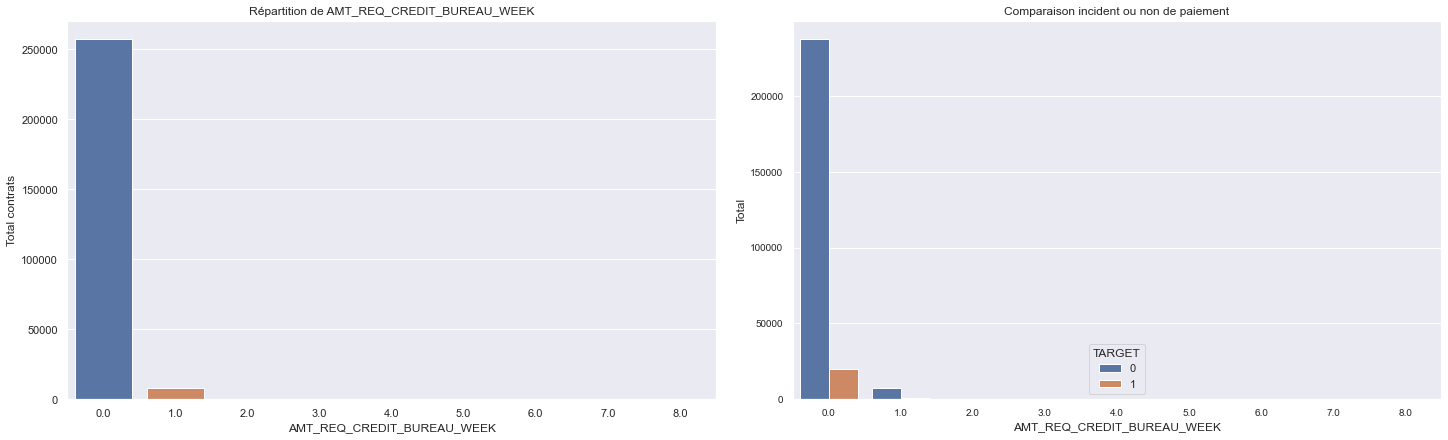

In [102]:
categorical_info(application_train,'AMT_REQ_CREDIT_BUREAU_WEEK',label_rotation=0)

In [103]:
percent = (len(application_train[application_train['AMT_REQ_CREDIT_BUREAU_WEEK'] == 0]) / application_train.shape[0]) * 100
print(f"{percent:.2f}% demandent des renseignements la semaine de leur demande de crédit")


p_count = len(application_train[application_train['AMT_REQ_CREDIT_BUREAU_WEEK'] == 4])
p_not = len(application_train[(application_train['AMT_REQ_CREDIT_BUREAU_WEEK'] == 4) & (application_train['TARGET'] == 1)]) 
percent = (p_not / p_count) * 100
print(f"{percent:.2f}% des clients demandant des renseignements 4 semaines avant ne remboursent pas leur crédit")

p_count = len(application_train[application_train['AMT_REQ_CREDIT_BUREAU_WEEK'] == 2])
p_not = len(application_train[(application_train['AMT_REQ_CREDIT_BUREAU_WEEK'] == 2) & (application_train['TARGET'] == 1)]) 

percent = (p_not / p_count) * 100
print(f"{percent:.2f}% des clients demandant des renseignements 2 semaines avant ne remboursent pas leur crédit")


83.72% demandent des renseignements la semaine de leur demande de crédit
11.76% des clients demandant des renseignements 4 semaines avant ne remboursent pas leur crédit
10.05% des clients demandant des renseignements 2 semaines avant ne remboursent pas leur crédit


Bien que le pluspart des clients le demandent pas de renseigments dans les semaines précédent, ceux qui le font ont tendance à ne pas rembourser leur crédit.

### AMT_REQ_CREDIT_BUREAU_MON
Nombre de demandes de renseignements au bureau de crédit concernant le client un mois avant la demande (à l'exclusion d'une semaine avant la demande)


In [104]:
print(f"{application_train['AMT_REQ_CREDIT_BUREAU_MON'].isna().sum()} valeurs manquantes")

41519 valeurs manquantes


In [105]:
application_train['AMT_REQ_CREDIT_BUREAU_MON'].value_counts()

0.000     222232
1.000      33147
2.000       5386
3.000       1991
4.000       1076
5.000        602
6.000        343
7.000        298
9.000        206
8.000        185
10.000       132
11.000       119
12.000        77
13.000        72
14.000        40
15.000        35
16.000        23
17.000        14
18.000         6
19.000         3
24.000         1
27.000         1
22.000         1
23.000         1
Name: AMT_REQ_CREDIT_BUREAU_MON, dtype: int64

--------------------------
-- AMT_REQ_CREDIT_BUREAU_MON --
--------------------------
41519 valeurs manquantes
---------------------------
-2.50% de corrélation entre AMT_REQ_CREDIT_BUREAU_MON et TARGET
---------------------------


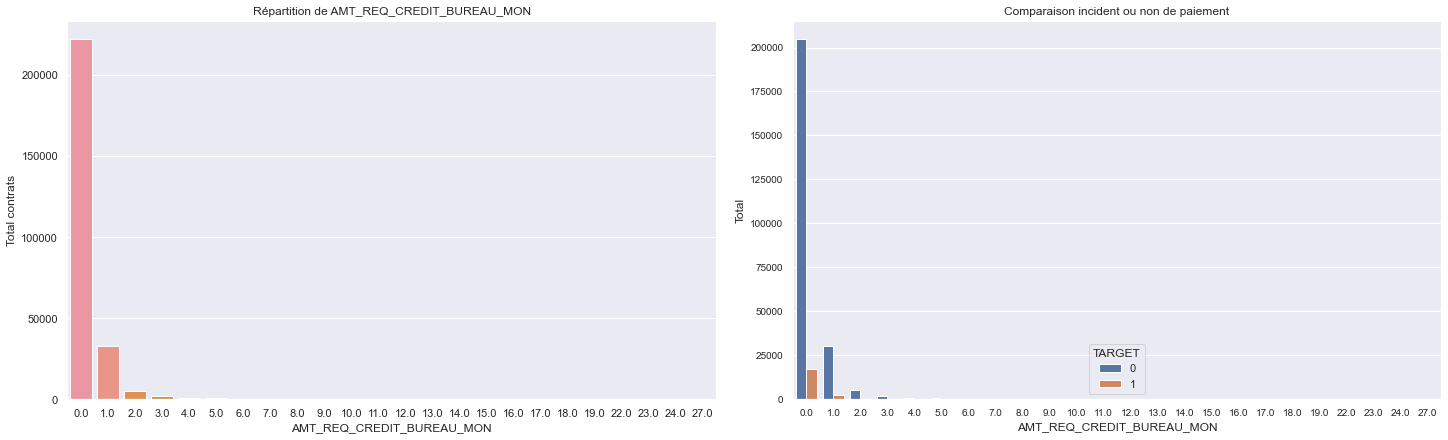

In [106]:
categorical_info(application_train,'AMT_REQ_CREDIT_BUREAU_MON',label_rotation=0)

In [107]:
percent = (len(application_train[application_train['AMT_REQ_CREDIT_BUREAU_MON'] == 0]) / application_train.shape[0]) * 100
print(f"{percent:.2f}% demandent des renseignements le mois de leur demande de crédit")


p_count = len(application_train[application_train['AMT_REQ_CREDIT_BUREAU_MON'] == 10])
p_not = len(application_train[(application_train['AMT_REQ_CREDIT_BUREAU_MON'] == 10) & (application_train['TARGET'] == 1)]) 
percent = (p_not / p_count) * 100
print(f"{percent:.2f}% des clients demandant des renseignements 10 mois  avant ne remboursent pas leur crédit")

p_count = len(application_train[application_train['AMT_REQ_CREDIT_BUREAU_MON'] == 17])
p_not = len(application_train[(application_train['AMT_REQ_CREDIT_BUREAU_MON'] == 17) & (application_train['TARGET'] == 1)]) 

percent = (p_not / p_count) * 100
print(f"{percent:.2f}% des clients demandant des renseignements 17 mois avant ne remboursent pas leur crédit")


72.27% demandent des renseignements le mois de leur demande de crédit
8.33% des clients demandant des renseignements 10 mois  avant ne remboursent pas leur crédit
7.14% des clients demandant des renseignements 17 mois avant ne remboursent pas leur crédit


### AMT_REQ_CREDIT_BUREAU_QRT
Nombre de demandes de renseignements au bureau de crédit concernant le client 3 mois avant la demande (à l'exclusion d'un mois avant la demande)


In [108]:
print(f"{application_train['AMT_REQ_CREDIT_BUREAU_QRT'].isna().sum()} valeurs manquantes")

41519 valeurs manquantes


In [109]:
application_train['AMT_REQ_CREDIT_BUREAU_QRT'].value_counts()

0.000      215416
1.000       33862
2.000       14412
3.000        1717
4.000         476
5.000          64
6.000          28
7.000           7
8.000           7
19.000          1
261.000         1
Name: AMT_REQ_CREDIT_BUREAU_QRT, dtype: int64

--------------------------
-- AMT_REQ_CREDIT_BUREAU_QRT --
--------------------------
41519 valeurs manquantes
---------------------------
-2.16% de corrélation entre AMT_REQ_CREDIT_BUREAU_QRT et TARGET
---------------------------


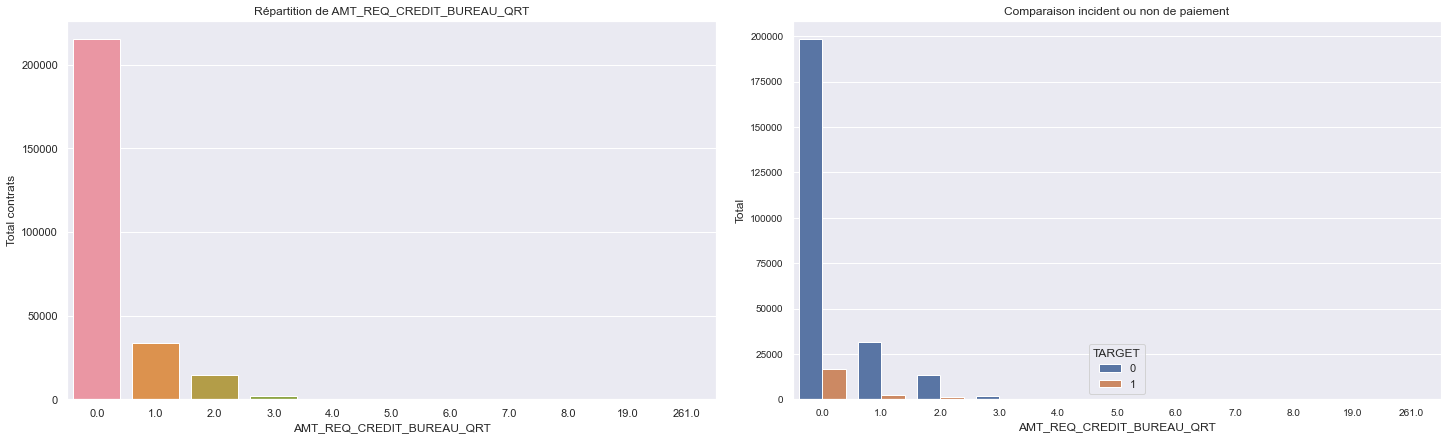

In [110]:
categorical_info(application_train,'AMT_REQ_CREDIT_BUREAU_QRT',label_rotation=0)

In [111]:
percent = (len(application_train[application_train['AMT_REQ_CREDIT_BUREAU_QRT'] == 0]) / application_train.shape[0]) * 100
print(f"{percent:.2f}% demandent des renseigments dans le trimestre de la demande de crédit")

p_count = len(application_train[application_train['AMT_REQ_CREDIT_BUREAU_QRT'] == 6])
p_not = len(application_train[(application_train['AMT_REQ_CREDIT_BUREAU_QRT'] == 6) & (application_train['TARGET'] == 1)]) 

percent = (p_not / p_count) * 100
print(f"{percent:.2f}% des clients demandant des renseignement 6 trimestres (1,5 ans) avant ne remboursent pas leur crédit")

p_count = len(application_train[application_train['AMT_REQ_CREDIT_BUREAU_QRT'] == 19])
p_not = len(application_train[(application_train['AMT_REQ_CREDIT_BUREAU_QRT'] == 19) & (application_train['TARGET'] == 1)]) 

percent = (p_not / p_count) * 100
print(f"{percent:.2f}% des clients demandant des renseignement 19 trimestres (4,5 ans) avant ne remboursent pas leur crédit")

70.05% demandent des renseigments dans le trimestre de la demande de crédit
25.00% des clients demandant des renseignement 6 trimestres (1,5 ans) avant ne remboursent pas leur crédit
100.00% des clients demandant des renseignement 19 trimestres (4,5 ans) avant ne remboursent pas leur crédit


### AMT_REQ_CREDIT_BUREAU_YEAR
Nombre de demandes de renseignements au bureau de crédit concernant le client un jour par an (à l'exclusion des 3 derniers mois avant la demande)

In [112]:
print(f"{application_train['AMT_REQ_CREDIT_BUREAU_YEAR'].isna().sum()} valeurs manquantes")

41519 valeurs manquantes


In [113]:
application_train['AMT_REQ_CREDIT_BUREAU_YEAR'].value_counts()

0.000     71801
1.000     63404
2.000     50192
3.000     33628
4.000     20714
5.000     12052
6.000      6967
7.000      3869
8.000      2127
9.000      1096
11.000       31
12.000       30
10.000       22
13.000       19
14.000       10
17.000        7
15.000        6
19.000        4
18.000        4
16.000        3
21.000        1
23.000        1
25.000        1
20.000        1
22.000        1
Name: AMT_REQ_CREDIT_BUREAU_YEAR, dtype: int64

--------------------------
-- AMT_REQ_CREDIT_BUREAU_YEAR --
--------------------------
41519 valeurs manquantes
---------------------------
-0.05% de corrélation entre AMT_REQ_CREDIT_BUREAU_YEAR et TARGET
---------------------------


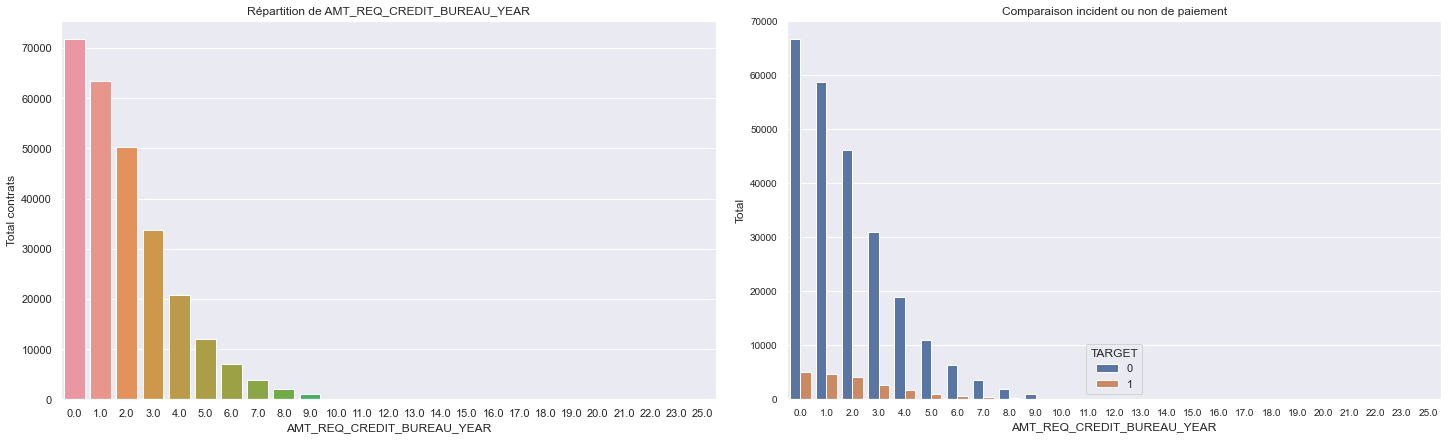

In [114]:
categorical_info(application_train,'AMT_REQ_CREDIT_BUREAU_YEAR',label_rotation=0)

In [115]:
percent = (len(application_train[application_train['AMT_REQ_CREDIT_BUREAU_YEAR'] == 0]) / application_train.shape[0]) * 100
print(f"{percent:.2f}% demandent des renseigments dans l'année de la demande de crédit")

p_count = len(application_train[application_train['AMT_REQ_CREDIT_BUREAU_YEAR'] == 14])
p_not = len(application_train[(application_train['AMT_REQ_CREDIT_BUREAU_YEAR'] == 14) & (application_train['TARGET'] == 1)]) 

percent = (p_not / p_count) * 100
print(f"{percent:.2f}% des clients demandant des renseignement 14 ans avant ne remboursent pas leur crédit")

p_count = len(application_train[application_train['AMT_REQ_CREDIT_BUREAU_YEAR'] == 22])
p_not = len(application_train[(application_train['AMT_REQ_CREDIT_BUREAU_YEAR'] == 22) & (application_train['TARGET'] == 1)]) 

percent = (p_not / p_count) * 100
print(f"{percent:.2f}% des clients demandant des renseignement 22 ans avant ne remboursent pas leur crédit")

23.35% demandent des renseigments dans l'année de la demande de crédit
30.00% des clients demandant des renseignement 14 ans avant ne remboursent pas leur crédit
100.00% des clients demandant des renseignement 22 ans avant ne remboursent pas leur crédit


Une grande majorité de clients demandent des renseignements dans les 4 ans précédent leur demande de crédit.
Cependant, c'est dans la même année de la demande de crédit qu'ils font une ou des demandes de renseignements

### CNT_CHILDREN
Nombre d'enfants que le client a

--------------------------
-- CNT_CHILDREN         --
--------------------------
0 valeurs manquantes
---------------------------
1.92% de corrélation entre CNT_CHILDREN et TARGET
---------------------------


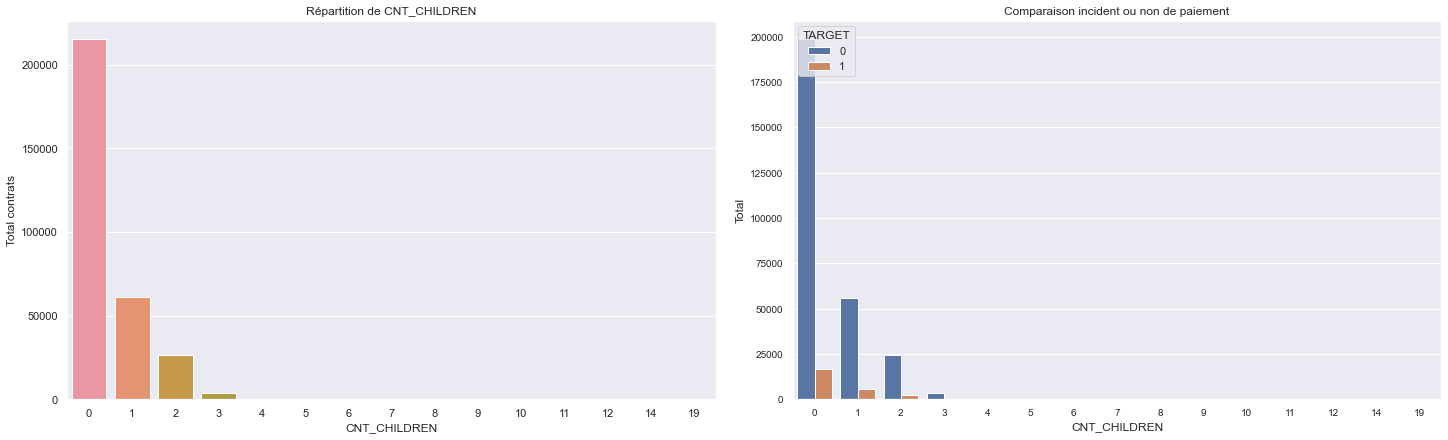

0 valeurs manquantes
70.04% des clients n'ont pas d'enfant
100.00% des clients qui ont 9 enfants ne remboursent pas leur crédit
100.00% des clients qui ont 11 enfants ne remboursent pas leur crédit
28.57% des clients qui ont 6 enfants ne remboursent pas leur crédit


In [116]:
categorical_info(application_train,'CNT_CHILDREN',label_rotation=0)

print(f"{application_train['CNT_CHILDREN'].isna().sum()} valeurs manquantes")

percent = (len(application_train[application_train['CNT_CHILDREN'] == 0]) / application_train.shape[0]) * 100
print(f"{percent:.2f}% des clients n'ont pas d'enfant")

p_count = len(application_train[application_train['CNT_CHILDREN'] == 9])
p_not = len(application_train[(application_train['CNT_CHILDREN'] == 9) & (application_train['TARGET'] == 1)]) 

percent = (p_not / p_count) * 100
print(f"{percent:.2f}% des clients qui ont 9 enfants ne remboursent pas leur crédit")

p_count = len(application_train[application_train['CNT_CHILDREN'] == 11])
p_not = len(application_train[(application_train['CNT_CHILDREN'] == 11) & (application_train['TARGET'] == 1)]) 

percent = (p_not / p_count) * 100
print(f"{percent:.2f}% des clients qui ont 11 enfants ne remboursent pas leur crédit")

p_count = len(application_train[application_train['CNT_CHILDREN'] == 6])
p_not = len(application_train[(application_train['CNT_CHILDREN'] == 6) & (application_train['TARGET'] == 1)]) 

percent = (p_not / p_count) * 100
print(f"{percent:.2f}% des clients qui ont 6 enfants ne remboursent pas leur crédit")



la Grande majorité n'a pas d'enfant lorsqu'il contracte un prêt. Les clients ayant 9 ou 11 enfants ne reboursent jamais leur crédit.

### REGION_POPULATION_RELATIVE
Population normalisée de la région où vit le client (un nombre plus élevé signifie que le client vit dans une région plus peuplée)


0 valeurs manquantes
----------------------
Asymetrie : 1.4879963397979736
LOG - Asymetrie : 1.4275943040847778
SQR - Asymetrie : 0.4436822235584259
----------------------
Corrélation de -3.72% entre REGION_POPULATION_RELATIVE et TARGET
----------------------
count   307510.000
mean         0.021
std          0.014
min          0.000
25%          0.010
50%          0.019
75%          0.029
max          0.073
Name: REGION_POPULATION_RELATIVE, dtype: float64


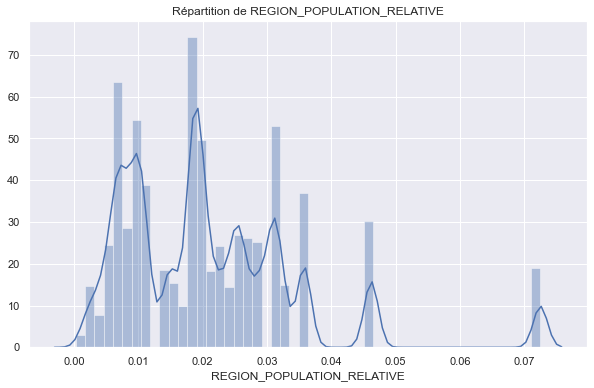

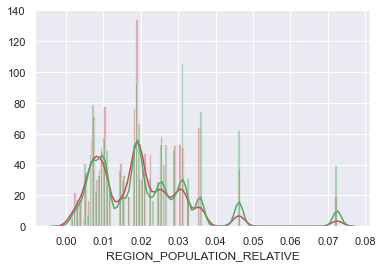

In [117]:
show_numerical(application_train, 'REGION_POPULATION_RELATIVE')

In [118]:
application_train[application_train['REGION_POPULATION_RELATIVE'] > 0.029]

p_count = len(application_train[application_train['AMT_REQ_CREDIT_BUREAU_HOUR'] > 0.029])
p_not = len(application_train[(application_train['AMT_REQ_CREDIT_BUREAU_HOUR']  > 0.029) & (application_train['TARGET'] == 1)]) 

percent = (p_not / p_count) * 100
print(f"{percent:.2f}% des clients vivant dans une zone peuplée ne remboursent pas leur crédit")


8.06% des clients vivant dans une zone peuplée ne remboursent pas leur crédit


La pluspart des clients vivent dans des regions peu peuplées.

### DAYS_BIRTH
Âge du client en jours au moment de la demande


0 valeurs manquantes
----------------------
Asymetrie : -0.11566682431991283
LOG - Asymetrie : -0.30078554153442383
SQR - Asymetrie : -0.08618061244487762
----------------------
Corrélation de 7.82% entre DAYS_BIRTH et TARGET
----------------------
count   307510.000
mean    -16037.006
std       4363.991
min     -25229.000
25%     -19682.000
50%     -15750.000
75%     -12413.000
max      -7489.000
Name: DAYS_BIRTH, dtype: float64


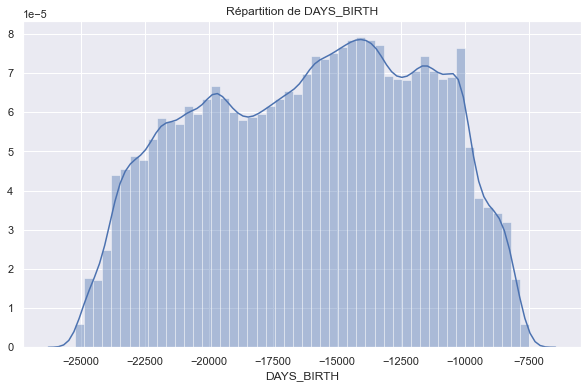

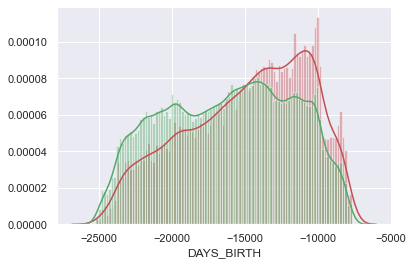

In [119]:
show_numerical(application_train, 'DAYS_BIRTH')

Si l'on converti le n° de jours en années 

0 valeurs manquantes
----------------------
Asymetrie : 0.11566682431991647
LOG - Asymetrie : -0.2896848928998805
SQR - Asymetrie : -0.08617762380742787
----------------------
Corrélation de -7.82% entre YEARS_BIRTH et TARGET
----------------------
count   307510.000
mean        43.907
std         11.948
min         20.504
25%         33.985
50%         43.121
75%         53.886
max         69.073
Name: YEARS_BIRTH, dtype: float64


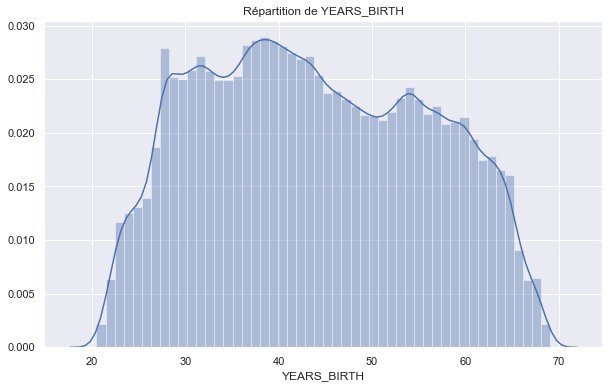

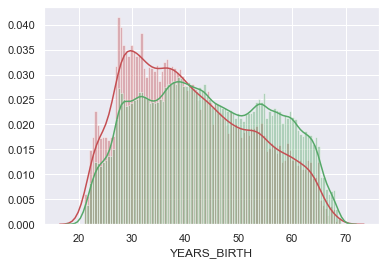

In [120]:
application_train['YEARS_BIRTH'] = abs(application_train['DAYS_BIRTH']) / 365.25
application_train = application_train.drop('DAYS_BIRTH', axis=1)
show_numerical(application_train, 'YEARS_BIRTH')

Les clients ont entre 20 ans et 70 ans et la moyenne se situe autour de 43 ans. Les clients jeunes (25-30 ans) auront plus tendance à ne pas rembourser leur crédit au contraire des plus âgés (55-65 ans) 

### DAYS_EMPLOYED
Combien de jours avant la demande la personne a-t-elle commencé son emploi actuel


0 valeurs manquantes
----------------------
Asymetrie : 1.6643329206120319
LOG - Asymetrie : 1.0076693413499278
SQR - Asymetrie : 1.634151112666167
----------------------
Corrélation de -4.49% entre DAYS_EMPLOYED et TARGET
----------------------
count   307510.000
mean     63815.256
std     141275.948
min     -17912.000
25%      -2760.000
50%      -1213.500
75%       -289.000
max     365243.000
Name: DAYS_EMPLOYED, dtype: float64


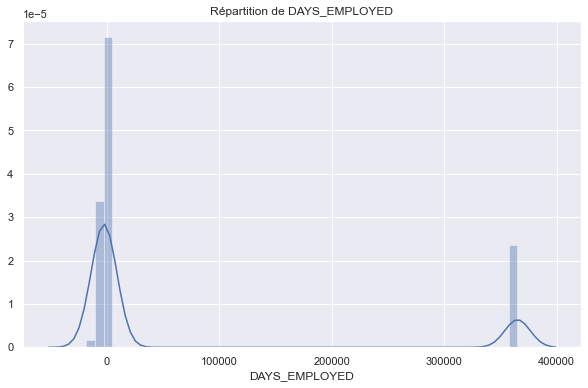

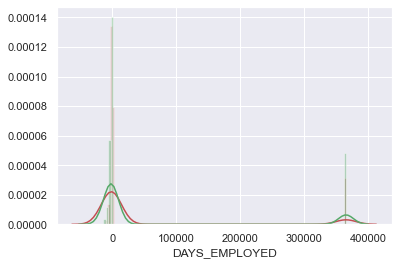

In [121]:
show_numerical(application_train, 'DAYS_EMPLOYED')

On remarquera que la valeur maximale est de 365243 jours, ce qui converti en années donne 999,99 ans. Il font donc considérer cette valeur comme une valeur nulle.

In [122]:
application_train['DAYS_EMPLOYED']  = application_train['DAYS_EMPLOYED'].replace([365243],np.NaN)               

55374 valeurs manquantes
----------------------
Asymetrie : 1.968298026173097
LOG - Asymetrie : 0.12281214216454443
SQR - Asymetrie : 0.784870147636049
----------------------
Corrélation de -7.50% entre YEARS_EMPLOYED et TARGET
----------------------
count   252136.000
mean         6.528
std          6.402
min          0.000
25%          2.100
50%          4.512
75%          8.693
max         49.040
Name: YEARS_EMPLOYED, dtype: float64


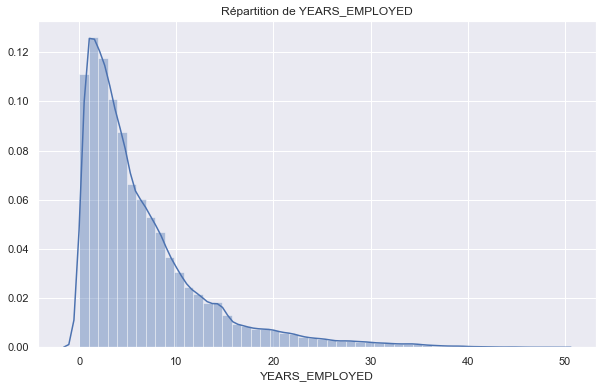

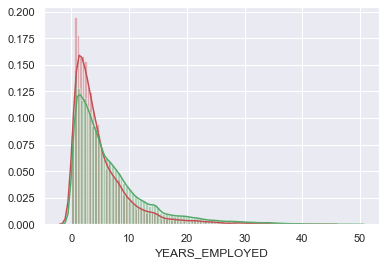

In [123]:
application_train['YEARS_EMPLOYED'] = abs(application_train['DAYS_EMPLOYED']) / 365.25
show_numerical(application_train, 'YEARS_EMPLOYED')

Dans les premières années de travail, les crédits seront plus suceptibles de ne pas être remboursés

### DAYS_REGISTRATION
Combien de jours avant la demande le client a-t-il modifié son inscription



0 valeurs manquantes
----------------------
Asymetrie : -0.5908732414245605
LOG - Asymetrie : -1.7706806659698486
SQR - Asymetrie : -0.17958839237689972
----------------------
Corrélation de 4.20% entre DAYS_REGISTRATION et TARGET
----------------------
count   307510.000
mean     -4986.114
std       3522.891
min     -24672.000
25%      -7479.750
50%      -4504.000
75%      -2010.000
max          0.000
Name: DAYS_REGISTRATION, dtype: float64


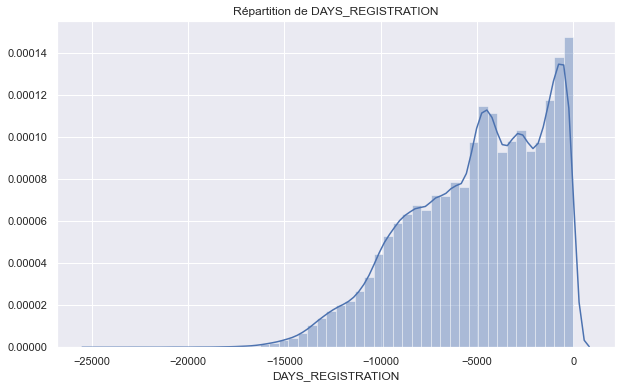

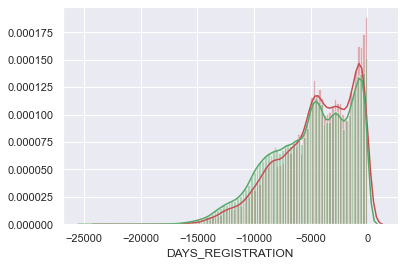

In [124]:
show_numerical(application_train, 'DAYS_REGISTRATION')

In [125]:
print(f"Un client modifie son inscription entre 0 et {abs(application_train['DAYS_REGISTRATION'].min()) / 365.25:.0f} années")
print(f"Les clients modifient leur inscription en moyenne {abs(application_train['DAYS_REGISTRATION'].mean()) / 365.25:.0f} années avant la demande de crédit")

Un client modifie son inscription entre 0 et 68 années
Les clients modifient leur inscription en moyenne 14 années avant la demande de crédit


In [126]:
application_train['YEARS_REGISTRATION'] = abs(application_train['DAYS_REGISTRATION']) / 365.25
application_train = application_train.drop('DAYS_REGISTRATION', axis=1)

0 valeurs manquantes
----------------------
Asymetrie : 0.5908731818199158
LOG - Asymetrie : -0.7883039712905884
SQR - Asymetrie : -0.17958715558052063
----------------------
Corrélation de -4.20% entre YEARS_REGISTRATION et TARGET
----------------------
count   307510.000
mean        13.651
std          9.645
min          0.000
25%          5.503
50%         12.331
75%         20.478
max         67.548
Name: YEARS_REGISTRATION, dtype: float64


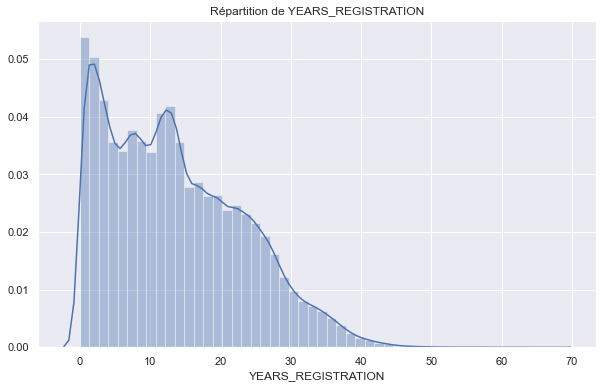

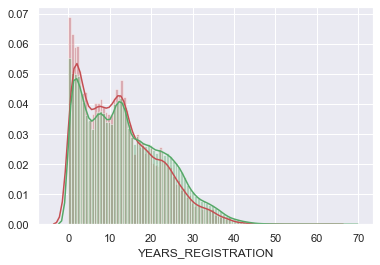

In [127]:
show_numerical(application_train, 'YEARS_REGISTRATION')

Si le client modifie son inscription dans les 10 jours il est possible qu'il ne rembourse pas sont crédit, alors que s'il fait une modification après 20 jours il sera plus enclin à rembourser.

### DAYS_ID_PUBLISH
Combien de jours avant la demande le client a-t-il modifié le document d'identité avec lequel il avait demandé le prêt


0 valeurs manquantes
----------------------
Asymetrie : 0.34932160100873205
LOG - Asymetrie : -2.3723537921905518
SQR - Asymetrie : -0.88348788022995
----------------------
Corrélation de 5.15% entre DAYS_ID_PUBLISH et TARGET
----------------------
count   307510.000
mean     -2994.200
std       1509.452
min      -7197.000
25%      -4299.000
50%      -3254.000
75%      -1720.000
max          0.000
Name: DAYS_ID_PUBLISH, dtype: float64


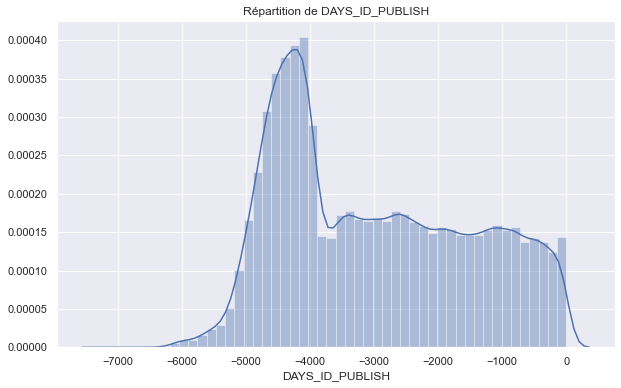

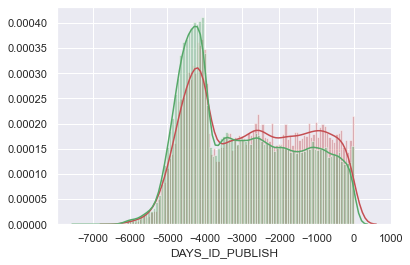

In [128]:
show_numerical(application_train, 'DAYS_ID_PUBLISH')

In [129]:
print(f"Un client modifie son document d'identité entre 0 et {abs(application_train['DAYS_ID_PUBLISH'].min()) / 365.25:.0f} années avant la demande de prêt")
print(f"Les clients modifient leur document d'identité en moyenne {abs(application_train['DAYS_ID_PUBLISH'].mean()) / 365.25:.0f} années avant la demande de crédit")

Un client modifie son document d'identité entre 0 et 20 années avant la demande de prêt
Les clients modifient leur document d'identité en moyenne 8 années avant la demande de crédit


In [130]:
application_train['YEARS_ID_PUBLISH'] = abs(application_train['DAYS_ID_PUBLISH']) / 365.25
application_train = application_train.drop('DAYS_ID_PUBLISH', axis=1)

0 valeurs manquantes
----------------------
Asymetrie : -0.3493216010087302
LOG - Asymetrie : -1.2350914441977618
SQR - Asymetrie : -0.8834868157072809
----------------------
Corrélation de -5.15% entre YEARS_ID_PUBLISH et TARGET
----------------------
count   307510.000
mean         8.198
std          4.133
min          0.000
25%          4.709
50%          8.909
75%         11.770
max         19.704
Name: YEARS_ID_PUBLISH, dtype: float64


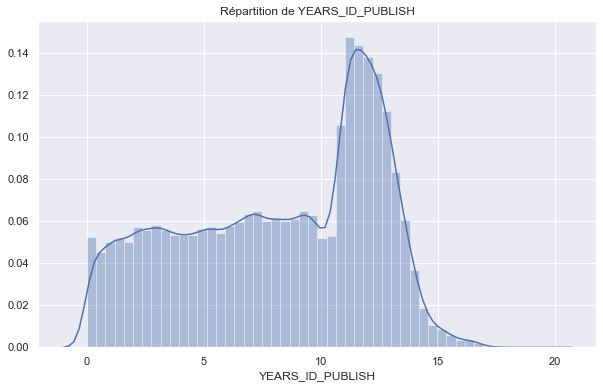

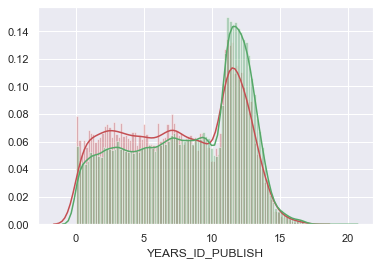

In [131]:
show_numerical(application_train, 'YEARS_ID_PUBLISH')

les clients qui modifie leur documents d'identitée dans les premières années auront tendance à ne pas rembourser leut crédir à contrario de ceux l'ayant fait bien des années plus tard.

### OWN_CAR_AGE
Âge de la voiture du client

202928 valeurs manquantes
----------------------
Asymetrie : 2.745382308959961
LOG - Asymetrie : -0.29713961482048035
SQR - Asymetrie : 0.9177303910255432
----------------------
Corrélation de 3.76% entre OWN_CAR_AGE et TARGET
----------------------
count   104582.000
mean        12.061
std         11.945
min          0.000
25%          5.000
50%          9.000
75%         15.000
max         91.000
Name: OWN_CAR_AGE, dtype: float64


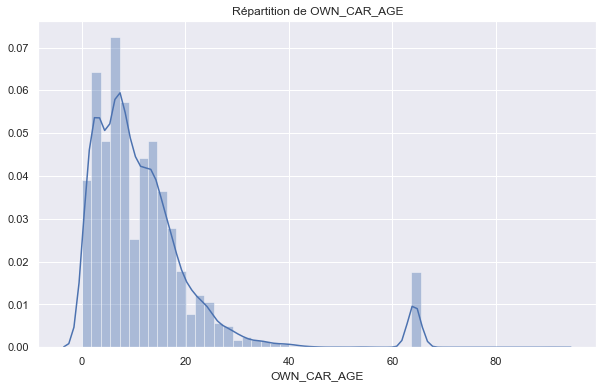

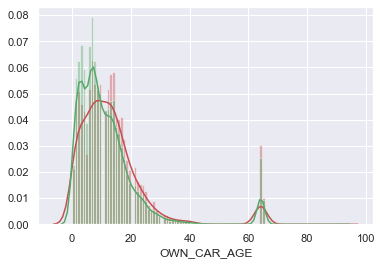

In [132]:
show_numerical(application_train, 'OWN_CAR_AGE')

L'année du véhicule ne semble pas trop entrer en ligne de compte du remboursement ou non du prêt. Il y des véhicules de plus de 80 ans d'age et l'on peut supposer que ces clients sont des collectioneurs

### CNT_FAM_MEMBERS
Combien de membres de la famille le client a-t-il


2 valeurs manquantes
----------------------
Asymetrie : 0.9875467419624329
LOG - Asymetrie : 0.1289137899875641
SQR - Asymetrie : 0.32805174589157104
----------------------
Corrélation de 0.93% entre CNT_FAM_MEMBERS et TARGET
----------------------
count   307508.000
mean         2.153
std          0.911
min          1.000
25%          2.000
50%          2.000
75%          3.000
max         20.000
Name: CNT_FAM_MEMBERS, dtype: float64


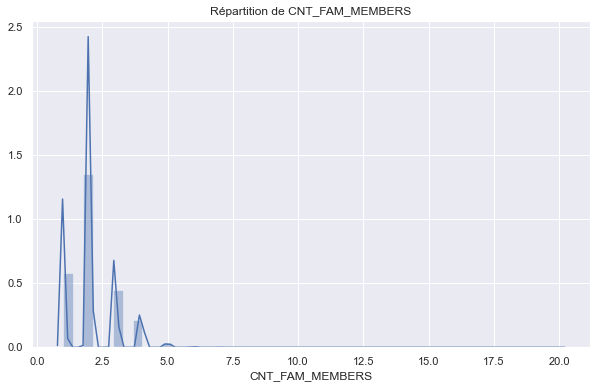

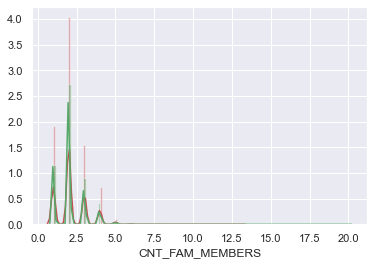

In [133]:
show_numerical(application_train, 'CNT_FAM_MEMBERS')

In [134]:
percent = (len(application_train[application_train['CNT_FAM_MEMBERS'] == 2]) / application_train.shape[0]) * 100
print(f"{percent:.2f}% des clients sont 2 personnes")

p_count = len(application_train[application_train['CNT_FAM_MEMBERS'] == 13])
p_not = len(application_train[(application_train['CNT_FAM_MEMBERS'] == 13) & (application_train['TARGET'] == 1)]) 

percent = (p_not / p_count) * 100
print(f"{percent:.2f}% des clients qui sont 13 ne remboursent pas leur crédit")

p_count = len(application_train[application_train['CNT_FAM_MEMBERS'] == 11])
p_not = len(application_train[(application_train['CNT_FAM_MEMBERS'] == 11) & (application_train['TARGET'] == 1)]) 

percent = (p_not / p_count) * 100
print(f"{percent:.2f}% des clients qui sont 11 ne remboursent pas leur crédit")

p_count = len(application_train[application_train['CNT_FAM_MEMBERS'] == 8])
p_not = len(application_train[(application_train['CNT_FAM_MEMBERS'] == 8) & (application_train['TARGET'] == 1)]) 

percent = (p_not / p_count) * 100
print(f"{percent:.2f}% des clients qui sont 8 ne remboursent pas leur crédit")


51.50% des clients sont 2 personnes
100.00% des clients qui sont 13 ne remboursent pas leur crédit
100.00% des clients qui sont 11 ne remboursent pas leur crédit
30.00% des clients qui sont 8 ne remboursent pas leur crédit


La pluspart des clients sont en couple (en fin 2 personnes). Comme pour les données sur le nombre d'enfants on retrouve le non recouvrement de la créance pour les familles de 11 (2 + 9) et 13 personnes (2 + 11).

In [135]:
application_train[application_train['CNT_FAM_MEMBERS'].isnull()]

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
41982       148605       0    Revolving loans           M            N   
187348      317181       0    Revolving loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
41982                Y             0        450000.000  675000.000   
187348               Y             0        202500.000  585000.000   

        AMT_ANNUITY  ...  AMT_REQ_CREDIT_BUREAU_DAY  \
41982     33750.000  ...                        nan   
187348    29250.000  ...                      0.000   

       AMT_REQ_CREDIT_BUREAU_WEEK AMT_REQ_CREDIT_BUREAU_MON  \
41982                         nan                       nan   
187348                      0.000                     0.000   

       AMT_REQ_CREDIT_BUREAU_QRT AMT_REQ_CREDIT_BUREAU_YEAR CORR  YEARS_BIRTH  \
41982                        nan                        nan    0       33.938   
187348                     0.000                      1.000    0       35.165   

        YEARS_EMPLOYED  YEARS_REGISTRATION  YEARS_ID_PUBLISH  
41982            3.179               8.939            12.290  
187348           0.635               4.372             4.301  

[2 rows x 124 columns]

### REGION_RATING_CLIENT
Évaluation de la région où vit le client (1,2,3)

--------------------------
-- REGION_RATING_CLIENT --
--------------------------
0 valeurs manquantes
---------------------------
5.89% de corrélation entre REGION_RATING_CLIENT et TARGET
---------------------------


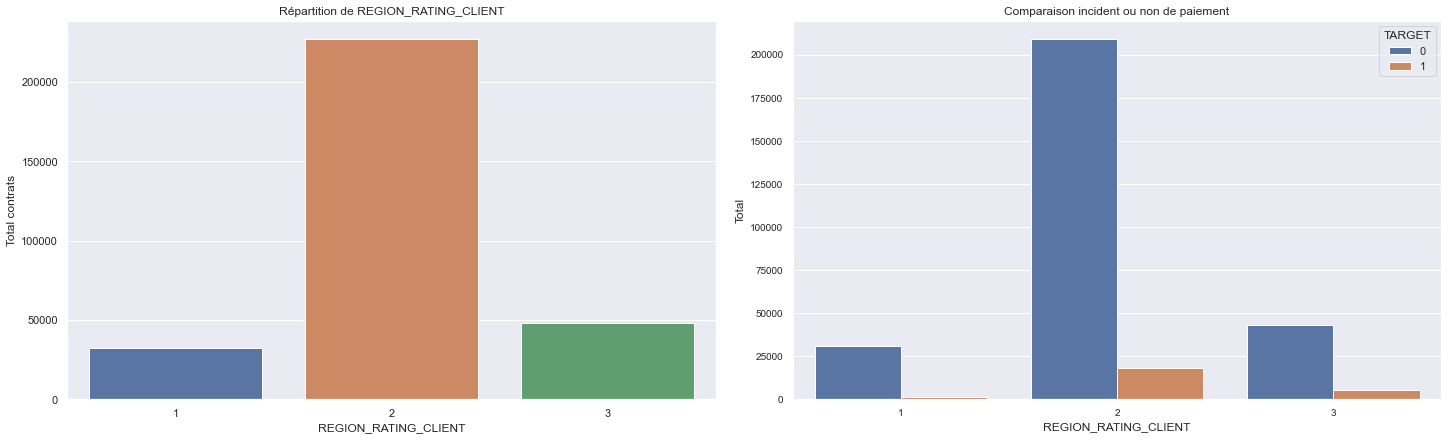

0 valeurs manquantes
73.81% des clients ont un score de 2
11.10% des clients qui ont un score de 3 ne remboursent pas leur crédit
4.82% des clients qui ont un score de 1 ne remboursent pas leur crédit


In [136]:
categorical_info(application_train,'REGION_RATING_CLIENT',label_rotation=0)

print(f"{application_train['REGION_RATING_CLIENT'].isna().sum()} valeurs manquantes")

percent = (len(application_train[application_train['REGION_RATING_CLIENT'] == 2]) / application_train.shape[0]) * 100
print(f"{percent:.2f}% des clients ont un score de 2")

p_count = len(application_train[application_train['REGION_RATING_CLIENT'] == 3])
p_not = len(application_train[(application_train['REGION_RATING_CLIENT'] == 3) & (application_train['TARGET'] == 1)]) 

percent = (p_not / p_count) * 100
print(f"{percent:.2f}% des clients qui ont un score de 3 ne remboursent pas leur crédit")


p_count = len(application_train[application_train['REGION_RATING_CLIENT'] == 1])
p_not = len(application_train[(application_train['REGION_RATING_CLIENT'] == 1) & (application_train['TARGET'] == 1)]) 

percent = (p_not / p_count) * 100
print(f"{percent:.2f}% des clients qui ont un score de 1 ne remboursent pas leur crédit")

1. ### REGION_RATING_CLIENT_W_CITY
Évaluation de la région où vit le client avec prise en compte de la ville (1,2,3)

--------------------------
-- REGION_RATING_CLIENT_W_CITY --
--------------------------
0 valeurs manquantes
---------------------------
6.09% de corrélation entre REGION_RATING_CLIENT_W_CITY et TARGET
---------------------------


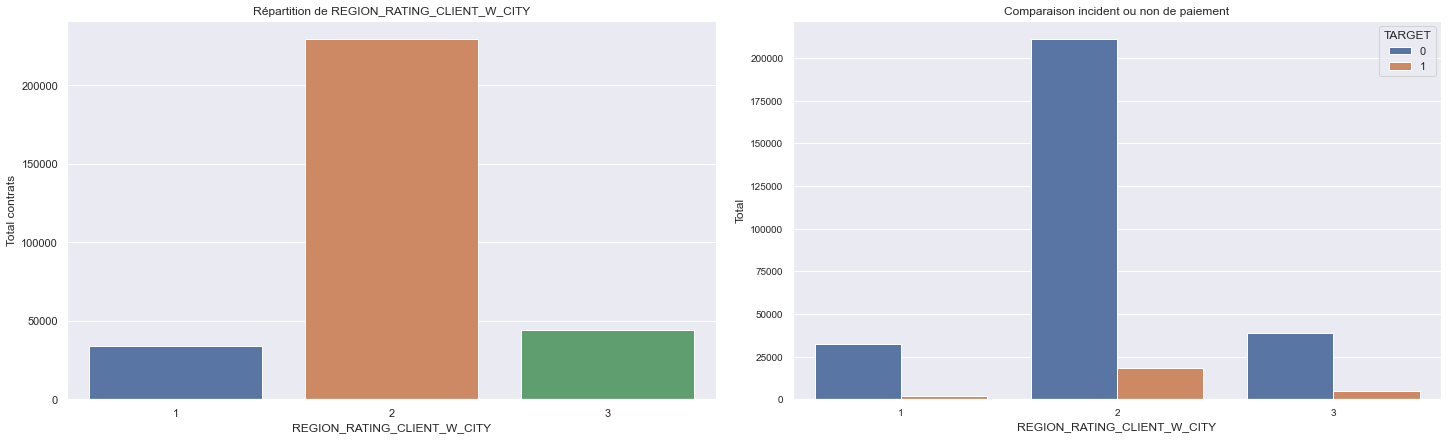

0 valeurs manquantes
74.63% des clients ont un score de 2
11.40% des clients qui ont un score de 3 ne remboursent pas leur crédit
4.84% des clients qui ont un score de 1 ne remboursent pas leur crédit


In [137]:
categorical_info(application_train,'REGION_RATING_CLIENT_W_CITY',label_rotation=0)

print(f"{application_train['REGION_RATING_CLIENT_W_CITY'].isna().sum()} valeurs manquantes")

percent = (len(application_train[application_train['REGION_RATING_CLIENT_W_CITY'] == 2]) / application_train.shape[0]) * 100
print(f"{percent:.2f}% des clients ont un score de 2")

p_count = len(application_train[application_train['REGION_RATING_CLIENT_W_CITY'] == 3])
p_not = len(application_train[(application_train['REGION_RATING_CLIENT_W_CITY'] == 3) & (application_train['TARGET'] == 1)]) 

percent = (p_not / p_count) * 100
print(f"{percent:.2f}% des clients qui ont un score de 3 ne remboursent pas leur crédit")


p_count = len(application_train[application_train['REGION_RATING_CLIENT_W_CITY'] == 1])
p_not = len(application_train[(application_train['REGION_RATING_CLIENT_W_CITY'] == 1) & (application_train['TARGET'] == 1)]) 

percent = (p_not / p_count) * 100
print(f"{percent:.2f}% des clients qui ont un score de 1 ne remboursent pas leur crédit")

La classement des villes et le région du client sont assez proches

### HOUR_APPR_PROCESS_START
À quelle heure environ le client a-t-il fait sa demande de prêt


In [138]:
print(f"{application_train['HOUR_APPR_PROCESS_START'].isna().sum()} valeurs manquantes")

0 valeurs manquantes


In [139]:
application_train['HOUR_APPR_PROCESS_START'].value_counts()

10    37722
11    37229
12    34233
13    30959
14    27681
9     27384
15    24839
16    20385
8     15127
17    14900
7      9131
18     9049
6      5842
19     3848
5      3638
4      2090
3      1230
20     1196
21      405
2       305
22      150
1        86
23       41
0        40
Name: HOUR_APPR_PROCESS_START, dtype: int64

--------------------------
-- HOUR_APPR_PROCESS_START --
--------------------------
0 valeurs manquantes
---------------------------
-2.42% de corrélation entre HOUR_APPR_PROCESS_START et TARGET
---------------------------


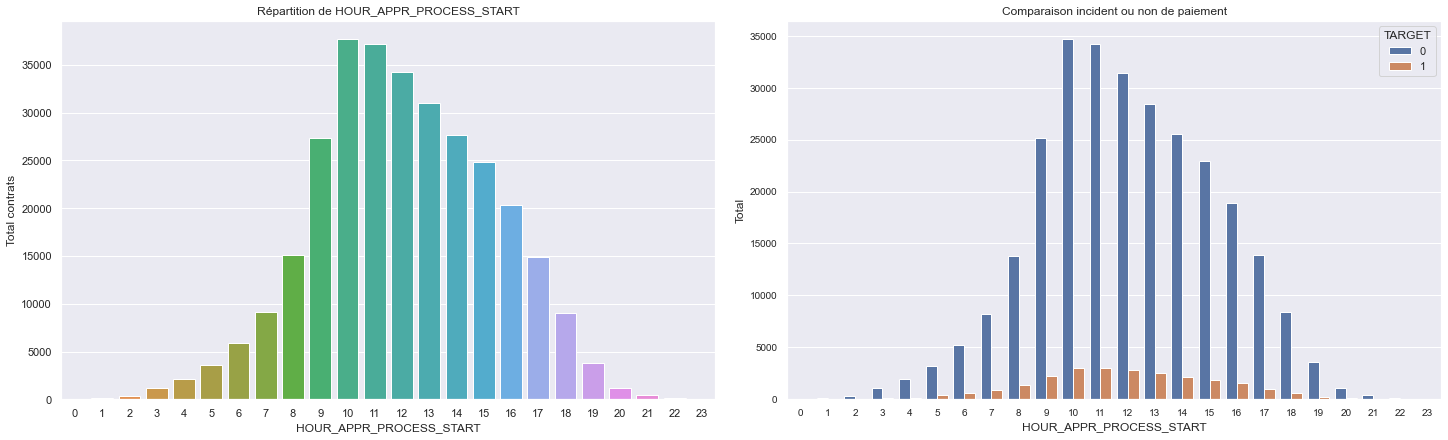

In [140]:
categorical_info(application_train,'HOUR_APPR_PROCESS_START',label_rotation=0)

In [141]:
p_count = len(application_train[application_train['HOUR_APPR_PROCESS_START'] == 23])
p_not = len(application_train[(application_train['HOUR_APPR_PROCESS_START'] == 23) & (application_train['TARGET'] == 1)]) 
percent = (p_not / p_count) * 100
print(f"{percent:.2f}% des clients qui font leur demande à 23h00 ne remboursent pas leur crédit")

p_count = len(application_train[application_train['HOUR_APPR_PROCESS_START'] == 0])
p_not = len(application_train[(application_train['HOUR_APPR_PROCESS_START'] == 0) & (application_train['TARGET'] == 1)]) 
percent = (p_not / p_count) * 100
print(f"{percent:.2f}% des clients qui font leur demande à minuit ne remboursent pas leur crédit")

12.20% des clients qui font leur demande à 23h00 ne remboursent pas leur crédit
15.00% des clients qui font leur demande à minuit ne remboursent pas leur crédit


On remarquera que les client qui appellent au environs de minuit sont ceux les plus suseptibles de ne pas rembourser leur crédit.

In [142]:
application_train['WEEKDAY_APPR_PROCESS_START']

0         WEDNESDAY
1            MONDAY
2            MONDAY
3         WEDNESDAY
4          THURSDAY
            ...    
307506     THURSDAY
307507       MONDAY
307508     THURSDAY
307509    WEDNESDAY
307510     THURSDAY
Name: WEEKDAY_APPR_PROCESS_START, Length: 307510, dtype: category
Categories (7, object): [FRIDAY, MONDAY, SATURDAY, SUNDAY, THURSDAY, TUESDAY, WEDNESDAY]

### REG_REGION_NOT_LIVE_REGION
Signaler si l'adresse permanente du client ne correspond pas à l'adresse de contact (1=différent, 0=même au niveau de la région)



--------------------------
-- REG_REGION_NOT_LIVE_REGION --
--------------------------
0 valeurs manquantes
---------------------------
0.56% de corrélation entre REG_REGION_NOT_LIVE_REGION et TARGET
---------------------------


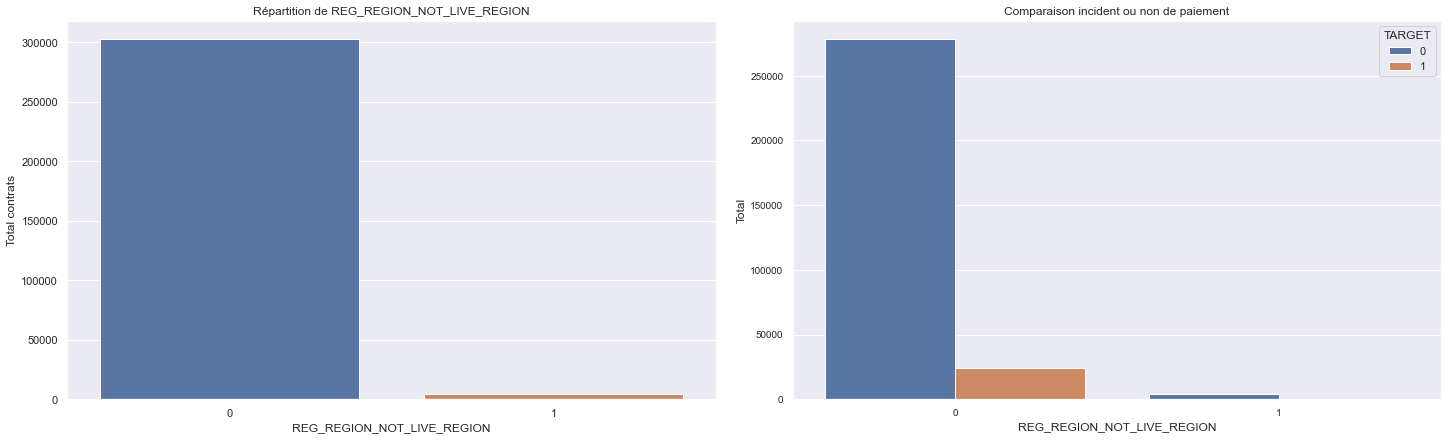

0 valeurs manquantes
1.51% des clients ont une adresse permanente dans une autre région que leur adresse de contact
9.30% des clients ont une adresse permanente dans une autre région que leur adresse de contact ne remboursent pas leur crédit


In [143]:
categorical_info(application_train,'REG_REGION_NOT_LIVE_REGION',label_rotation=0)

print(f"{application_train['REG_REGION_NOT_LIVE_REGION'].isna().sum()} valeurs manquantes")

percent = (len(application_train[application_train['REG_REGION_NOT_LIVE_REGION'] == 1]) / application_train.shape[0]) * 100
print(f"{percent:.2f}% des clients ont une adresse permanente dans une autre région que leur adresse de contact")

p_count = len(application_train[application_train['REG_REGION_NOT_LIVE_REGION'] == 1])
p_not = len(application_train[(application_train['REG_REGION_NOT_LIVE_REGION'] == 1) & (application_train['TARGET'] == 1)]) 

percent = (p_not / p_count) * 100
print(f"{percent:.2f}% des clients ont une adresse permanente dans une autre région que leur adresse de contact ne remboursent pas leur crédit")


### REG_REGION_NOT_WORK_REGION
Signaler si l'adresse permanente du client ne correspond pas à son adresse professionnelle (1=différent. 0=même. au niveau de la région)


--------------------------
-- REG_REGION_NOT_WORK_REGION --
--------------------------
0 valeurs manquantes
---------------------------
0.69% de corrélation entre REG_REGION_NOT_WORK_REGION et TARGET
---------------------------


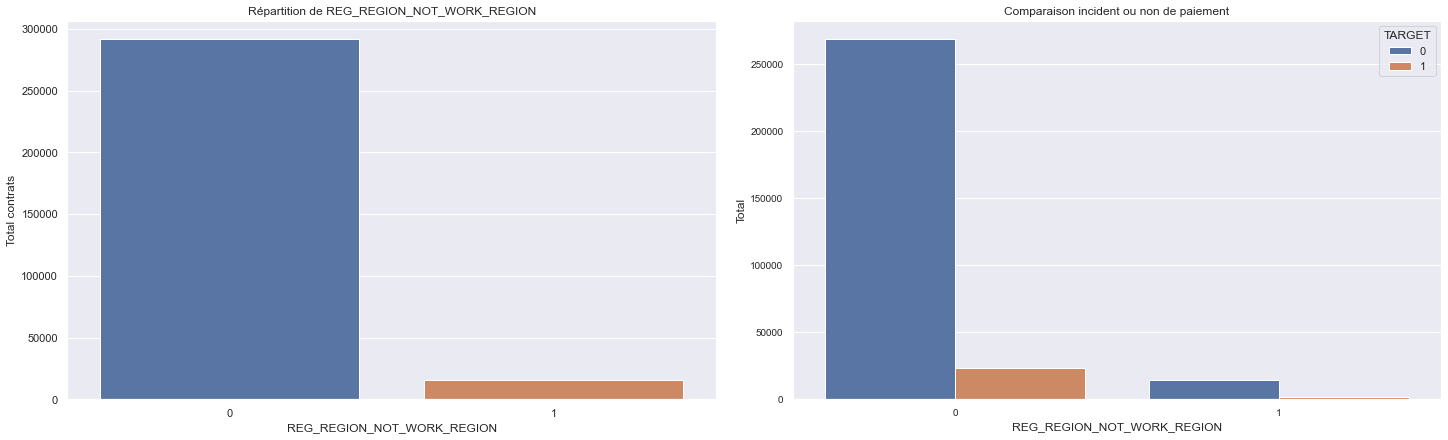

0 valeurs manquantes
5.08% des clients ont une adresse permanente dans une autre région que leur adresse professionnelle
8.89% des clients ont une adresse permanente dans une autre région que leur adresse professionnelle ne remboursent pas leur crédit


In [144]:
categorical_info(application_train,'REG_REGION_NOT_WORK_REGION',label_rotation=0)

print(f"{application_train['REG_REGION_NOT_WORK_REGION'].isna().sum()} valeurs manquantes")

percent = (len(application_train[application_train['REG_REGION_NOT_WORK_REGION'] == 1]) / application_train.shape[0]) * 100
print(f"{percent:.2f}% des clients ont une adresse permanente dans une autre région que leur adresse professionnelle")

p_count = len(application_train[application_train['REG_REGION_NOT_WORK_REGION'] == 1])
p_not = len(application_train[(application_train['REG_REGION_NOT_WORK_REGION'] == 1) & (application_train['TARGET'] == 1)]) 

percent = (p_not / p_count) * 100
print(f"{percent:.2f}% des clients ont une adresse permanente dans une autre région que leur adresse professionnelle ne remboursent pas leur crédit")


### LIVE_REGION_NOT_WORK_REGION
Signaler si l'adresse de contact du client ne correspond pas à l'adresse professionnelle (1=différent. 0=même. au niveau de la région)


--------------------------
-- LIVE_REGION_NOT_WORK_REGION --
--------------------------
0 valeurs manquantes
---------------------------
0.28% de corrélation entre LIVE_REGION_NOT_WORK_REGION et TARGET
---------------------------


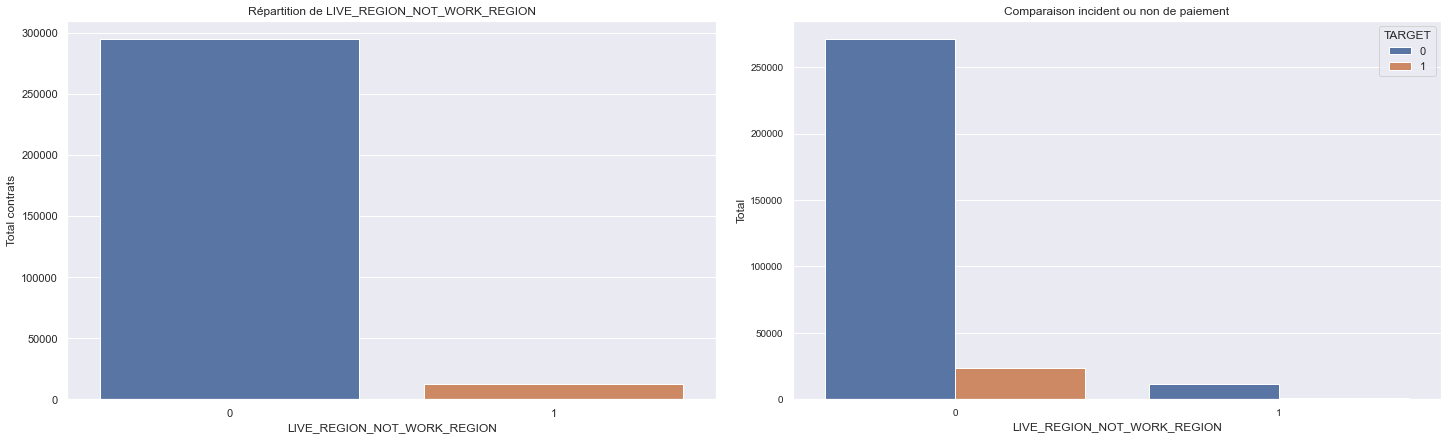

0 valeurs manquantes
4.07% des clients ont une adresse de contact dans une autre région que leur adresse professionnelle
8.45% des clients ont une adresse de contact dans une autre région que leur adresse professionnelle ne remboursent pas leur crédit


In [145]:
categorical_info(application_train,'LIVE_REGION_NOT_WORK_REGION',label_rotation=0)

print(f"{application_train['LIVE_REGION_NOT_WORK_REGION'].isna().sum()} valeurs manquantes")

percent = (len(application_train[application_train['LIVE_REGION_NOT_WORK_REGION'] == 1]) / application_train.shape[0]) * 100
print(f"{percent:.2f}% des clients ont une adresse de contact dans une autre région que leur adresse professionnelle")

p_count = len(application_train[application_train['LIVE_REGION_NOT_WORK_REGION'] == 1])
p_not = len(application_train[(application_train['LIVE_REGION_NOT_WORK_REGION'] == 1) & (application_train['TARGET'] == 1)]) 

percent = (p_not / p_count) * 100
print(f"{percent:.2f}% des clients ont une adresse de contact dans une autre région que leur adresse professionnelle ne remboursent pas leur crédit")


### REG_CITY_NOT_LIVE_CITY
Signaler si l'adresse permanente du client ne correspond pas à l'adresse de contact (1=différent. 0=même. au niveau de la ville)


--------------------------
-- REG_CITY_NOT_LIVE_CITY --
--------------------------
0 valeurs manquantes
---------------------------
4.44% de corrélation entre REG_CITY_NOT_LIVE_CITY et TARGET
---------------------------


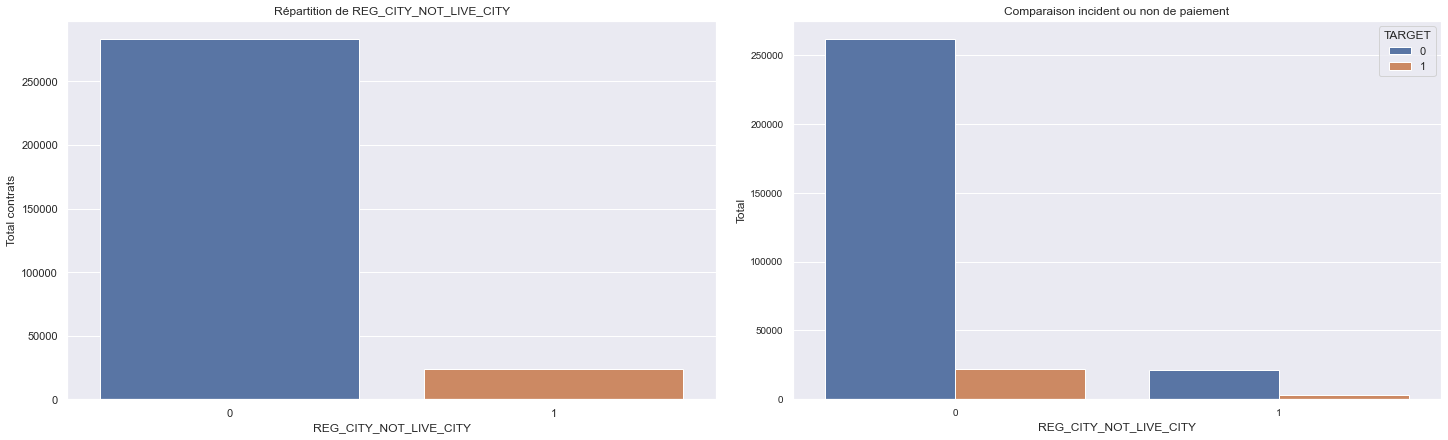

0 valeurs manquantes
7.82% des clients ont une adresse permanente dans une autre ville que leur adresse de contact
12.23% des clients ont une adresse permanente dans une autre ville que leur adresse de contact ne remboursent pas leur crédit


In [146]:
categorical_info(application_train,'REG_CITY_NOT_LIVE_CITY',label_rotation=0)

print(f"{application_train['REG_CITY_NOT_LIVE_CITY'].isna().sum()} valeurs manquantes")

percent = (len(application_train[application_train['REG_CITY_NOT_LIVE_CITY'] == 1]) / application_train.shape[0]) * 100
print(f"{percent:.2f}% des clients ont une adresse permanente dans une autre ville que leur adresse de contact")

p_count = len(application_train[application_train['REG_CITY_NOT_LIVE_CITY'] == 1])
p_not = len(application_train[(application_train['REG_CITY_NOT_LIVE_CITY'] == 1) & (application_train['TARGET'] == 1)]) 

percent = (p_not / p_count) * 100
print(f"{percent:.2f}% des clients ont une adresse permanente dans une autre ville que leur adresse de contact ne remboursent pas leur crédit")

### REG_CITY_NOT_WORK_CITY
Signaler si l'adresse permanente du client ne correspond pas à son adresse professionnelle (1=différent. 0=même. au niveau de la ville)


--------------------------
-- REG_CITY_NOT_WORK_CITY --
--------------------------
0 valeurs manquantes
---------------------------
5.10% de corrélation entre REG_CITY_NOT_WORK_CITY et TARGET
---------------------------


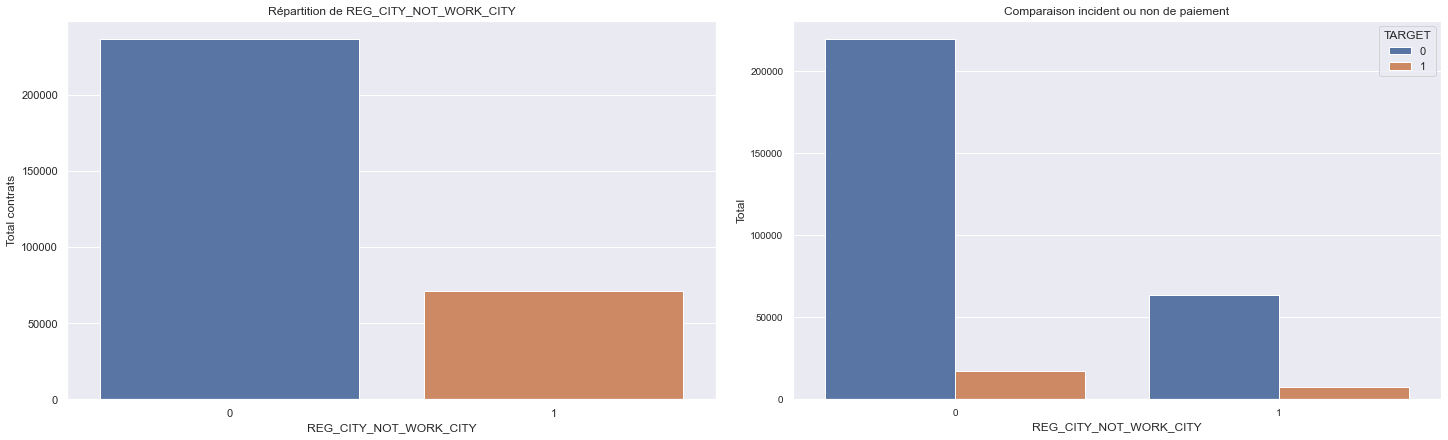

0 valeurs manquantes
23.05% des clients ont une adresse permanente dans une autre ville que leur adresse professionnelle
10.61% des clients ont une adresse permanente dans une autre ville que leur adresse professionnelle ne remboursent pas leur crédit


In [147]:
categorical_info(application_train,'REG_CITY_NOT_WORK_CITY',label_rotation=0)

print(f"{application_train['REG_CITY_NOT_WORK_CITY'].isna().sum()} valeurs manquantes")

percent = (len(application_train[application_train['REG_CITY_NOT_WORK_CITY'] == 1]) / application_train.shape[0]) * 100
print(f"{percent:.2f}% des clients ont une adresse permanente dans une autre ville que leur adresse professionnelle")

p_count = len(application_train[application_train['REG_CITY_NOT_WORK_CITY'] == 1])
p_not = len(application_train[(application_train['REG_CITY_NOT_WORK_CITY'] == 1) & (application_train['TARGET'] == 1)]) 

percent = (p_not / p_count) * 100
print(f"{percent:.2f}% des clients ont une adresse permanente dans une autre ville que leur adresse professionnelle ne remboursent pas leur crédit")

### LIVE_CITY_NOT_WORK_CITY
Signaler si l'adresse de contact du client ne correspond pas à l'adresse professionnelle (1=différent. 0=même. au niveau de la ville)

--------------------------
-- LIVE_CITY_NOT_WORK_CITY --
--------------------------
0 valeurs manquantes
---------------------------
3.25% de corrélation entre LIVE_CITY_NOT_WORK_CITY et TARGET
---------------------------


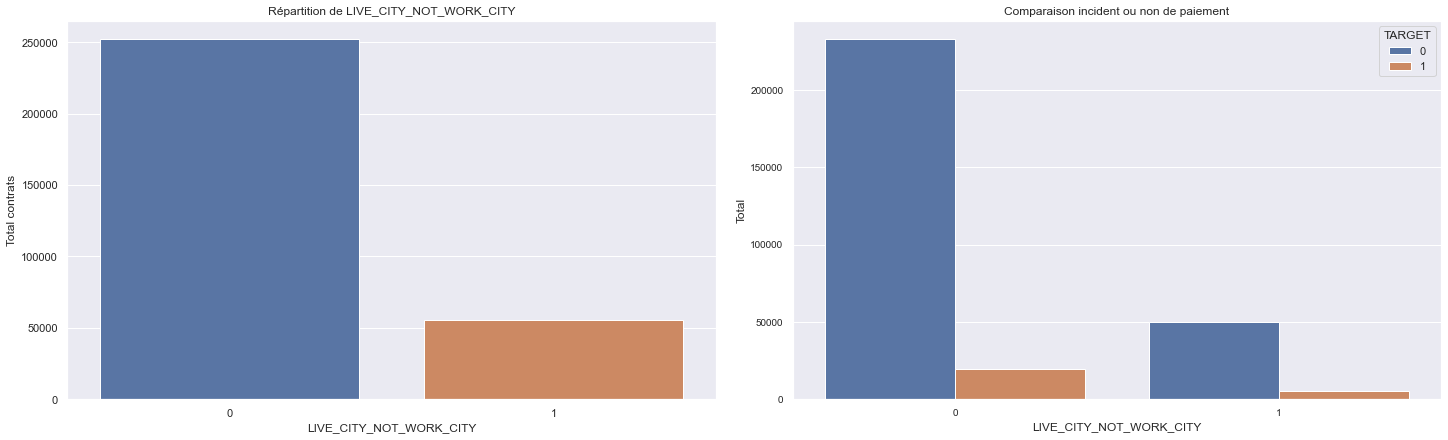

0 valeurs manquantes
17.96% des clients ont une adresse de contact dans une autre ville que leur adresse professionnelle
9.97% des clients ont une adresse de contact dans une autre ville que leur adresse professionnelle ne remboursent pas leur crédit


In [148]:
categorical_info(application_train,'LIVE_CITY_NOT_WORK_CITY',label_rotation=0)

print(f"{application_train['LIVE_CITY_NOT_WORK_CITY'].isna().sum()} valeurs manquantes")

percent = (len(application_train[application_train['LIVE_CITY_NOT_WORK_CITY'] == 1]) / application_train.shape[0]) * 100
print(f"{percent:.2f}% des clients ont une adresse de contact dans une autre ville que leur adresse professionnelle")

p_count = len(application_train[application_train['LIVE_CITY_NOT_WORK_CITY'] == 1])
p_not = len(application_train[(application_train['LIVE_CITY_NOT_WORK_CITY'] == 1) & (application_train['TARGET'] == 1)]) 

percent = (p_not / p_count) * 100
print(f"{percent:.2f}% des clients ont une adresse de contact dans une autre ville que leur adresse professionnelle ne remboursent pas leur crédit")

### EXT_SOURCE_1
Score normalisé provenant d'une source de données externe


173378 valeurs manquantes
----------------------
Asymetrie : -0.06875891238451004
LOG - Asymetrie : -0.2959556579589844
SQR - Asymetrie : -0.515540361404419
----------------------
Corrélation de -15.53% entre EXT_SOURCE_1 et TARGET
----------------------
count   134132.000
mean         0.502
std          0.211
min          0.015
25%          0.334
50%          0.506
75%          0.675
max          0.963
Name: EXT_SOURCE_1, dtype: float64


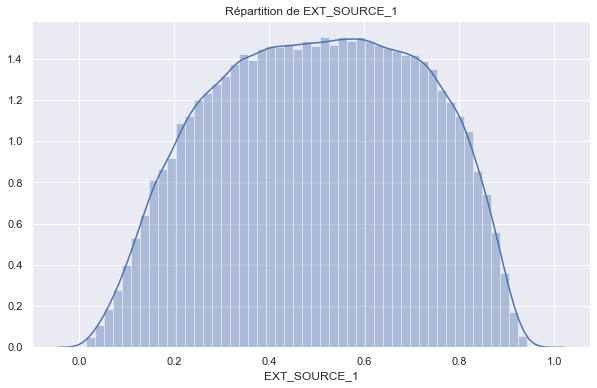

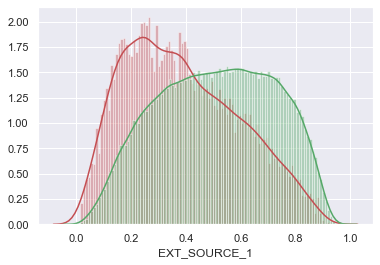

In [149]:
show_numerical(application_train, 'EXT_SOURCE_1')

### EXT_SOURCE_2
Score normalisé provenant d'une source de données externe


660 valeurs manquantes
----------------------
Asymetrie : -0.7935775518417358
LOG - Asymetrie : -1.0278401374816895
SQR - Asymetrie : -1.4167331457138062
----------------------
Corrélation de -16.05% entre EXT_SOURCE_2 et TARGET
----------------------
count   306850.000
mean         0.514
std          0.191
min          0.000
25%          0.392
50%          0.566
75%          0.664
max          0.855
Name: EXT_SOURCE_2, dtype: float64


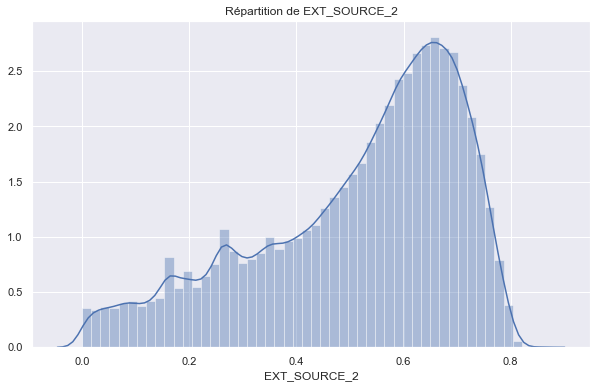

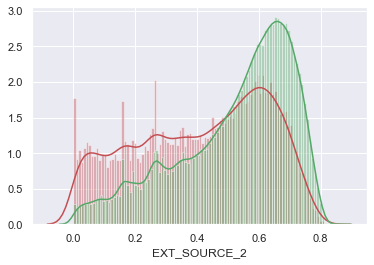

In [150]:
show_numerical(application_train, 'EXT_SOURCE_2')

### EXT_SOURCE_3
Score normalisé provenant d'une source de données externe


60965 valeurs manquantes
----------------------
Asymetrie : -0.4093915820121765
LOG - Asymetrie : -0.6568816900253296
SQR - Asymetrie : -1.0336670875549316
----------------------
Corrélation de -17.89% entre EXT_SOURCE_3 et TARGET
----------------------
count   246545.000
mean         0.511
std          0.195
min          0.001
25%          0.371
50%          0.535
75%          0.669
max          0.896
Name: EXT_SOURCE_3, dtype: float64


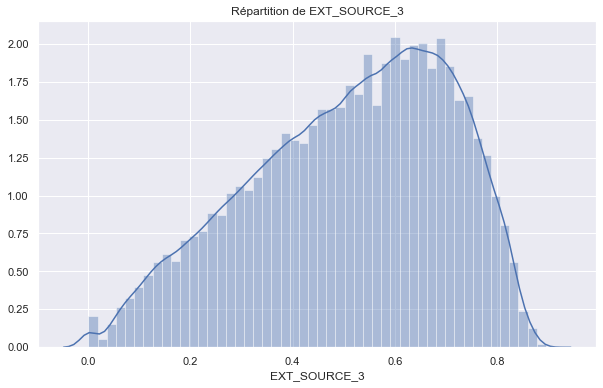

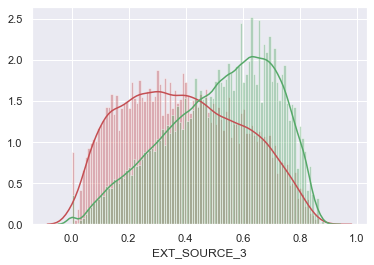

In [151]:
show_numerical(application_train, 'EXT_SOURCE_3')

### APARTMENTS_AVG
Informations normalisées sur l'immeuble où vit le client. ce qui est moyen (suffixe _AVG). modus (suffixe _MODE). médian (suffixe _MEDI) taille de l'appartement. espace commun. surface habitable. âge de l'immeuble. nombre d'ascenseurs. nombre d'entrées. état de l'immeuble. nombre d'étages


156061 valeurs manquantes
----------------------
Asymetrie : 2.641799211502075
LOG - Asymetrie : 1.9867792129516602
SQR - Asymetrie : 0.7725424766540527
----------------------
Corrélation de -2.95% entre APARTMENTS_AVG et TARGET
----------------------
count   151449.000
mean         0.117
std          0.108
min          0.000
25%          0.058
50%          0.088
75%          0.148
max          1.000
Name: APARTMENTS_AVG, dtype: float64


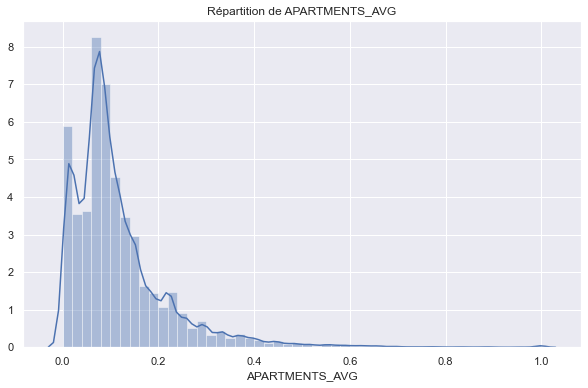

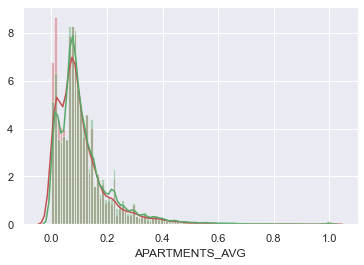

In [152]:
show_numerical(application_train, 'APARTMENTS_AVG')

### BASEMENTAREA_AVG
Informations normalisées sur l'immeuble où vit le client. ce qui est moyen (suffixe _AVG). modus (suffixe _MODE). médian (suffixe _MEDI) taille de l'appartement. espace commun. surface habitable. âge de l'immeuble. nombre d'ascenseurs. nombre d'entrées. état de l'immeuble. nombre d'étages


179943 valeurs manquantes
----------------------
Asymetrie : 3.566251754760742
LOG - Asymetrie : 2.4341225624084473
SQR - Asymetrie : 0.07597444206476212
----------------------
Corrélation de -2.27% entre BASEMENTAREA_AVG et TARGET
----------------------
count   127567.000
mean         0.088
std          0.082
min          0.000
25%          0.044
50%          0.076
75%          0.112
max          1.000
Name: BASEMENTAREA_AVG, dtype: float64


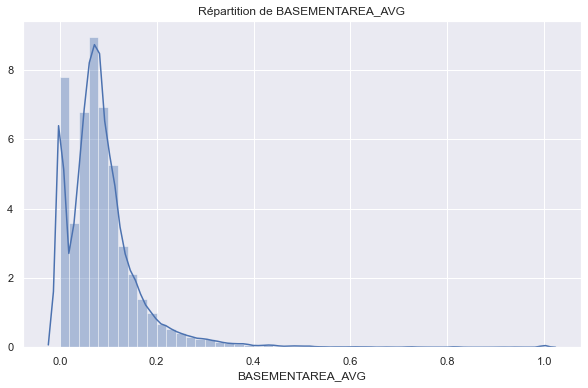

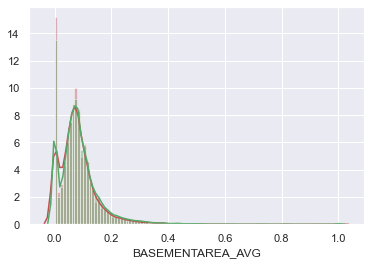

In [153]:
show_numerical(application_train, 'BASEMENTAREA_AVG')

### YEARS_BEGINEXPLUATATION_AVG
Informations normalisées sur l'immeuble où vit le client. ce qui est moyen (suffixe _AVG). modus (suffixe _MODE). médian (suffixe _MEDI) taille de l'appartement. espace commun. surface habitable. âge de l'immeuble. nombre d'ascenseurs. nombre d'entrées. état de l'immeuble. nombre d'étages


150007 valeurs manquantes
----------------------
Asymetrie : -15.51506233215332
LOG - Asymetrie : -16.01172637939453
SQR - Asymetrie : -16.581493377685547
----------------------
Corrélation de -0.97% entre YEARS_BEGINEXPLUATATION_AVG et TARGET
----------------------
count   157503.000
mean         0.978
std          0.059
min          0.000
25%          0.977
50%          0.982
75%          0.987
max          1.000
Name: YEARS_BEGINEXPLUATATION_AVG, dtype: float64


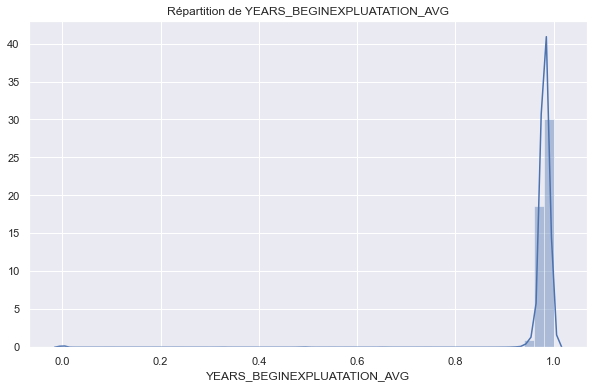

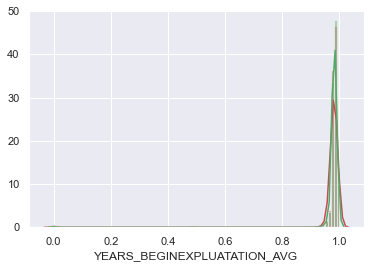

In [154]:
show_numerical(application_train, 'YEARS_BEGINEXPLUATATION_AVG')

### YEARS_BUILD_AVG
Informations normalisées sur l'immeuble où vit le client. ce qui est moyen (suffixe _AVG). modus (suffixe _MODE). médian (suffixe _MEDI) taille de l'appartement. espace commun. surface habitable. âge de l'immeuble. nombre d'ascenseurs. nombre d'entrées. état de l'immeuble. nombre d'étages


204487 valeurs manquantes
----------------------
Asymetrie : -0.9624729752540588
LOG - Asymetrie : -1.6689534187316895
SQR - Asymetrie : -2.9137260913848877
----------------------
Corrélation de -2.21% entre YEARS_BUILD_AVG et TARGET
----------------------
count   103023.000
mean         0.752
std          0.113
min          0.000
25%          0.687
50%          0.755
75%          0.823
max          1.000
Name: YEARS_BUILD_AVG, dtype: float64


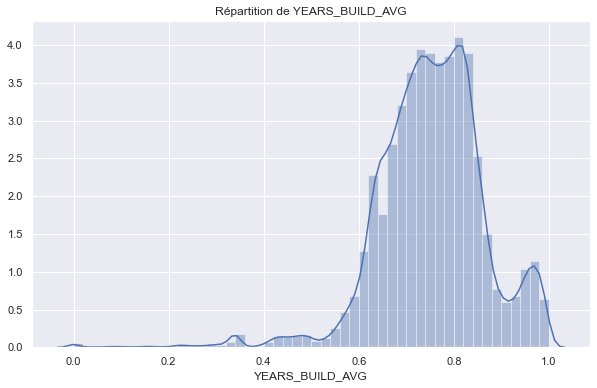

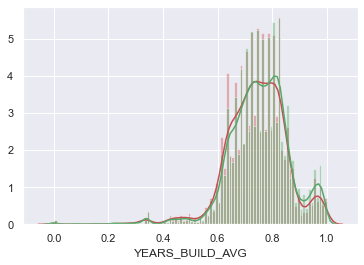

In [155]:
show_numerical(application_train, 'YEARS_BUILD_AVG')

### COMMONAREA_AVG
Informations normalisées sur l'immeuble où vit le client. ce qui est moyen (suffixe _AVG). modus (suffixe _MODE). médian (suffixe _MEDI) taille de l'appartement. espace commun. surface habitable. âge de l'immeuble. nombre d'ascenseurs. nombre d'entrées. état de l'immeuble. nombre d'étages


214864 valeurs manquantes
----------------------
Asymetrie : 5.457218647003174
LOG - Asymetrie : 4.179833889007568
SQR - Asymetrie : 1.5736689567565918
----------------------
Corrélation de -1.85% entre COMMONAREA_AVG et TARGET
----------------------
count   92646.000
mean        0.045
std         0.076
min         0.000
25%         0.008
50%         0.021
75%         0.052
max         1.000
Name: COMMONAREA_AVG, dtype: float64


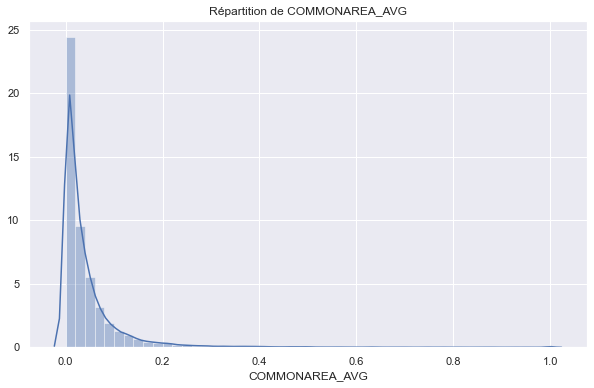

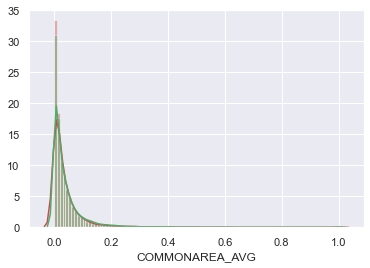

In [156]:
show_numerical(application_train, 'COMMONAREA_AVG')

### ELEVATORS_AVG
Informations normalisées sur l'immeuble où vit le client. ce qui est moyen (suffixe _AVG). modus (suffixe _MODE). médian (suffixe _MEDI) taille de l'appartement. espace commun. surface habitable. âge de l'immeuble. nombre d'ascenseurs. nombre d'entrées. état de l'immeuble. nombre d'étages


163891 valeurs manquantes
----------------------
Asymetrie : 2.4393928050994873
LOG - Asymetrie : 1.947320818901062
SQR - Asymetrie : 0.9938069581985474
----------------------
Corrélation de -3.42% entre ELEVATORS_AVG et TARGET
----------------------
count   143619.000
mean         0.079
std          0.135
min          0.000
25%          0.000
50%          0.000
75%          0.120
max          1.000
Name: ELEVATORS_AVG, dtype: float64


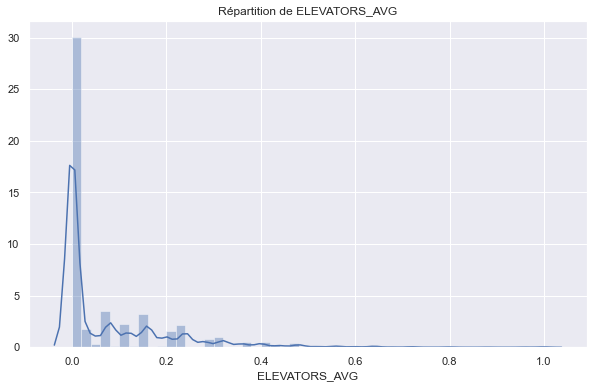

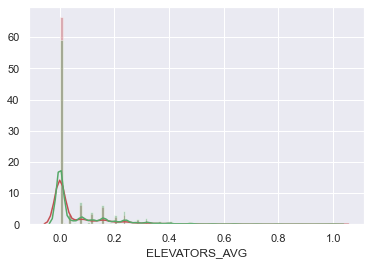

In [157]:
show_numerical(application_train, 'ELEVATORS_AVG')

### ENTRANCES_AVG
Informations normalisées sur l'immeuble où vit le client. ce qui est moyen (suffixe _AVG). modus (suffixe _MODE). médian (suffixe _MEDI) taille de l'appartement. espace commun. surface habitable. âge de l'immeuble. nombre d'ascenseurs. nombre d'entrées. état de l'immeuble. nombre d'étages


154828 valeurs manquantes
----------------------
Asymetrie : 2.399702787399292
LOG - Asymetrie : 1.6790202856063843
SQR - Asymetrie : 0.7255600094795227
----------------------
Corrélation de -1.92% entre ENTRANCES_AVG et TARGET
----------------------
count   152682.000
mean         0.150
std          0.100
min          0.000
25%          0.069
50%          0.138
75%          0.207
max          1.000
Name: ENTRANCES_AVG, dtype: float64


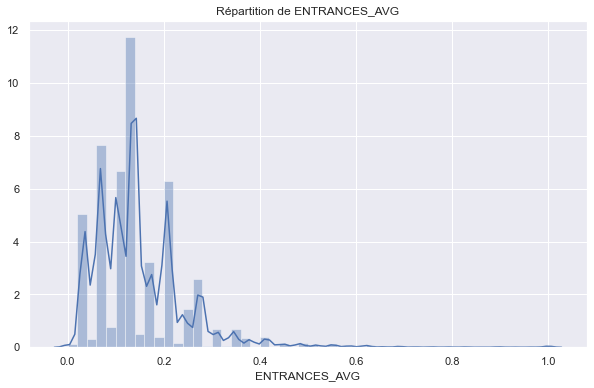

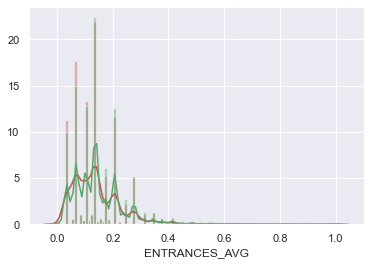

In [158]:
show_numerical(application_train, 'ENTRANCES_AVG')

### FLOORSMAX_AVG
Informations normalisées sur l'immeuble où vit le client. ce qui est moyen (suffixe _AVG). modus (suffixe _MODE). médian (suffixe _MEDI) taille de l'appartement. espace commun. surface habitable. âge de l'immeuble. nombre d'ascenseurs. nombre d'entrées. état de l'immeuble. nombre d'étages


153020 valeurs manquantes
----------------------
Asymetrie : 1.226431965827942
LOG - Asymetrie : 0.8069735765457153
SQR - Asymetrie : -0.05557813122868538
----------------------
Corrélation de -4.40% entre FLOORSMAX_AVG et TARGET
----------------------
count   154490.000
mean         0.226
std          0.145
min          0.000
25%          0.167
50%          0.167
75%          0.333
max          1.000
Name: FLOORSMAX_AVG, dtype: float64


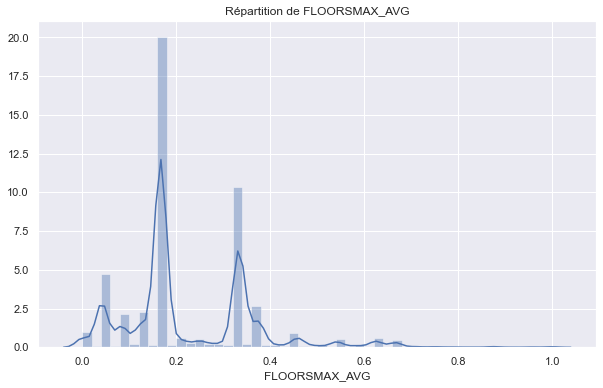

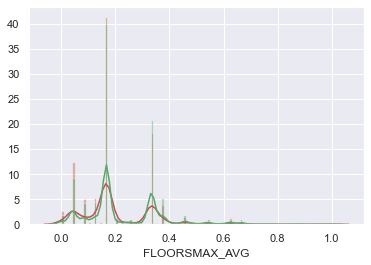

In [159]:
show_numerical(application_train, 'FLOORSMAX_AVG')

### FLOORSMIN_AVG
Informations normalisées sur l'immeuble où vit le client. ce qui est moyen (suffixe _AVG). modus (suffixe _MODE). médian (suffixe _MEDI) taille de l'appartement. espace commun. surface habitable. âge de l'immeuble. nombre d'ascenseurs. nombre d'entrées. état de l'immeuble. nombre d'étages


208641 valeurs manquantes
----------------------
Asymetrie : 0.9541826248168945
LOG - Asymetrie : 0.5654112100601196
SQR - Asymetrie : -0.14638616144657135
----------------------
Corrélation de -3.36% entre FLOORSMIN_AVG et TARGET
----------------------
count   98869.000
mean        0.232
std         0.161
min         0.000
25%         0.083
50%         0.208
75%         0.375
max         1.000
Name: FLOORSMIN_AVG, dtype: float64


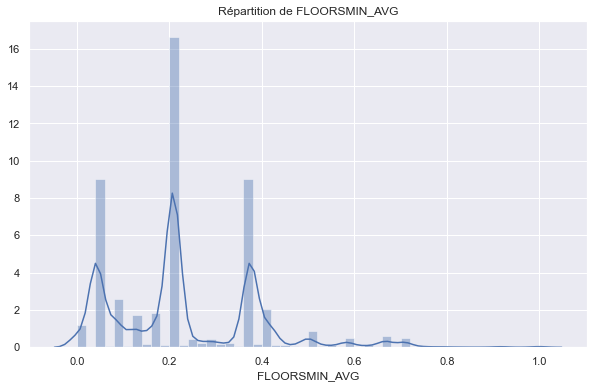

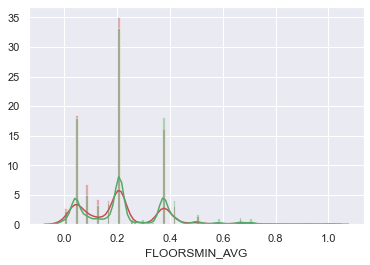

In [160]:
show_numerical(application_train, 'FLOORSMIN_AVG')

### LANDAREA_AVG
Informations normalisées sur l'immeuble où vit le client. ce qui est moyen (suffixe _AVG). modus (suffixe _MODE). médian (suffixe _MEDI) taille de l'appartement. espace commun. surface habitable. âge de l'immeuble. nombre d'ascenseurs. nombre d'entrées. état de l'immeuble. nombre d'étages


182590 valeurs manquantes
----------------------
Asymetrie : 4.458606243133545
LOG - Asymetrie : 3.2058680057525635
SQR - Asymetrie : 0.7146366238594055
----------------------
Corrélation de -1.09% entre LANDAREA_AVG et TARGET
----------------------
count   124920.000
mean         0.066
std          0.081
min          0.000
25%          0.019
50%          0.048
75%          0.086
max          1.000
Name: LANDAREA_AVG, dtype: float64


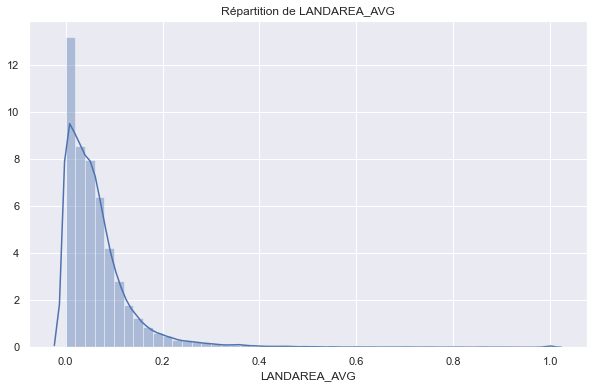

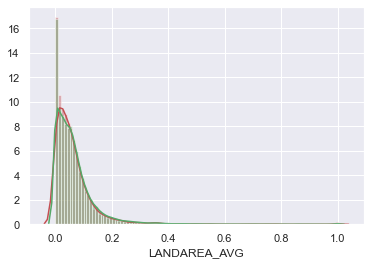

In [161]:
show_numerical(application_train, 'LANDAREA_AVG')

### LIVINGAPARTMENTS_AVG
Informations normalisées sur l'immeuble où vit le client. ce qui est moyen (suffixe _AVG). modus (suffixe _MODE). médian (suffixe _MEDI) taille de l'appartement. espace commun. surface habitable. âge de l'immeuble. nombre d'ascenseurs. nombre d'entrées. état de l'immeuble. nombre d'étages


210198 valeurs manquantes
----------------------
Asymetrie : 3.0421509742736816
LOG - Asymetrie : 2.267503261566162
SQR - Asymetrie : 0.9313734173774719
----------------------
Corrélation de -2.50% entre LIVINGAPARTMENTS_AVG et TARGET
----------------------
count   97312.000
mean        0.101
std         0.093
min         0.000
25%         0.050
50%         0.076
75%         0.121
max         1.000
Name: LIVINGAPARTMENTS_AVG, dtype: float64


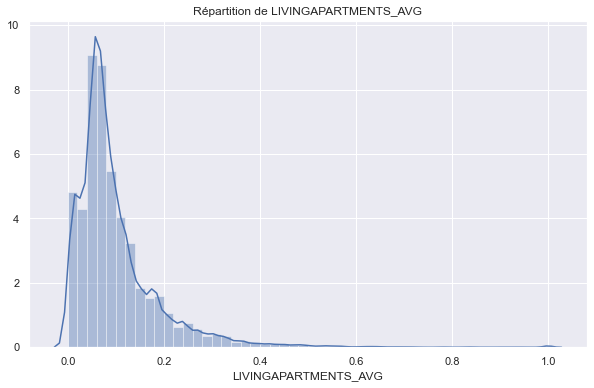

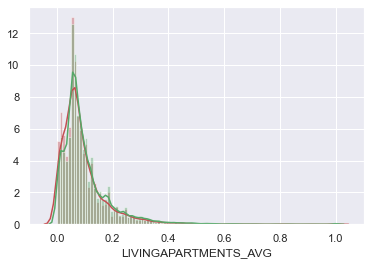

In [162]:
show_numerical(application_train, 'LIVINGAPARTMENTS_AVG')

### LIVINGAREA_AVG
Informations normalisées sur l'immeuble où vit le client. ce qui est moyen (suffixe _AVG). modus (suffixe _MODE). médian (suffixe _MEDI) taille de l'appartement. espace commun. surface habitable. âge de l'immeuble. nombre d'ascenseurs. nombre d'entrées. état de l'immeuble. nombre d'étages


154350 valeurs manquantes
----------------------
Asymetrie : 2.854696750640869
LOG - Asymetrie : 2.2075977325439453
SQR - Asymetrie : 1.0082447528839111
----------------------
Corrélation de -3.30% entre LIVINGAREA_AVG et TARGET
----------------------
count   153160.000
mean         0.107
std          0.111
min          0.000
25%          0.045
50%          0.075
75%          0.130
max          1.000
Name: LIVINGAREA_AVG, dtype: float64


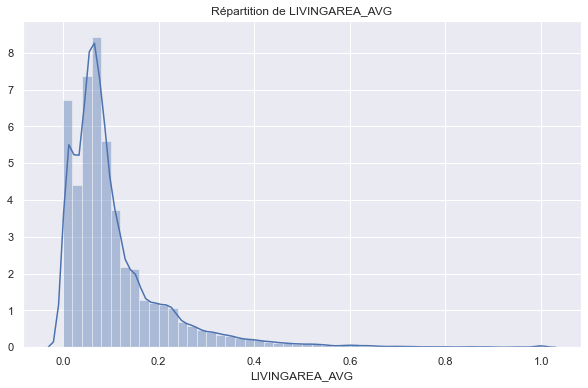

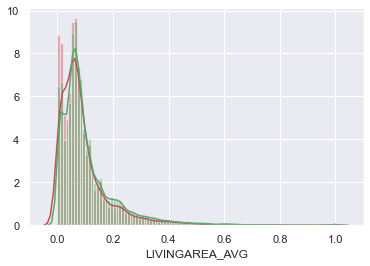

In [163]:
show_numerical(application_train, 'LIVINGAREA_AVG')

### NONLIVINGAPARTMENTS_AVG
Informations normalisées sur l'immeuble où vit le client. ce qui est moyen (suffixe _AVG). modus (suffixe _MODE). médian (suffixe _MEDI) taille de l'appartement. espace commun. surface habitable. âge de l'immeuble. nombre d'ascenseurs. nombre d'entrées. état de l'immeuble. nombre d'étages


213513 valeurs manquantes
----------------------
Asymetrie : 15.540936470031738
LOG - Asymetrie : 13.24990177154541
SQR - Asymetrie : 4.594873428344727
----------------------
Corrélation de -0.32% entre NONLIVINGAPARTMENTS_AVG et TARGET
----------------------
count   93997.000
mean        0.009
std         0.048
min         0.000
25%         0.000
50%         0.000
75%         0.004
max         1.000
Name: NONLIVINGAPARTMENTS_AVG, dtype: float64


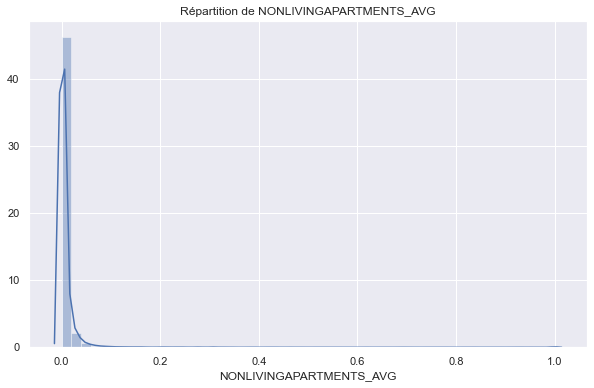

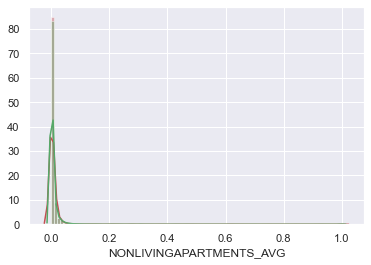

In [164]:
show_numerical(application_train, 'NONLIVINGAPARTMENTS_AVG')

### NONLIVINGAREA_AVG
Informations normalisées sur l'immeuble où vit le client. ce qui est moyen (suffixe _AVG). modus (suffixe _MODE). médian (suffixe _MEDI) taille de l'appartement. espace commun. surface habitable. âge de l'immeuble. nombre d'ascenseurs. nombre d'entrées. état de l'immeuble. nombre d'étages


169681 valeurs manquantes
----------------------
Asymetrie : 6.558939456939697
LOG - Asymetrie : 5.026005268096924
SQR - Asymetrie : 1.8697108030319214
----------------------
Corrélation de -1.36% entre NONLIVINGAREA_AVG et TARGET
----------------------
count   137829.000
mean         0.028
std          0.070
min          0.000
25%          0.000
50%          0.004
75%          0.028
max          1.000
Name: NONLIVINGAREA_AVG, dtype: float64


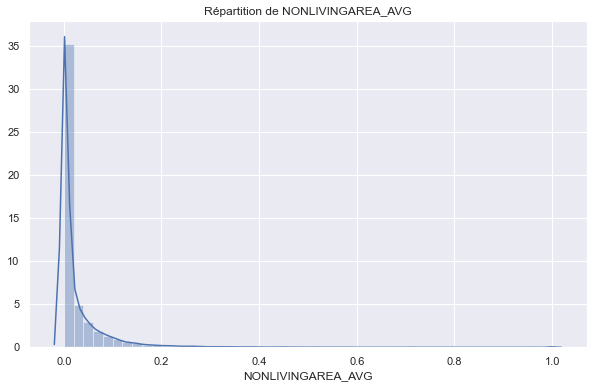

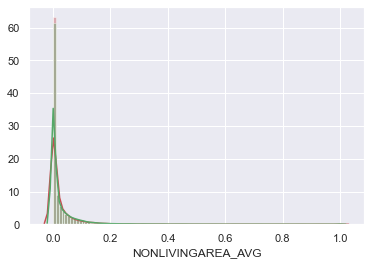

In [165]:
show_numerical(application_train, 'NONLIVINGAREA_AVG')

### APARTMENTS_MODE
Informations normalisées sur l'immeuble où vit le client. ce qui est moyen (suffixe _AVG). modus (suffixe _MODE). médian (suffixe _MEDI) taille de l'appartement. espace commun. surface habitable. âge de l'immeuble. nombre d'ascenseurs. nombre d'entrées. état de l'immeuble. nombre d'étages


156061 valeurs manquantes
----------------------
Asymetrie : 2.703014373779297
LOG - Asymetrie : 2.0443077087402344
SQR - Asymetrie : 0.7928889989852905
----------------------
Corrélation de -2.73% entre APARTMENTS_MODE et TARGET
----------------------
count   151449.000
mean         0.114
std          0.108
min          0.000
25%          0.052
50%          0.084
75%          0.144
max          1.000
Name: APARTMENTS_MODE, dtype: float64


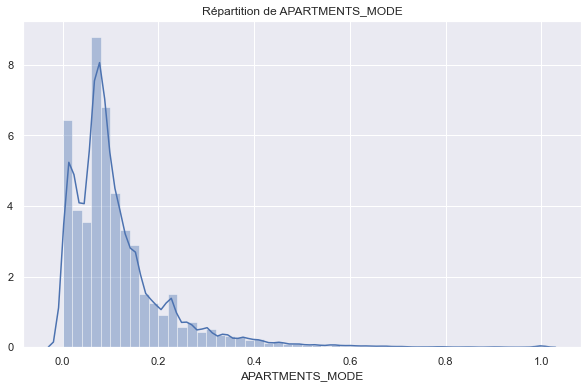

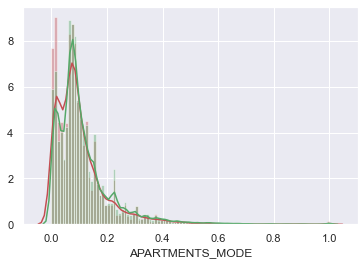

In [166]:
show_numerical(application_train, 'APARTMENTS_MODE')

### BASEMENTAREA_MODE
Informations normalisées sur l'immeuble où vit le client. ce qui est moyen (suffixe _AVG). modus (suffixe _MODE). médian (suffixe _MEDI) taille de l'appartement. espace commun. surface habitable. âge de l'immeuble. nombre d'ascenseurs. nombre d'entrées. état de l'immeuble. nombre d'étages


179943 valeurs manquantes
----------------------
Asymetrie : 3.4814815521240234
LOG - Asymetrie : 2.3901915550231934
SQR - Asymetrie : 0.0922742486000061
----------------------
Corrélation de -2.00% entre BASEMENTAREA_MODE et TARGET
----------------------
count   127567.000
mean         0.088
std          0.084
min          0.000
25%          0.041
50%          0.075
75%          0.112
max          1.000
Name: BASEMENTAREA_MODE, dtype: float64


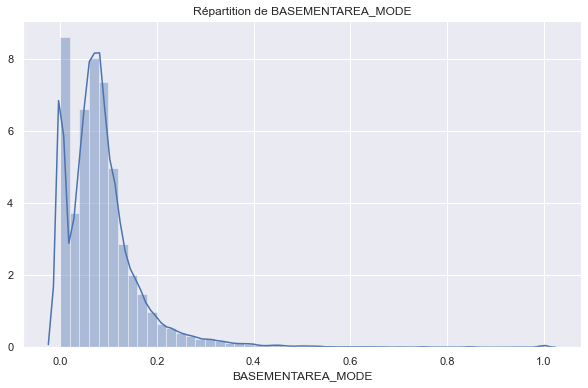

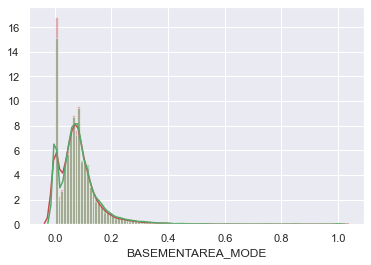

In [167]:
show_numerical(application_train, 'BASEMENTAREA_MODE')

### YEARS_BEGINEXPLUATATION_MODE
Informations normalisées sur l'immeuble où vit le client. ce qui est moyen (suffixe _AVG). modus (suffixe _MODE). médian (suffixe _MEDI) taille de l'appartement. espace commun. surface habitable. âge de l'immeuble. nombre d'ascenseurs. nombre d'entrées. état de l'immeuble. nombre d'étages


150007 valeurs manquantes
----------------------
Asymetrie : -14.755126953125
LOG - Asymetrie : -14.960693359375
SQR - Asymetrie : -15.09473991394043
----------------------
Corrélation de -0.90% entre YEARS_BEGINEXPLUATATION_MODE et TARGET
----------------------
count   157503.000
mean         0.977
std          0.065
min          0.000
25%          0.977
50%          0.982
75%          0.987
max          1.000
Name: YEARS_BEGINEXPLUATATION_MODE, dtype: float64


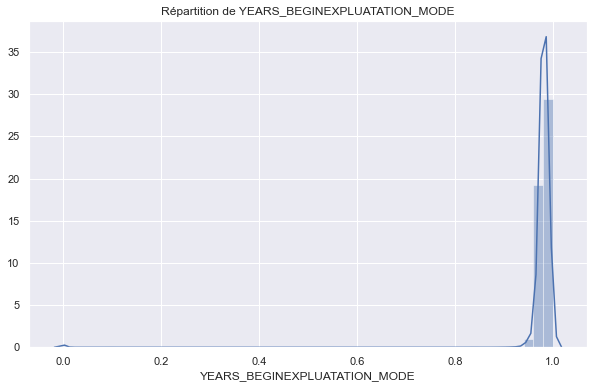

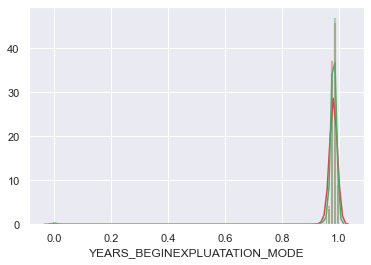

In [168]:
show_numerical(application_train, 'YEARS_BEGINEXPLUATATION_MODE')

### YEARS_BUILD_MODE
Informations normalisées sur l'immeuble où vit le client. ce qui est moyen (suffixe _AVG). modus (suffixe _MODE). médian (suffixe _MEDI) taille de l'appartement. espace commun. surface habitable. âge de l'immeuble. nombre d'ascenseurs. nombre d'entrées. état de l'immeuble. nombre d'étages


204487 valeurs manquantes
----------------------
Asymetrie : -1.002291202545166
LOG - Asymetrie : -1.7286725044250488
SQR - Asymetrie : -3.0676162242889404
----------------------
Corrélation de -2.21% entre YEARS_BUILD_MODE et TARGET
----------------------
count   103023.000
mean         0.760
std          0.110
min          0.000
25%          0.699
50%          0.765
75%          0.824
max          1.000
Name: YEARS_BUILD_MODE, dtype: float64


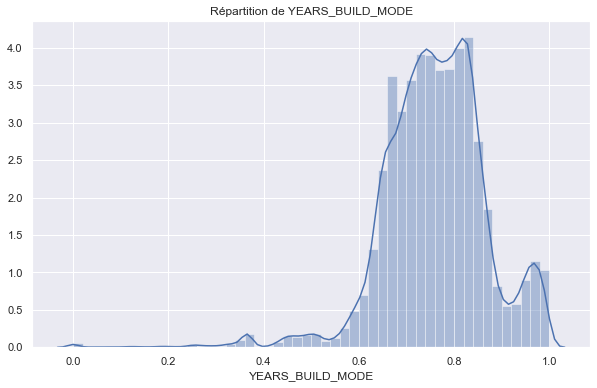

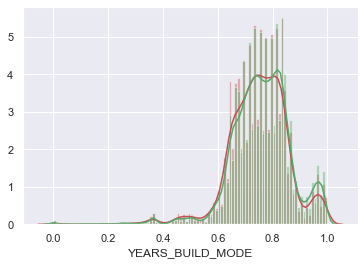

In [169]:
show_numerical(application_train, 'YEARS_BUILD_MODE')

### COMMONAREA_MODE
Informations normalisées sur l'immeuble où vit le client. ce qui est moyen (suffixe _AVG). modus (suffixe _MODE). médian (suffixe _MEDI) taille de l'appartement. espace commun. surface habitable. âge de l'immeuble. nombre d'ascenseurs. nombre d'entrées. état de l'immeuble. nombre d'étages


214864 valeurs manquantes
----------------------
Asymetrie : 5.620498180389404
LOG - Asymetrie : 4.29772424697876
SQR - Asymetrie : 1.5899850130081177
----------------------
Corrélation de -1.63% entre COMMONAREA_MODE et TARGET
----------------------
count   92646.000
mean        0.043
std         0.074
min         0.000
25%         0.007
50%         0.019
75%         0.049
max         1.000
Name: COMMONAREA_MODE, dtype: float64


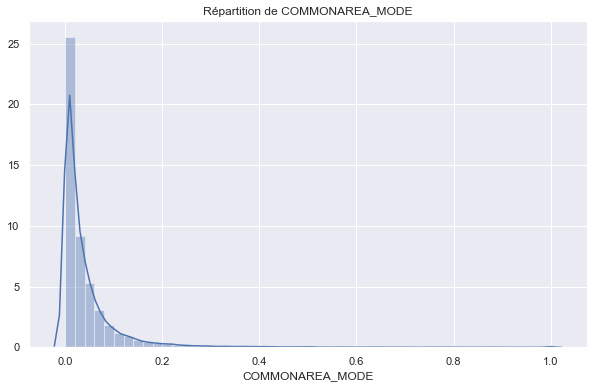

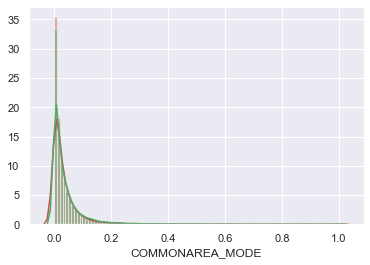

In [170]:
show_numerical(application_train, 'COMMONAREA_MODE')

### ELEVATORS_MODE
Informations normalisées sur l'immeuble où vit le client. ce qui est moyen (suffixe _AVG). modus (suffixe _MODE). médian (suffixe _MEDI) taille de l'appartement. espace commun. surface habitable. âge de l'immeuble. nombre d'ascenseurs. nombre d'entrées. état de l'immeuble. nombre d'étages


163891 valeurs manquantes
----------------------
Asymetrie : 2.552243947982788
LOG - Asymetrie : 2.048574209213257
SQR - Asymetrie : 1.0832138061523438
----------------------
Corrélation de -3.21% entre ELEVATORS_MODE et TARGET
----------------------
count   143619.000
mean         0.074
std          0.132
min          0.000
25%          0.000
50%          0.000
75%          0.121
max          1.000
Name: ELEVATORS_MODE, dtype: float64


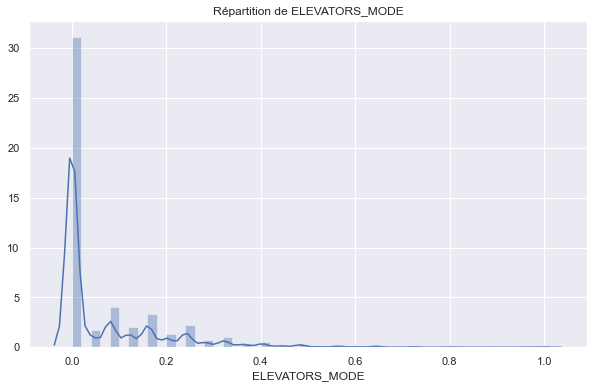

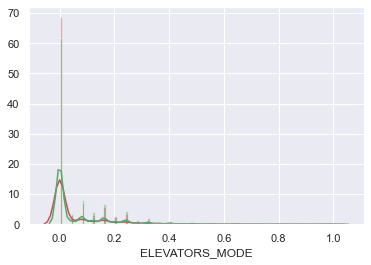

In [171]:
show_numerical(application_train, 'ELEVATORS_MODE')

### ENTRANCES_MODE
Informations normalisées sur l'immeuble où vit le client. ce qui est moyen (suffixe _AVG). modus (suffixe _MODE). médian (suffixe _MEDI) taille de l'appartement. espace commun. surface habitable. âge de l'immeuble. nombre d'ascenseurs. nombre d'entrées. état de l'immeuble. nombre d'étages


154828 valeurs manquantes
----------------------
Asymetrie : 2.392332077026367
LOG - Asymetrie : 1.6777715682983398
SQR - Asymetrie : 0.7227504253387451
----------------------
Corrélation de -1.74% entre ENTRANCES_MODE et TARGET
----------------------
count   152682.000
mean         0.145
std          0.101
min          0.000
25%          0.069
50%          0.138
75%          0.207
max          1.000
Name: ENTRANCES_MODE, dtype: float64


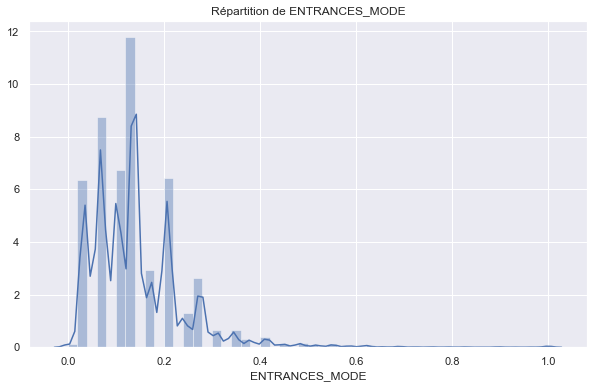

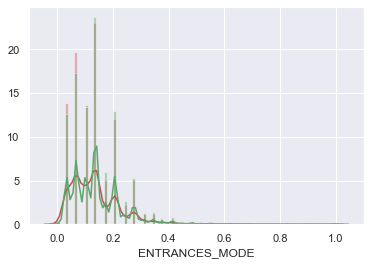

In [172]:
show_numerical(application_train, 'ENTRANCES_MODE')

### FLOORSMAX_MODE
Informations normalisées sur l'immeuble où vit le client. ce qui est moyen (suffixe _AVG). modus (suffixe _MODE). médian (suffixe _MEDI) taille de l'appartement. espace commun. surface habitable. âge de l'immeuble. nombre d'ascenseurs. nombre d'entrées. état de l'immeuble. nombre d'étages


153020 valeurs manquantes
----------------------
Asymetrie : 1.2443209886550903
LOG - Asymetrie : 0.8195953965187073
SQR - Asymetrie : -0.08053027838468552
----------------------
Corrélation de -4.32% entre FLOORSMAX_MODE et TARGET
----------------------
count   154490.000
mean         0.222
std          0.144
min          0.000
25%          0.167
50%          0.167
75%          0.333
max          1.000
Name: FLOORSMAX_MODE, dtype: float64


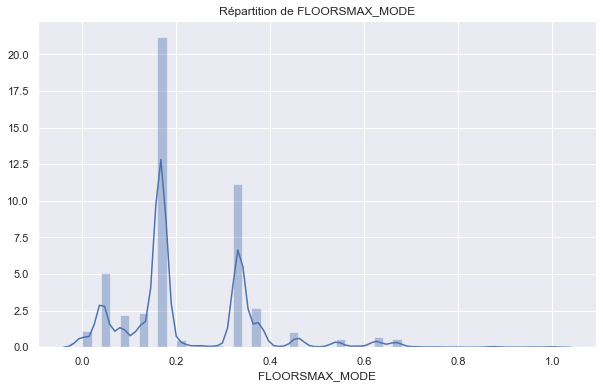

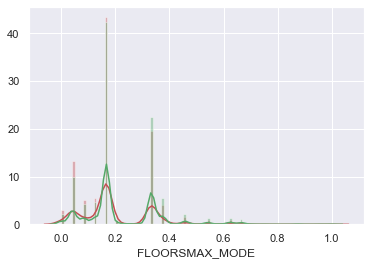

In [173]:
show_numerical(application_train, 'FLOORSMAX_MODE')

### FLOORSMIN_MODE
Informations normalisées sur l'immeuble où vit le client. ce qui est moyen (suffixe _AVG). modus (suffixe _MODE). médian (suffixe _MEDI) taille de l'appartement. espace commun. surface habitable. âge de l'immeuble. nombre d'ascenseurs. nombre d'entrées. état de l'immeuble. nombre d'étages


208641 valeurs manquantes
----------------------
Asymetrie : 0.9638201594352722
LOG - Asymetrie : 0.5767914056777954
SQR - Asymetrie : -0.13665339350700378
----------------------
Corrélation de -3.27% entre FLOORSMIN_MODE et TARGET
----------------------
count   98869.000
mean        0.228
std         0.161
min         0.000
25%         0.083
50%         0.208
75%         0.375
max         1.000
Name: FLOORSMIN_MODE, dtype: float64


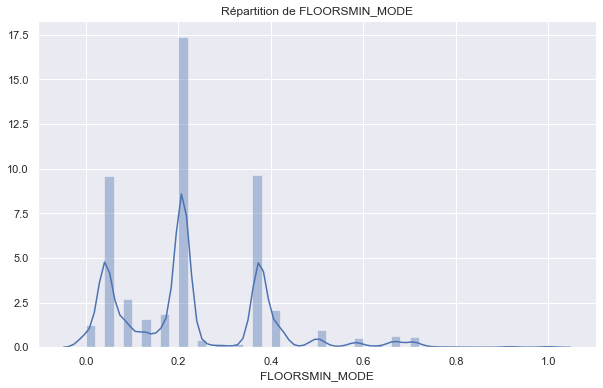

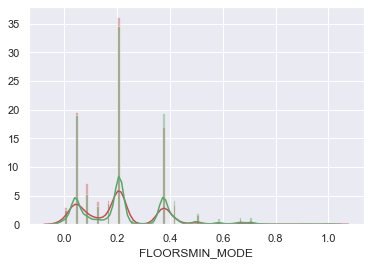

In [174]:
show_numerical(application_train, 'FLOORSMIN_MODE')

### LANDAREA_MODE
Informations normalisées sur l'immeuble où vit le client. ce qui est moyen (suffixe _AVG). modus (suffixe _MODE). médian (suffixe _MEDI) taille de l'appartement. espace commun. surface habitable. âge de l'immeuble. nombre d'ascenseurs. nombre d'entrées. état de l'immeuble. nombre d'étages


182590 valeurs manquantes
----------------------
Asymetrie : 4.376957416534424
LOG - Asymetrie : 3.169552803039551
SQR - Asymetrie : 0.7216587662696838
----------------------
Corrélation de -1.02% entre LANDAREA_MODE et TARGET
----------------------
count   124920.000
mean         0.065
std          0.082
min          0.000
25%          0.017
50%          0.046
75%          0.084
max          1.000
Name: LANDAREA_MODE, dtype: float64


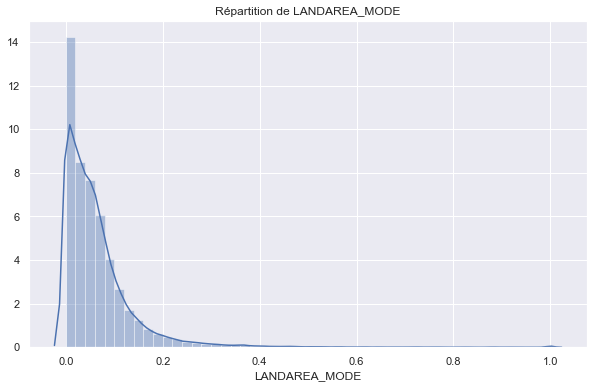

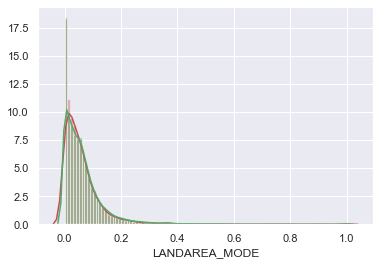

In [175]:
show_numerical(application_train, 'LANDAREA_MODE')

### LIVINGAPARTMENTS_MODE
Informations normalisées sur l'immeuble où vit le client. ce qui est moyen (suffixe _AVG). modus (suffixe _MODE). médian (suffixe _MEDI) taille de l'appartement. espace commun. surface habitable. âge de l'immeuble. nombre d'ascenseurs. nombre d'entrées. état de l'immeuble. nombre d'étages


210198 valeurs manquantes
----------------------
Asymetrie : 2.9026267528533936
LOG - Asymetrie : 2.1975226402282715
SQR - Asymetrie : 0.9141587018966675
----------------------
Corrélation de -2.34% entre LIVINGAPARTMENTS_MODE et TARGET
----------------------
count   97312.000
mean        0.106
std         0.098
min         0.000
25%         0.054
50%         0.077
75%         0.131
max         1.000
Name: LIVINGAPARTMENTS_MODE, dtype: float64


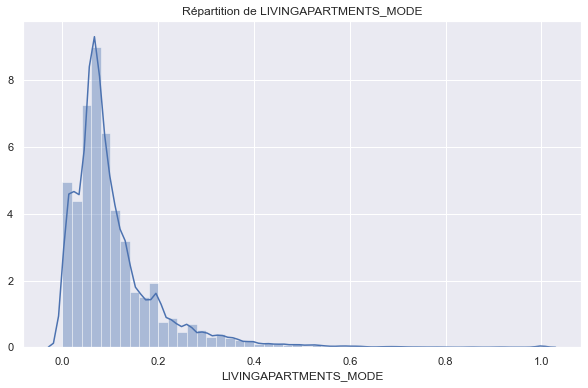

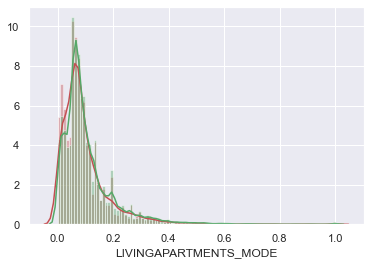

In [176]:
show_numerical(application_train, 'LIVINGAPARTMENTS_MODE')

### LIVINGAREA_MODE
Informations normalisées sur l'immeuble où vit le client. ce qui est moyen (suffixe _AVG). modus (suffixe _MODE). médian (suffixe _MEDI) taille de l'appartement. espace commun. surface habitable. âge de l'immeuble. nombre d'ascenseurs. nombre d'entrées. état de l'immeuble. nombre d'étages


154350 valeurs manquantes
----------------------
Asymetrie : 2.9024505615234375
LOG - Asymetrie : 2.259915828704834
SQR - Asymetrie : 1.038621187210083
----------------------
Corrélation de -3.07% entre LIVINGAREA_MODE et TARGET
----------------------
count   153160.000
mean         0.106
std          0.112
min          0.000
25%          0.043
50%          0.073
75%          0.125
max          1.000
Name: LIVINGAREA_MODE, dtype: float64


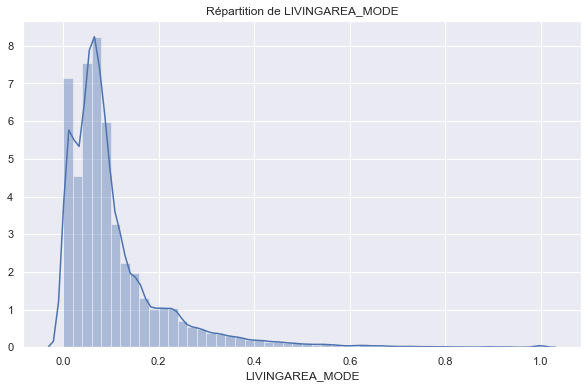

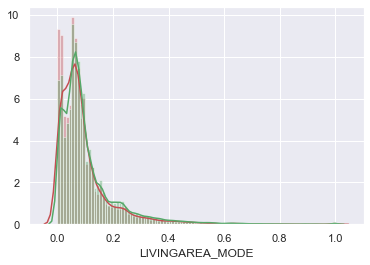

In [177]:
show_numerical(application_train, 'LIVINGAREA_MODE')

### NONLIVINGAPARTMENTS_MODE
Informations normalisées sur l'immeuble où vit le client. ce qui est moyen (suffixe _AVG). modus (suffixe _MODE). médian (suffixe _MEDI) taille de l'appartement. espace commun. surface habitable. âge de l'immeuble. nombre d'ascenseurs. nombre d'entrées. état de l'immeuble. nombre d'étages


213513 valeurs manquantes
----------------------
Asymetrie : 16.251558303833008
LOG - Asymetrie : 13.894740104675293
SQR - Asymetrie : 4.773991584777832
----------------------
Corrélation de -0.16% entre NONLIVINGAPARTMENTS_MODE et TARGET
----------------------
count   93997.000
mean        0.008
std         0.046
min         0.000
25%         0.000
50%         0.000
75%         0.004
max         1.000
Name: NONLIVINGAPARTMENTS_MODE, dtype: float64


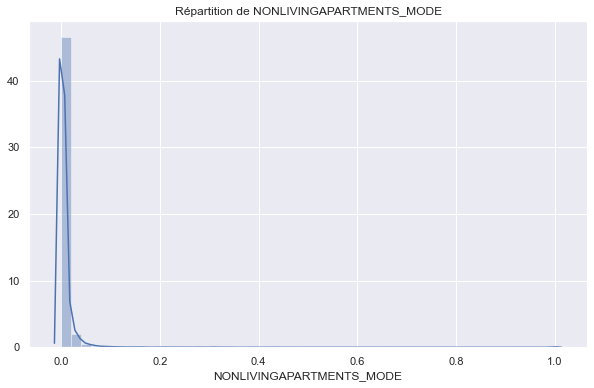

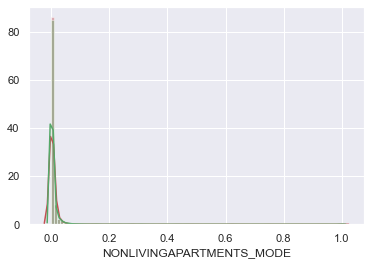

In [178]:
show_numerical(application_train, 'NONLIVINGAPARTMENTS_MODE')

### NONLIVINGAREA_MODE
Informations normalisées sur l'immeuble où vit le client. ce qui est moyen (suffixe _AVG). modus (suffixe _MODE). médian (suffixe _MEDI) taille de l'appartement. espace commun. surface habitable. âge de l'immeuble. nombre d'ascenseurs. nombre d'entrées. état de l'immeuble. nombre d'étages


169681 valeurs manquantes
----------------------
Asymetrie : 6.522380828857422
LOG - Asymetrie : 5.044156074523926
SQR - Asymetrie : 1.9982231855392456
----------------------
Corrélation de -1.27% entre NONLIVINGAREA_MODE et TARGET
----------------------
count   137829.000
mean         0.027
std          0.070
min          0.000
25%          0.000
50%          0.001
75%          0.023
max          1.000
Name: NONLIVINGAREA_MODE, dtype: float64


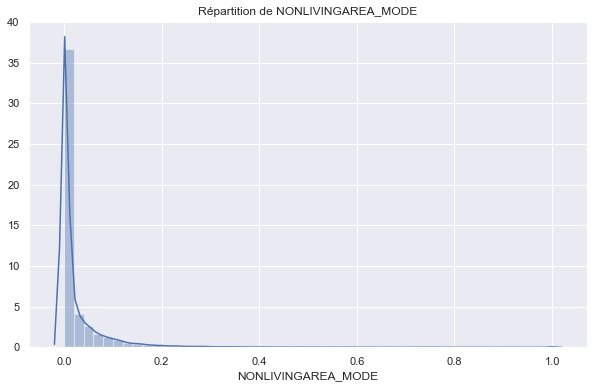

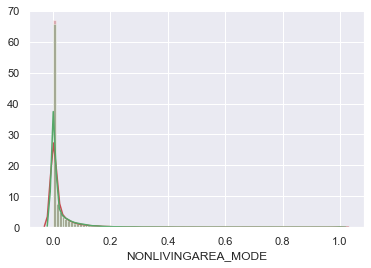

In [179]:
show_numerical(application_train, 'NONLIVINGAREA_MODE')

### APARTMENTS_MEDI
Informations normalisées sur l'immeuble où vit le client. ce qui est moyen (suffixe _AVG). modus (suffixe _MODE). médian (suffixe _MEDI) taille de l'appartement. espace commun. surface habitable. âge de l'immeuble. nombre d'ascenseurs. nombre d'entrées. état de l'immeuble. nombre d'étages


156061 valeurs manquantes
----------------------
Asymetrie : 2.63921856880188
LOG - Asymetrie : 1.9912104606628418
SQR - Asymetrie : 0.7811576128005981
----------------------
Corrélation de -2.92% entre APARTMENTS_MEDI et TARGET
----------------------
count   151449.000
mean         0.118
std          0.109
min          0.000
25%          0.058
50%          0.086
75%          0.149
max          1.000
Name: APARTMENTS_MEDI, dtype: float64


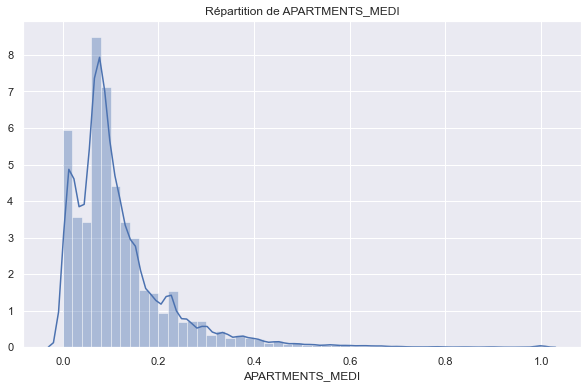

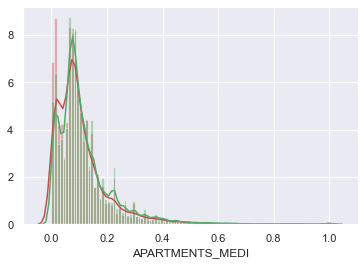

In [180]:
show_numerical(application_train, 'APARTMENTS_MEDI')

### BASEMENTAREA_MEDI
Informations normalisées sur l'immeuble où vit le client. ce qui est moyen (suffixe _AVG). modus (suffixe _MODE). médian (suffixe _MEDI) taille de l'appartement. espace commun. surface habitable. âge de l'immeuble. nombre d'ascenseurs. nombre d'entrées. état de l'immeuble. nombre d'étages


179943 valeurs manquantes
----------------------
Asymetrie : 3.5529863834381104
LOG - Asymetrie : 2.426117181777954
SQR - Asymetrie : 0.07255375385284424
----------------------
Corrélation de -2.21% entre BASEMENTAREA_MEDI et TARGET
----------------------
count   127567.000
mean         0.088
std          0.082
min          0.000
25%          0.044
50%          0.076
75%          0.112
max          1.000
Name: BASEMENTAREA_MEDI, dtype: float64


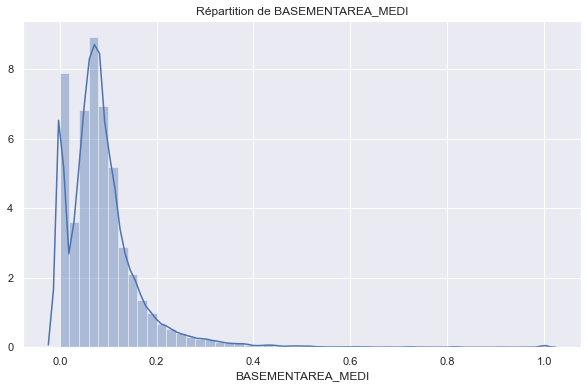

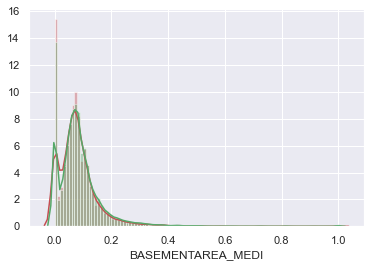

In [181]:
show_numerical(application_train, 'BASEMENTAREA_MEDI')

### YEARS_BEGINEXPLUATATION_MEDI
Informations normalisées sur l'immeuble où vit le client. ce qui est moyen (suffixe _AVG). modus (suffixe _MODE). médian (suffixe _MEDI) taille de l'appartement. espace commun. surface habitable. âge de l'immeuble. nombre d'ascenseurs. nombre d'entrées. état de l'immeuble. nombre d'étages


150007 valeurs manquantes
----------------------
Asymetrie : -15.572933197021484
LOG - Asymetrie : -15.973037719726562
SQR - Asymetrie : -16.359935760498047
----------------------
Corrélation de -1.00% entre YEARS_BEGINEXPLUATATION_MEDI et TARGET
----------------------
count   157503.000
mean         0.978
std          0.060
min          0.000
25%          0.977
50%          0.982
75%          0.987
max          1.000
Name: YEARS_BEGINEXPLUATATION_MEDI, dtype: float64


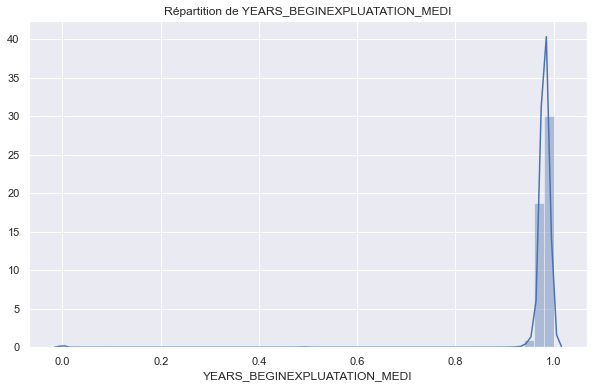

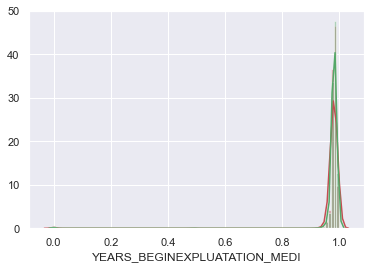

In [182]:
show_numerical(application_train, 'YEARS_BEGINEXPLUATATION_MEDI')

### YEARS_BUILD_MEDI
Informations normalisées sur l'immeuble où vit le client. ce qui est moyen (suffixe _AVG). modus (suffixe _MODE). médian (suffixe _MEDI) taille de l'appartement. espace commun. surface habitable. âge de l'immeuble. nombre d'ascenseurs. nombre d'entrées. état de l'immeuble. nombre d'étages


204487 valeurs manquantes
----------------------
Asymetrie : -0.9627708792686462
LOG - Asymetrie : -1.671525239944458
SQR - Asymetrie : -2.9373114109039307
----------------------
Corrélation de -2.23% entre YEARS_BUILD_MEDI et TARGET
----------------------
count   103023.000
mean         0.756
std          0.112
min          0.000
25%          0.691
50%          0.758
75%          0.826
max          1.000
Name: YEARS_BUILD_MEDI, dtype: float64


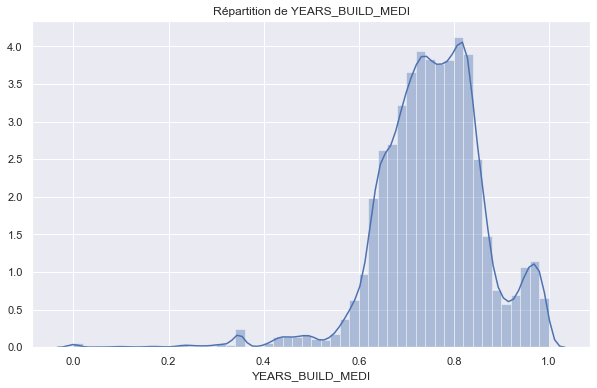

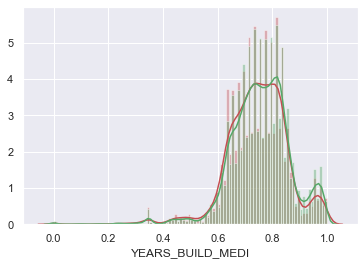

In [183]:
show_numerical(application_train, 'YEARS_BUILD_MEDI')

### COMMONAREA_MEDI
Informations normalisées sur l'immeuble où vit le client. ce qui est moyen (suffixe _AVG). modus (suffixe _MODE). médian (suffixe _MEDI) taille de l'appartement. espace commun. surface habitable. âge de l'immeuble. nombre d'ascenseurs. nombre d'entrées. état de l'immeuble. nombre d'étages


214864 valeurs manquantes
----------------------
Asymetrie : 5.4191508293151855
LOG - Asymetrie : 4.160439968109131
SQR - Asymetrie : 1.5698593854904175
----------------------
Corrélation de -1.86% entre COMMONAREA_MEDI et TARGET
----------------------
count   92646.000
mean        0.045
std         0.076
min         0.000
25%         0.008
50%         0.021
75%         0.051
max         1.000
Name: COMMONAREA_MEDI, dtype: float64


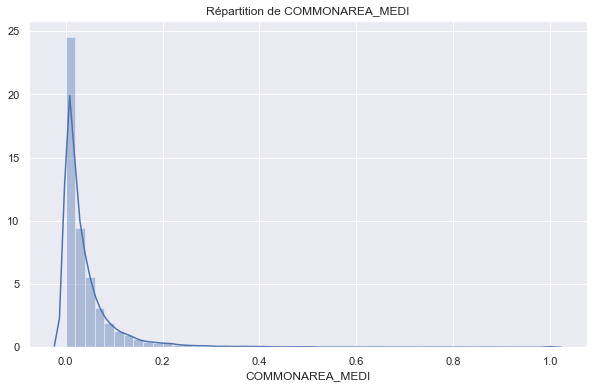

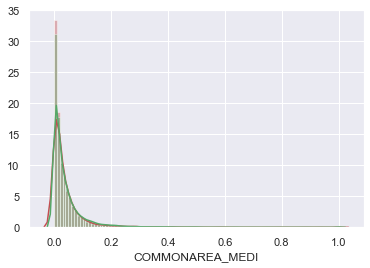

In [184]:
show_numerical(application_train, 'COMMONAREA_MEDI')

### ELEVATORS_MEDI
Informations normalisées sur l'immeuble où vit le client. ce qui est moyen (suffixe _AVG). modus (suffixe _MODE). médian (suffixe _MEDI) taille de l'appartement. espace commun. surface habitable. âge de l'immeuble. nombre d'ascenseurs. nombre d'entrées. état de l'immeuble. nombre d'étages


163891 valeurs manquantes
----------------------
Asymetrie : 2.45778751373291
LOG - Asymetrie : 1.9655154943466187
SQR - Asymetrie : 1.0163233280181885
----------------------
Corrélation de -3.38% entre ELEVATORS_MEDI et TARGET
----------------------
count   143619.000
mean         0.078
std          0.134
min          0.000
25%          0.000
50%          0.000
75%          0.120
max          1.000
Name: ELEVATORS_MEDI, dtype: float64


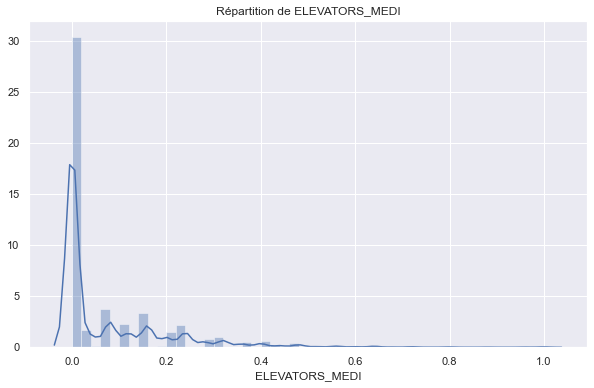

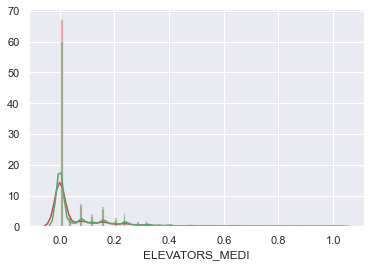

In [185]:
show_numerical(application_train, 'ELEVATORS_MEDI')

### ENTRANCES_MEDI
Informations normalisées sur l'immeuble où vit le client. ce qui est moyen (suffixe _AVG). modus (suffixe _MODE). médian (suffixe _MEDI) taille de l'appartement. espace commun. surface habitable. âge de l'immeuble. nombre d'ascenseurs. nombre d'entrées. état de l'immeuble. nombre d'étages


154828 valeurs manquantes
----------------------
Asymetrie : 2.387697219848633
LOG - Asymetrie : 1.6704708337783813
SQR - Asymetrie : 0.7202891111373901
----------------------
Corrélation de -1.90% entre ENTRANCES_MEDI et TARGET
----------------------
count   152682.000
mean         0.149
std          0.100
min          0.000
25%          0.069
50%          0.138
75%          0.207
max          1.000
Name: ENTRANCES_MEDI, dtype: float64


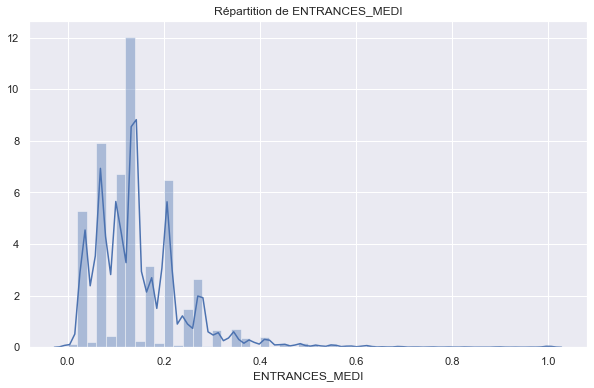

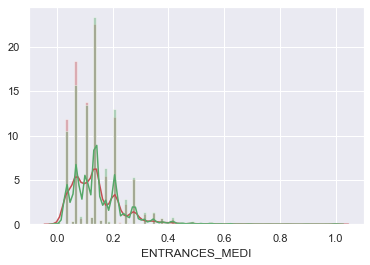

In [186]:
show_numerical(application_train, 'ENTRANCES_MEDI')

### FLOORSMAX_MEDI
Informations normalisées sur l'immeuble où vit le client. ce qui est moyen (suffixe _AVG). modus (suffixe _MODE). médian (suffixe _MEDI) taille de l'appartement. espace commun. surface habitable. âge de l'immeuble. nombre d'ascenseurs. nombre d'entrées. état de l'immeuble. nombre d'étages


153020 valeurs manquantes
----------------------
Asymetrie : 1.2401639223098755
LOG - Asymetrie : 0.8194027543067932
SQR - Asymetrie : -0.0469706729054451
----------------------
Corrélation de -4.38% entre FLOORSMAX_MEDI et TARGET
----------------------
count   154490.000
mean         0.226
std          0.145
min          0.000
25%          0.167
50%          0.167
75%          0.333
max          1.000
Name: FLOORSMAX_MEDI, dtype: float64


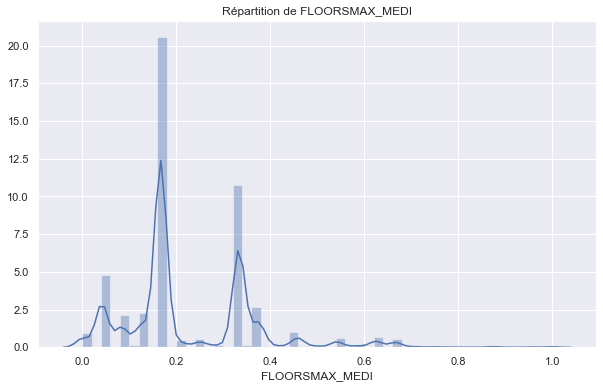

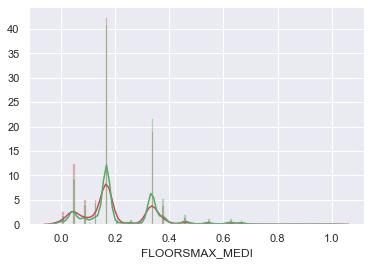

In [187]:
show_numerical(application_train, 'FLOORSMAX_MEDI')

### FLOORSMIN_MEDI
Informations normalisées sur l'immeuble où vit le client. ce qui est moyen (suffixe _AVG). modus (suffixe _MODE). médian (suffixe _MEDI) taille de l'appartement. espace commun. surface habitable. âge de l'immeuble. nombre d'ascenseurs. nombre d'entrées. état de l'immeuble. nombre d'étages


208641 valeurs manquantes
----------------------
Asymetrie : 0.9602119326591492
LOG - Asymetrie : 0.570928156375885
SQR - Asymetrie : -0.14046433568000793
----------------------
Corrélation de -3.34% entre FLOORSMIN_MEDI et TARGET
----------------------
count   98869.000
mean        0.232
std         0.162
min         0.000
25%         0.083
50%         0.208
75%         0.375
max         1.000
Name: FLOORSMIN_MEDI, dtype: float64


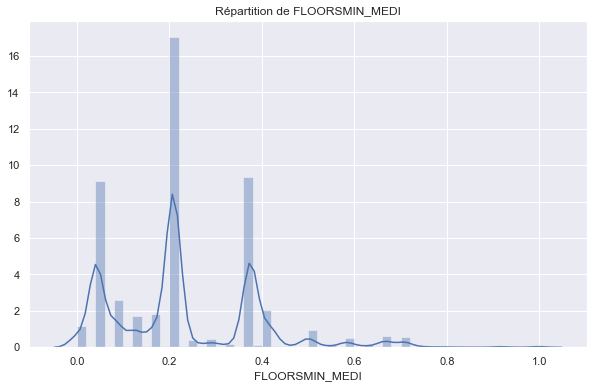

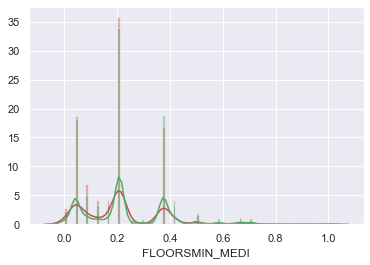

In [188]:
show_numerical(application_train, 'FLOORSMIN_MEDI')

### LANDAREA_MEDI
Informations normalisées sur l'immeuble où vit le client. ce qui est moyen (suffixe _AVG). modus (suffixe _MODE). médian (suffixe _MEDI) taille de l'appartement. espace commun. surface habitable. âge de l'immeuble. nombre d'ascenseurs. nombre d'entrées. état de l'immeuble. nombre d'étages


182590 valeurs manquantes
----------------------
Asymetrie : 4.368223667144775
LOG - Asymetrie : 3.151219367980957
SQR - Asymetrie : 0.7032438516616821
----------------------
Corrélation de -1.13% entre LANDAREA_MEDI et TARGET
----------------------
count   124920.000
mean         0.067
std          0.082
min          0.000
25%          0.019
50%          0.049
75%          0.087
max          1.000
Name: LANDAREA_MEDI, dtype: float64


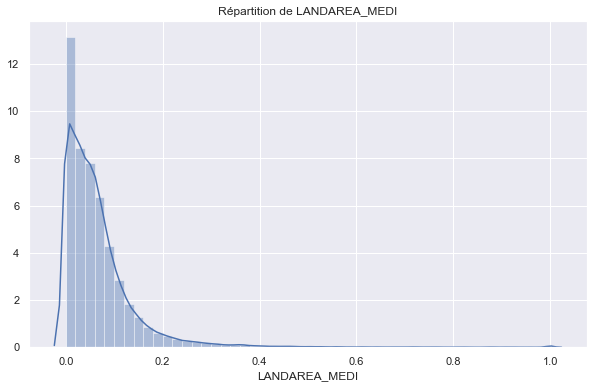

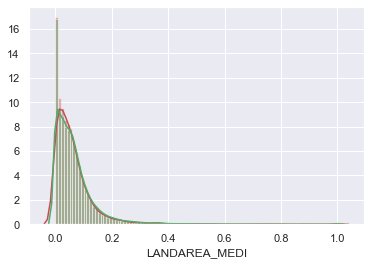

In [189]:
show_numerical(application_train, 'LANDAREA_MEDI')

### LIVINGAPARTMENTS_MEDI
Informations normalisées sur l'immeuble où vit le client. ce qui est moyen (suffixe _AVG). modus (suffixe _MODE). médian (suffixe _MEDI) taille de l'appartement. espace commun. surface habitable. âge de l'immeuble. nombre d'ascenseurs. nombre d'entrées. état de l'immeuble. nombre d'étages


210198 valeurs manquantes
----------------------
Asymetrie : 2.9882454872131348
LOG - Asymetrie : 2.2406134605407715
SQR - Asymetrie : 0.9277554154396057
----------------------
Corrélation de -2.46% entre LIVINGAPARTMENTS_MEDI et TARGET
----------------------
count   97312.000
mean        0.102
std         0.094
min         0.000
25%         0.051
50%         0.076
75%         0.123
max         1.000
Name: LIVINGAPARTMENTS_MEDI, dtype: float64


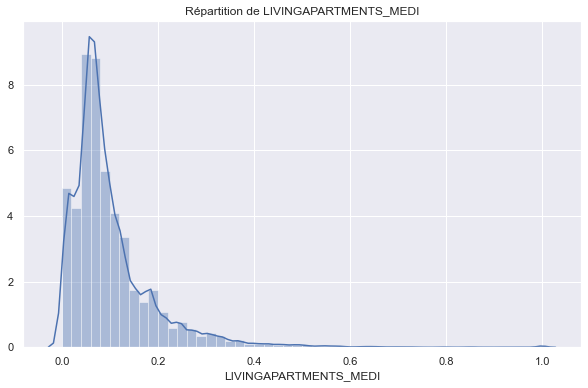

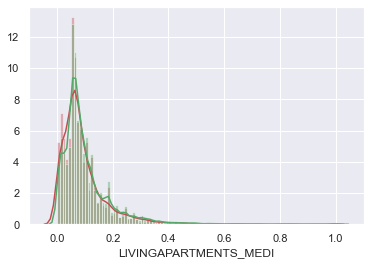

In [190]:
show_numerical(application_train, 'LIVINGAPARTMENTS_MEDI')

### LIVINGAREA_MEDI
Informations normalisées sur l'immeuble où vit le client. ce qui est moyen (suffixe _AVG). modus (suffixe _MODE). médian (suffixe _MEDI) taille de l'appartement. espace commun. surface habitable. âge de l'immeuble. nombre d'ascenseurs. nombre d'entrées. état de l'immeuble. nombre d'étages


154350 valeurs manquantes
----------------------
Asymetrie : 2.848893880844116
LOG - Asymetrie : 2.2076807022094727
SQR - Asymetrie : 1.0179355144500732
----------------------
Corrélation de -3.27% entre LIVINGAREA_MEDI et TARGET
----------------------
count   153160.000
mean         0.109
std          0.112
min          0.000
25%          0.046
50%          0.075
75%          0.130
max          1.000
Name: LIVINGAREA_MEDI, dtype: float64


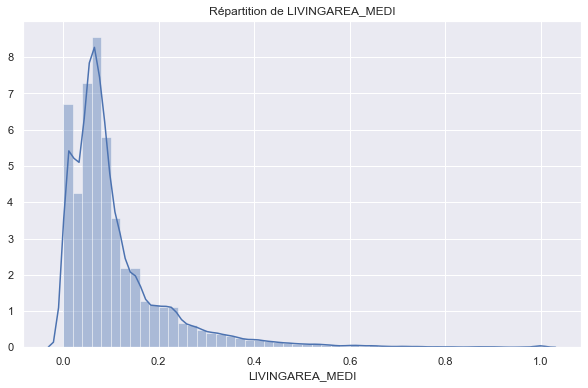

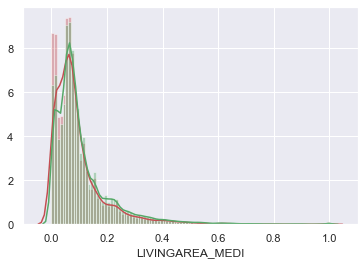

In [191]:
show_numerical(application_train, 'LIVINGAREA_MEDI')

### NONLIVINGAPARTMENTS_MEDI
Informations normalisées sur l'immeuble où vit le client. ce qui est moyen (suffixe _AVG). modus (suffixe _MODE). médian (suffixe _MEDI) taille de l'appartement. espace commun. surface habitable. âge de l'immeuble. nombre d'ascenseurs. nombre d'entrées. état de l'immeuble. nombre d'étages


213513 valeurs manquantes
----------------------
Asymetrie : 15.671740531921387
LOG - Asymetrie : 13.360968589782715
SQR - Asymetrie : 4.619860649108887
----------------------
Corrélation de -0.28% entre NONLIVINGAPARTMENTS_MEDI et TARGET
----------------------
count   93997.000
mean        0.009
std         0.047
min         0.000
25%         0.000
50%         0.000
75%         0.004
max         1.000
Name: NONLIVINGAPARTMENTS_MEDI, dtype: float64


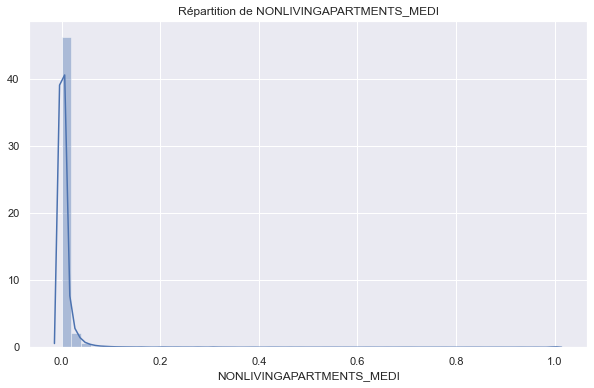

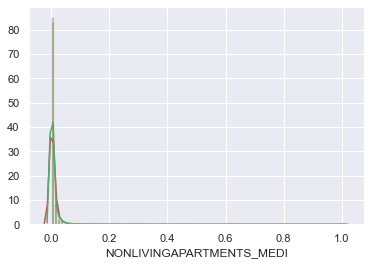

In [192]:
show_numerical(application_train, 'NONLIVINGAPARTMENTS_MEDI')

### NONLIVINGAREA_MEDI
Informations normalisées sur l'immeuble où vit le client. ce qui est moyen (suffixe _AVG). modus (suffixe _MODE). médian (suffixe _MEDI) taille de l'appartement. espace commun. surface habitable. âge de l'immeuble. nombre d'ascenseurs. nombre d'entrées. état de l'immeuble. nombre d'étages


169681 valeurs manquantes
----------------------
Asymetrie : 6.50875997543335
LOG - Asymetrie : 5.000528812408447
SQR - Asymetrie : 1.8973499536514282
----------------------
Corrélation de -1.33% entre NONLIVINGAREA_MEDI et TARGET
----------------------
count   137829.000
mean         0.028
std          0.070
min          0.000
25%          0.000
50%          0.003
75%          0.027
max          1.000
Name: NONLIVINGAREA_MEDI, dtype: float64


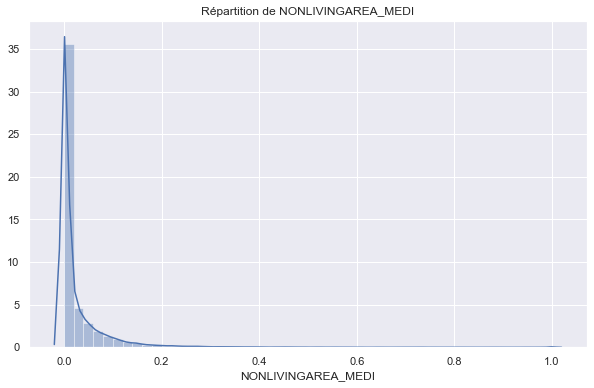

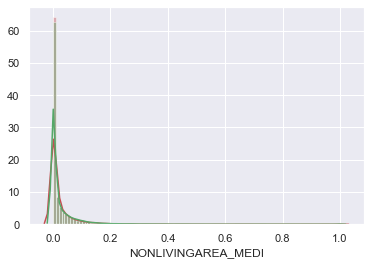

In [193]:
show_numerical(application_train, 'NONLIVINGAREA_MEDI')

### TOTALAREA_MODE
Informations normalisées sur l'immeuble où vit le client. ce qui est moyen (suffixe _AVG). modus (suffixe _MODE). médian (suffixe _MEDI) taille de l'appartement. espace commun. surface habitable. âge de l'immeuble. nombre d'ascenseurs. nombre d'entrées. état de l'immeuble. nombre d'étages

148431 valeurs manquantes
----------------------
Asymetrie : 2.7975335121154785
LOG - Asymetrie : 2.159768581390381
SQR - Asymetrie : 0.9603777527809143
----------------------
Corrélation de -3.26% entre TOTALAREA_MODE et TARGET
----------------------
count   159079.000
mean         0.103
std          0.107
min          0.000
25%          0.041
50%          0.069
75%          0.128
max          1.000
Name: TOTALAREA_MODE, dtype: float64


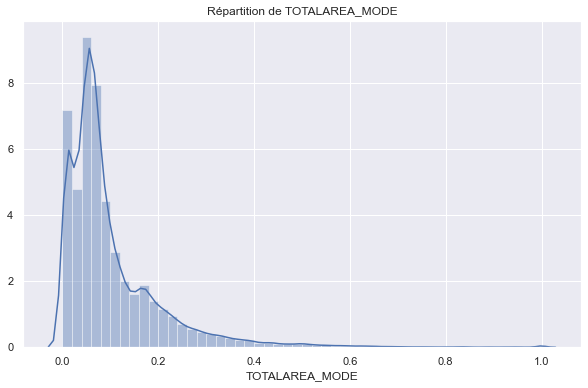

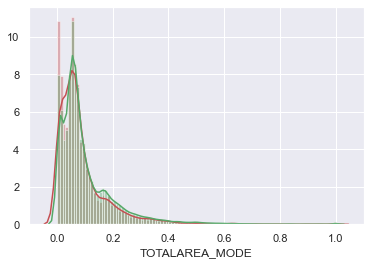

In [194]:
show_numerical(application_train, 'TOTALAREA_MODE')

### OBS_30_CNT_SOCIAL_CIRCLE
Combien d'observations de l'environnement social du client avec 30 DPD (jours de retard) observables


In [195]:
print(f"{application_train['OBS_30_CNT_SOCIAL_CIRCLE'].isna().sum()} valeurs manquantes")

1021 valeurs manquantes


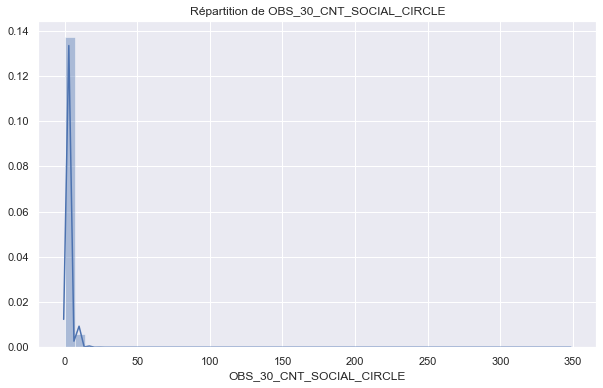

In [196]:
show_distribution(application_train, 'OBS_30_CNT_SOCIAL_CIRCLE')

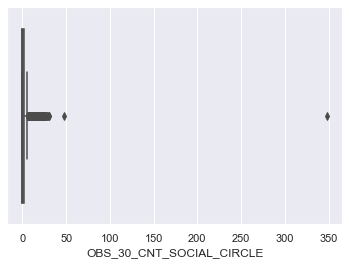

In [197]:
sns.boxplot(x=application_train["OBS_30_CNT_SOCIAL_CIRCLE"]);

Suppression outlier avec une valeur à 348

In [198]:
application_train = application_train.drop(index=application_train.loc[application_train['OBS_30_CNT_SOCIAL_CIRCLE'] == 348].index)

--------------------------
-- OBS_30_CNT_SOCIAL_CIRCLE --
--------------------------
1021 valeurs manquantes
---------------------------
1.02% de corrélation entre OBS_30_CNT_SOCIAL_CIRCLE et TARGET
---------------------------


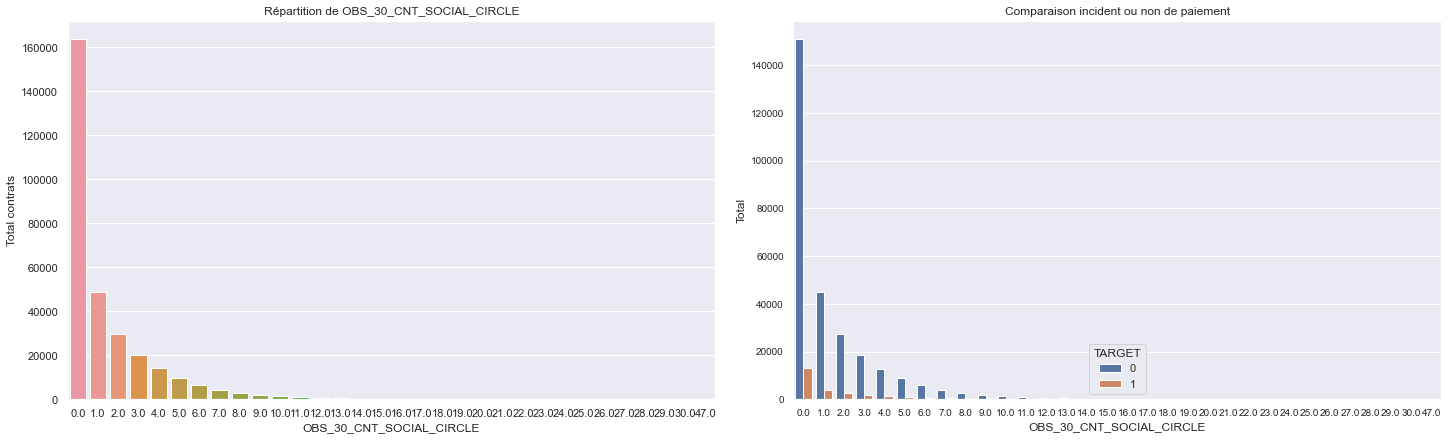

In [199]:
categorical_info(application_train,'OBS_30_CNT_SOCIAL_CIRCLE',label_rotation=0)

### DEF_30_CNT_SOCIAL_CIRCLE
Combien d'observations de l'environnement social du client n'ont pas été effectuées sur 30 DPD (jours de retard) 


In [200]:
print(f"{application_train['DEF_30_CNT_SOCIAL_CIRCLE'].isna().sum()} valeurs manquantes")

1021 valeurs manquantes


In [201]:
application_train['DEF_30_CNT_SOCIAL_CIRCLE'].value_counts()

0.000    271323
1.000     28328
2.000      5323
3.000      1192
4.000       253
5.000        56
6.000        11
7.000         1
8.000         1
Name: DEF_30_CNT_SOCIAL_CIRCLE, dtype: int64

--------------------------
-- DEF_30_CNT_SOCIAL_CIRCLE --
--------------------------
1021 valeurs manquantes
---------------------------
3.37% de corrélation entre DEF_30_CNT_SOCIAL_CIRCLE et TARGET
---------------------------


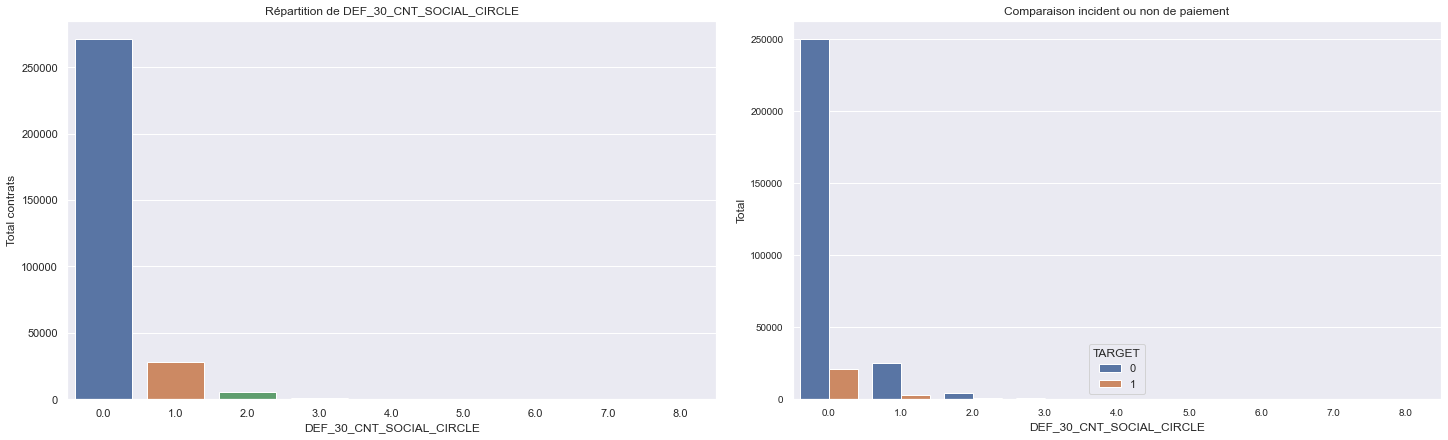

In [202]:
categorical_info(application_train,'DEF_30_CNT_SOCIAL_CIRCLE',label_rotation=0)

### OBS_60_CNT_SOCIAL_CIRCLE
Combien d'observations de l'environnement social du client avec 60 DPD (jours de retard) observables


In [203]:
print(f"{application_train['OBS_60_CNT_SOCIAL_CIRCLE'].isna().sum()} valeurs manquantes")

1021 valeurs manquantes


In [204]:
application_train['OBS_60_CNT_SOCIAL_CIRCLE'].value_counts()

0.000     164665
1.000      48870
2.000      29766
3.000      20215
4.000      13946
5.000       9463
6.000       6349
7.000       4344
8.000       2886
9.000       1959
10.000      1335
11.000       837
12.000       620
13.000       401
14.000       238
15.000       166
16.000       137
17.000        73
18.000        49
19.000        44
20.000        30
21.000        28
22.000        20
23.000        13
24.000        12
25.000        11
27.000         5
29.000         2
28.000         1
47.000         1
26.000         1
30.000         1
Name: OBS_60_CNT_SOCIAL_CIRCLE, dtype: int64

--------------------------
-- OBS_60_CNT_SOCIAL_CIRCLE --
--------------------------
1021 valeurs manquantes
---------------------------
1.01% de corrélation entre OBS_60_CNT_SOCIAL_CIRCLE et TARGET
---------------------------


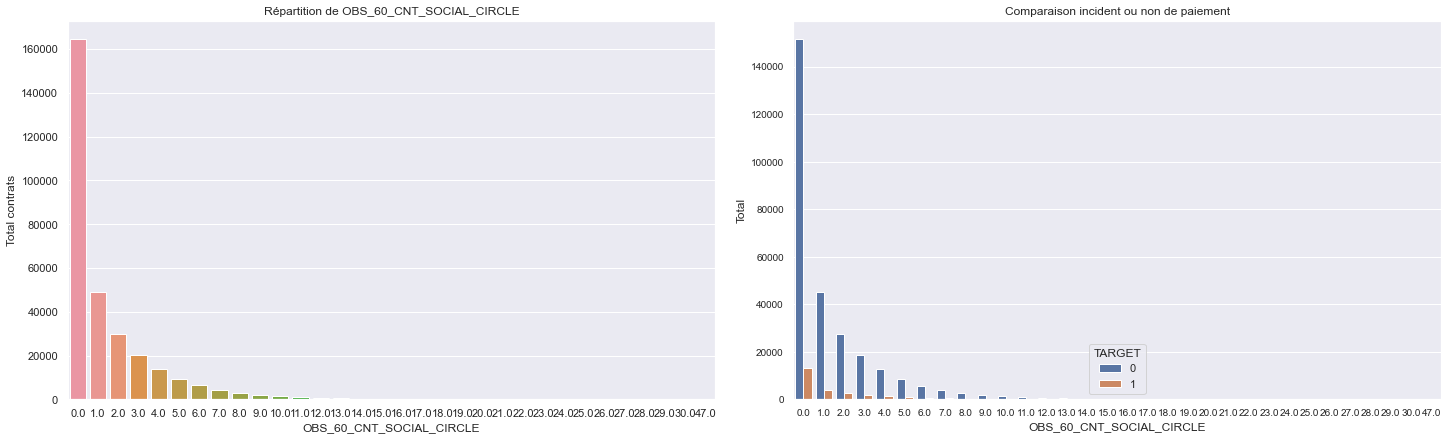

In [205]:
categorical_info(application_train,'OBS_60_CNT_SOCIAL_CIRCLE',label_rotation=0)

### DEF_60_CNT_SOCIAL_CIRCLE
Combien d'observations de l'environnement social du client n'ont pas été effectuées sur 60 (jours de retard) DPD


In [206]:
print(f"{application_train['DEF_60_CNT_SOCIAL_CIRCLE'].isna().sum()} valeurs manquantes")

1021 valeurs manquantes


In [207]:
application_train['DEF_60_CNT_SOCIAL_CIRCLE'].value_counts()

0.000    280720
1.000     21841
2.000      3170
3.000       598
4.000       135
5.000        20
6.000         3
7.000         1
Name: DEF_60_CNT_SOCIAL_CIRCLE, dtype: int64

--------------------------
-- DEF_60_CNT_SOCIAL_CIRCLE --
--------------------------
1021 valeurs manquantes
---------------------------
3.27% de corrélation entre DEF_60_CNT_SOCIAL_CIRCLE et TARGET
---------------------------


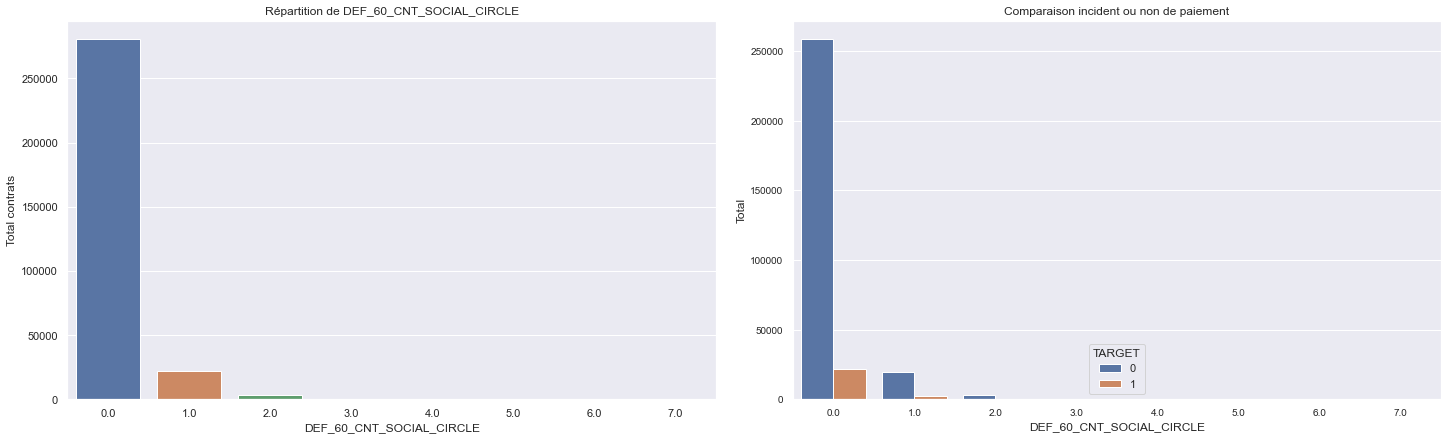

In [208]:
categorical_info(application_train,'DEF_60_CNT_SOCIAL_CIRCLE',label_rotation=0)

### DAYS_LAST_PHONE_CHANGE
Combien de jours avant la demande le client a-t-il changé de téléphone

1 valeurs manquantes
----------------------
Asymetrie : -0.713594913482666
LOG - Asymetrie : -1.5044875144958496
SQR - Asymetrie : -0.24044108390808105
----------------------
Corrélation de 5.52% entre DAYS_LAST_PHONE_CHANGE et TARGET
----------------------
count   307508.000
mean      -962.863
std        826.809
min      -4292.000
25%      -1570.000
50%       -757.000
75%       -274.000
max          0.000
Name: DAYS_LAST_PHONE_CHANGE, dtype: float64


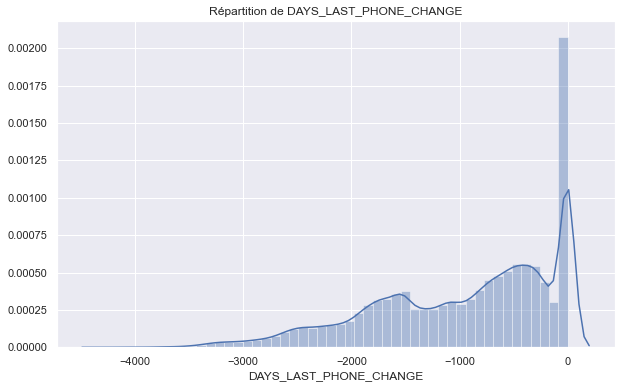

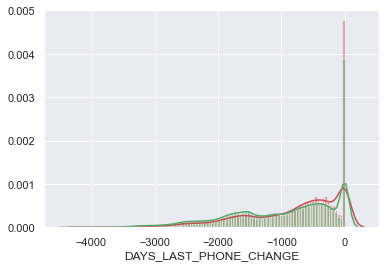

In [209]:
show_numerical(application_train, 'DAYS_LAST_PHONE_CHANGE')

In [210]:
application_train['YEARS_LAST_PHONE_CHANGE'] = abs(application_train['DAYS_LAST_PHONE_CHANGE']) / 365.25
application_train = application_train.drop('DAYS_LAST_PHONE_CHANGE', axis=1)

1 valeurs manquantes
----------------------
Asymetrie : 0.7135952115058899
LOG - Asymetrie : -0.19961842894554138
SQR - Asymetrie : -0.24043992161750793
----------------------
Corrélation de -5.52% entre YEARS_LAST_PHONE_CHANGE et TARGET
----------------------
count   307508.000
mean         2.636
std          2.264
min          0.000
25%          0.750
50%          2.073
75%          4.298
max         11.751
Name: YEARS_LAST_PHONE_CHANGE, dtype: float64


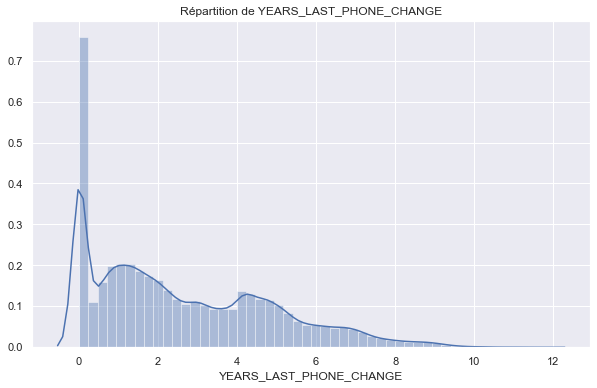

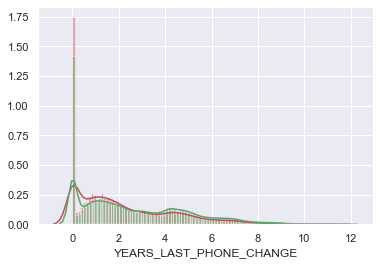

In [211]:
show_numerical(application_train, 'YEARS_LAST_PHONE_CHANGE')

# Première conclusion
Cette première exploration a fait apparaitre que certaines variables explicatives ne semblent pas avoir d'incidence sur le remboursement ou non du prêt, cela sera confirmé lors que la sélection des variables.

Nous avons aussi identifié des variables qui avaient de nombreuses variables manquantes, cela sera traité lors de la sélection des variables.

# Nouvelle variables
De nouvelle variables peuvent être crées afin d'augmenter la robustesse du modèle. Nous ajouterons :
 - le taux de rémunération qui est la différence entre les mensualités (AMT_ANNUITY) et le montant du crédit (AMT_CREDIT)
 - Le rapport entre le revenu et le montant emprunté
 - Le rapport entre les mensualité et le revenu
 - Le revenu par personne au foyer

In [212]:
application_train['PAYMENT_RATE'] = (application_train['AMT_ANNUITY'] / application_train['AMT_CREDIT']) * 100
application_train['INCOME_CREDIT_RATE'] = (application_train['AMT_INCOME_TOTAL'] / application_train['AMT_CREDIT']) * 100
application_train['ANNUITY_INCOME_RATE'] = (application_train['AMT_ANNUITY'] / application_train['AMT_INCOME_TOTAL']) * 100
application_train['INCOME_PER_PERSON'] = application_train['AMT_INCOME_TOTAL'] / application_train['CNT_FAM_MEMBERS']

# Corrélations
Les corrélations entre les variables va nous permettre de détecter les variables qui seraient semblables.

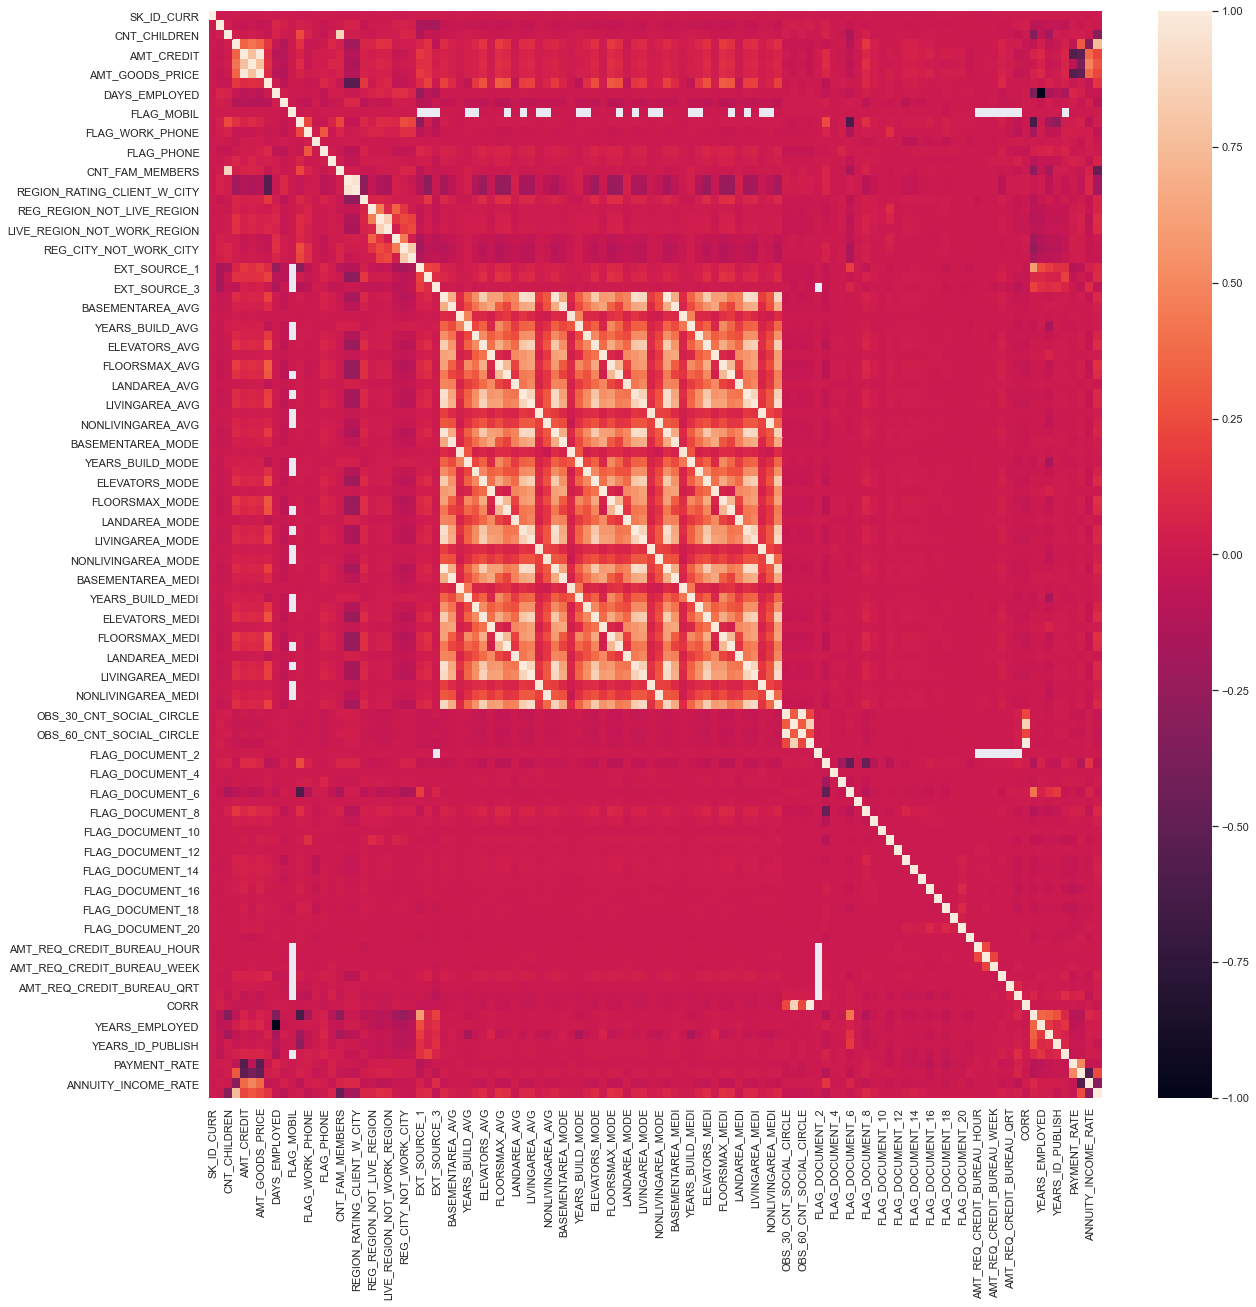

In [213]:
corr = application_train.corr()

plt.figure(figsize=(20,20))
x = sns.heatmap(corr)
plt.show()

In [214]:
print(f"Corrélation de {application_train['REGION_RATING_CLIENT'].corr(application_train['REGION_RATING_CLIENT_W_CITY']) * 100:.2f}% entre REGION_RATING_CLIENT et REGION_RATING_CLIENT_W_CITY")
print(f"Corrélation de {application_train['AMT_GOODS_PRICE'].corr(application_train['AMT_CREDIT']) * 100:.2f}% entre AMT_GOODS_PRICE et AMT_CREDIT")
print(f"Corrélation de {application_train['OBS_30_CNT_SOCIAL_CIRCLE'].corr(application_train['OBS_60_CNT_SOCIAL_CIRCLE']) * 100:.2f}% entre OBS_30_CNT_SOCIAL_CIRCLE et OBS_60_CNT_SOCIAL_CIRCLE")

Corrélation de 95.08% etre REGION_RATING_CLIENT et REGION_RATING_CLIENT_W_CITY
Corrélation de 98.70% entre AMT_GOODS_PRICE et AMT_CREDIT
Corrélation de 99.84% entre OBS_30_CNT_SOCIAL_CIRCLE et OBS_60_CNT_SOCIAL_CIRCLE


Cette approche permet de voir la corrélation entre **AMT_CREDIT** et **AMT_GOODS_PRICE** est importante. En effet le montant du crédit est en général relié au montant de l'achat. Il sera donc nécessaire de ne garder qu'une seule de ces deux valeurs. la corrélation entre **OBS_30_CNT_SOCIAL_CIRCLE** et **OBS_60_CNT_SOCIAL_CIRCLE** est de plus de 99%, ce tendrait à dire les clients qui ont 30 jours de retard ont aussi souvent 60 jours de retard. De même que pour les l'appréciation de la région et de la ville sont très corrélés, si une ville à une bonne note cela sera de même pour la région.

Les corrélations étant à plus de 90% devrons êtres éliminées. C'est à dire qu'une seule des deux variables devra être conservée.

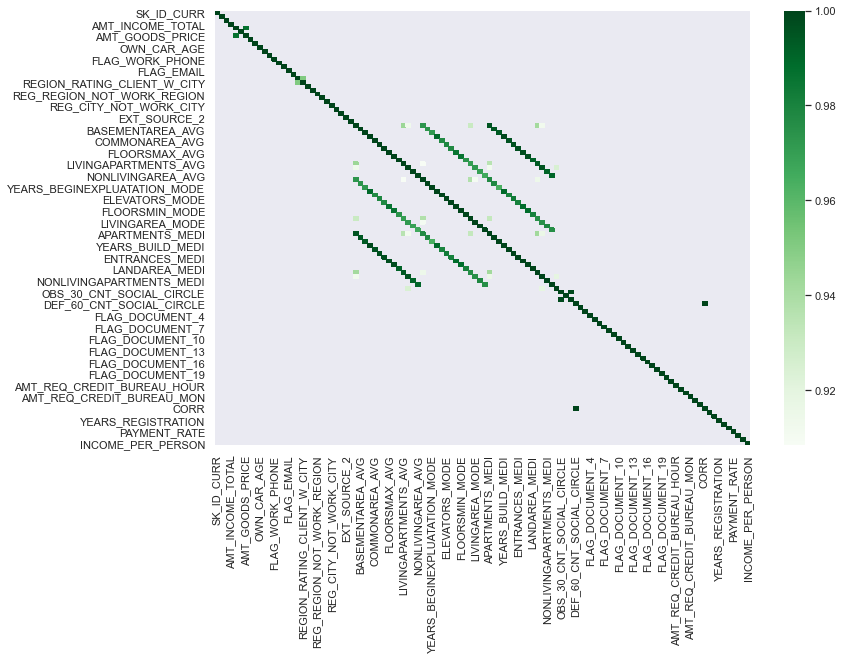

In [215]:
# Corrélation supérieurs à 90%
kot = corr[corr>=.9]
plt.figure(figsize=(12,8))
sns.heatmap(kot, cmap="Greens")

In [216]:
high_correlation(application_train, 0.9)

98.70 de corrélation entre AMT_GOODS_PRICE et AMT_CREDIT
95.08 de corrélation entre REGION_RATING_CLIENT_W_CITY et REGION_RATING_CLIENT
94.40 de corrélation entre LIVINGAPARTMENTS_AVG et APARTMENTS_AVG
91.36 de corrélation entre LIVINGAREA_AVG et APARTMENTS_AVG
97.33 de corrélation entre APARTMENTS_MODE et APARTMENTS_AVG
90.83 de corrélation entre APARTMENTS_MODE et LIVINGAPARTMENTS_AVG
97.35 de corrélation entre BASEMENTAREA_MODE et BASEMENTAREA_AVG
97.19 de corrélation entre YEARS_BEGINEXPLUATATION_MODE et YEARS_BEGINEXPLUATATION_AVG
98.94 de corrélation entre YEARS_BUILD_MODE et YEARS_BUILD_AVG
97.71 de corrélation entre COMMONAREA_MODE et COMMONAREA_AVG
97.88 de corrélation entre ELEVATORS_MODE et ELEVATORS_AVG
97.77 de corrélation entre ENTRANCES_MODE et ENTRANCES_AVG
98.57 de corrélation entre FLOORSMAX_MODE et FLOORSMAX_AVG
98.59 de corrélation entre FLOORSMIN_MODE et FLOORSMIN_AVG
97.37 de corrélation entre LANDAREA_MODE et LANDAREA_AVG
93.06 de corrélation entre LIVINGAPARTMEN

# Conclusion
Cette première étape nous a permit d'indentifier les variables qui sont corrélées entre elle et qui devrons être supprimées. Nous avons aussi identifié des transformation de variables soit en application une fonction log, soit en application des calculs sur celle-ci comme par exemple la transformation des jours en années, enfin nous avons créé de nouvelles variables à partir de celles déjà existantes.

Dans la prochaine étape, nous appliquerons les modifications que nous avons trouvé et nous procéderons à une sélection des variables les plus importantes. 

